Stepik User ID: 1112121706

## **Введение**

Данная работа посвящена изучению Geometric Deep Learning (GDL) на практических примерах. Мы возьмем простой датасет QM9, содержащий данные по простым молекулам. На этих данных обучим несколько различных нейросетей, чтобы посмотреть, как геометрические принципы (Geometric Priors), заложенные в виде предположений о структуре и геометрии данных (Inductive Biases) в архитектуру моделей, влияют на точность предсказания характеристик молекул (regression targets). Эксперименты проводятся в среде Colab, поэтому для иллюстрации основных идей возьмем небольшую часть датасета. Мы не превзойдем state-of-the-art в GDL и не откроем новых архитектур, но покажем, что GDL работает - точность предсказаний повышается.

**План:**



1.   **Введение (План работы)**
*   Установка зависимостей. Импорты библиотек. Загрузка датасета
*   Исследование QM9
*   Визуализация молекулы
2.   **Baseline models** - общие для всех моделей ф-ции
*   Необученные модели - для тестов
*   Обученные модели - специфические функции
3.   **Run Section** - глобальные переменные
*   train FCNN
*   train GCN
*   train DistanceGNN
*   train EGNN
4.   **ТЕСТЫ**
*   Тесты. Сохранение результатов (test MSE)
*   Plot training curves
*   Test MSE. Таблицы
*   Rotation tests
*   Test geometry ablation
5.   **ВЫВОДЫ**

# --Установка зависимостей. Импорты библиотек. Загрузка датасета.

In [1]:
# Install dependencies
!pip install torch torch-geometric egnn-pytorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 23.9 MB/s eta 0:00:00


In [2]:
!pip install ripser persim

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 842.1/842.1 kB 17.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.6/48.6 kB 1.6 MB/s eta 0:00:00
  Created wheel for hopcroftkarp: filename=hopcroftkarp-1.2.5-py2.py3-none-any.whl size=18104 sha256=533f071ba42b9e8cbc06a514801ad137d77ae97f814149f59f9fceb7ffd2fd37
  Stored in directory: /root/.cache/pip/wheels/2a/fd/fe/f4b8fd82894e1d9e04040ef41dc5ae6eb7a8e9b0ef5a9402fe
Successfully built hopcroftkarp


In [3]:
import torch

from torch_geometric.datasets import QM9

import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import copy

from egnn_pytorch import EGNN

import torch.nn as nn
import torch.nn.functional as F

import os
import json

from ripser import ripser
from scipy.stats import spearmanr
from scipy.stats import mannwhitneyu

In [4]:
from torch_geometric.loader import DataLoader as geometric_DataLoader

from torch.utils.data import DataLoader # +collate_fn

Мы хотим иметь возможность обращаться к конкретной молекуле в датасете. Т.к. по умолчанию нет никакого id - с названием или числом, то чтобы отслеживать (идентифицировать) каждую молекулу даже после перемешивания датасета мы присвоим каждой молекуле индекс. Если просто запустить цикл по присваиванию индекса по порядковому номеру молекулы в датасете (dataset = QM9(root='data/QM9') , enumerate(dataset)), получится dataset[56].idx=56, но dataset[57].idx=58. QM9 датасет -- это список объектов данных, где некоторые объекты "поломаны" (есть пустые таргеты и т.п.). enumerate(dataset) итерирует по уже отфильтрованным данным, т.е. возвращает не все data из исходного датасета. В итоге полученные data.idx != dataset[idx]. Поэтому на этапе загрузки датасета мы сразу присвоим индексы тем объектам data, для которых даступна функция get.

In [5]:
class QM9WithIndex(QM9):
    def get(self, idx):
        data = super().get(idx)
        data.idx = torch.tensor(idx)
        return data

In [6]:
dataset = QM9WithIndex(root='data/QM9')

Extracting data/QM9/raw/qm9_v3.zip
Processing...
Using a pre-processed version of the dataset. Please install 'rdkit' to alternatively process the raw data.
Done!


Please install 'rdkit' to alternatively process the raw data. --> (from rdkit import Chem) -- это интересная возможность получить датасет с химическими features: atom.GetIsAromatic(), atom.IsInRing(), ...

Мы в работе будем пользоваться только PyG версией QM9. Которая содержит следующую информацию об атомах в молекуле: координаты, атомномное число, количество химических связей у атома (1, 2,3, 4 - в one-hot кодировке), есть ли связть с водородом.

In [7]:
# +
# globals

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")
print("Using device:", device)

Using device: cpu


При пробных запусках обучения были рессмотрены варианты как на CPU, так и GPU. Для FCNN, GCN и DistanceGNN - по субъективным ощущениям не было замечено никакой разницы. НО для EGNN обучение на GPU оказалось менее стабильным, MSE получался заметно больше (возможно, batch_size=8 - слишком маленький для GPU), при этом даже не было выигрыша в скорости обучения. Наоборот, для EGNN переход на GPU привел к увеличению времени на эпоху и обрыву обучения в Colab после 10й эпохи. Поскольку выводы по Inductive bias не зависят (не должны зависеть) от device, в тетрадке приведены результаты по обучению на CPU. Чтобы обучение EGNN в Colab было возможным, размер батча уменьшили до 1, но при помощи аккумуляции батчей мы симулируем размер батча =8. При обучение на GPU возникает проблема Mixed Precision (из-за autocast) -- изменяет задачу оптимизации при запуске на GPU (В рамках FP16 выполняется множество операций) --> ухудшение результата за счет аккумуляции шума. При малых обновлениях координат величина шума дает существенный вклад в ошибку. При обучении на CPU все рассчеты ведутся на FP32, т.е. результат не так зашумлен. Обучение более стабильно и лучше сходимость к решению.

In [8]:
# +
# globals

QM9_TARGETS = {
    'mu': 0,
    'alpha': 1,
    'homo': 2,
    'lumo': 3,
    'gap': 4,
    'r2': 5,
    'zpve': 6,
    'U0': 7,
    'U': 8,
    'H': 9,
    'G': 10,
    'Cv': 11
}

MAX_ATOMS = 29

In [9]:
# +
# globals

def random_rotation_matrix():
    A = torch.randn(3, 3)
    Q, _ = torch.linalg.qr(A)
    if torch.det(Q) < 0:
        Q[:, 0] *= -1
    return Q

# Исследование QM9

dataset представляет собой класс из библиотеки torch_geometric.datasets. Инициализация этого класса приводит к появлению списка объектов данных, где data = Data(
                x=x,
                z=z,
                pos=pos,
                edge_index=edge_index,
                smiles=smiles,
                edge_attr=edge_attr,
                y=y[i].unsqueeze(0),
                name=name,
                idx=i,
            ). Имеет встроенные функции mean и std. https://pytorch-geometric.readthedocs.io/en/2.6.0/_modules/torch_geometric/datasets/qm9.html

QM9 содержит более 130 тыс. простых органических молекул, описанных при помощи 13 свойств, просчитанных DFT (Density Functional Theory) методом. Содержит полную пространственную информацию для низкоэнергетического состояния атомов в молекуле.

In [ ]:
# geometric properties (atomic coordinates) are integrated into features

data = dataset[0] # molecule with idx = 0

In [ ]:
# idx - added feature, there is no idx initially in the dataset
data.idx

tensor([0])

In [ ]:
data.x      # node features (one-hot)

tensor([[0., 1., 0., 0., 0., 6., 0., 0., 0., 0., 4.],
        [1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]])

In [ ]:
# feature[-1] - количество связей с водородом
# feature[0] - 1 связь (one-hot)
# feature[1] - 4 связи (one-hot)
# feature[2] - 3 связи (one-hot)
# feature[3] - 2 связи (one-hot)
# feature[5] - атомное число
# остальное - всегда 0

In [ ]:
data.z      # atomic numbers

tensor([6, 1, 1, 1, 1])

In [ ]:
data.pos    # (N, 3) coordinates

tensor([[-1.2700e-02,  1.0858e+00,  8.0000e-03],
        [ 2.2000e-03, -6.0000e-03,  2.0000e-03],
        [ 1.0117e+00,  1.4638e+00,  3.0000e-04],
        [-5.4080e-01,  1.4475e+00, -8.7660e-01],
        [-5.2380e-01,  1.4379e+00,  9.0640e-01]])

In [ ]:
data.y      # targets (atom features)

tensor([[    0.0000,    13.2100,   -10.5499,     3.1865,    13.7363,    35.3641,
             1.2177, -1101.4878, -1101.4098, -1101.3840, -1102.0229,     6.4690,
           -17.1722,   -17.2868,   -17.3897,   -16.1519,   157.7118,   157.7100,
           157.7070]])

In [ ]:
# QM9 has 19 targets (some deprecated / duplicates)
data.y.shape

torch.Size([1, 19])

In [ ]:
# https://pytorch-geometric.readthedocs.io/en/stable/generated/torch_geometric.datasets.QM9.html
# PyTorch Geometric follows the original QM9 order:

# TARGETS

# Index	  Property	  Description

# 0	      mu	        dipole moment
# 1	      alpha	      isotropic polarizability
# 2	      homo	      HOMO energy
# 3	      lumo	      LUMO energy
# 4	      gap	        HOMO–LUMO gap
# 5	      r2	        electronic spatial extent
# 6	      zpve	      zero point vibrational energy
# 7	      U0	        internal energy at 0K
# 8	      U	          internal energy at 298K
# 9	      H	          enthalpy
# 10	    G	          free energy
# 11	    Cv	        heat capacity

# (Indices above 11 are legacy / unused in practice.)

In [ ]:
# # +
# # globals

# QM9_TARGETS = {
#     'mu': 0,
#     'alpha': 1,
#     'homo': 2,
#     'lumo': 3,
#     'gap': 4,
#     'r2': 5,
#     'zpve': 6,
#     'U0': 7,
#     'U': 8,
#     'H': 9,
#     'G': 10,
#     'Cv': 11
# }

# MAX_ATOMS = 29

Посмотрим на распределения таргетов 'U0' и 'mu', проверим данные на NAN, inf.

**U0** - zero-point energy - наименьший уровень энергии (ground state), который может быть. При температуре 0 Кельвинов (почти 0) минимальна кинетическая энергия, частицы на минимальных энергетических орбиталях. U0 в основном зависит от типа атомов, коррелирует с размером молекулы, определяется количеством и типом химических связей. Из имеющихся таргетов относится к наименее чувствительным к 3D-геометрии. Но для GDL - является отличным baseline.

/tmp/ipython-input-1784657475.py:1: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. The data of the dataset is already cached, so any modifications to `data` will not be reflected when accessing its elements. Clearing the cache now by removing all elements in `dataset._data_list`. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  all_y = dataset.data.y[:, QM9_TARGETS['U0']]


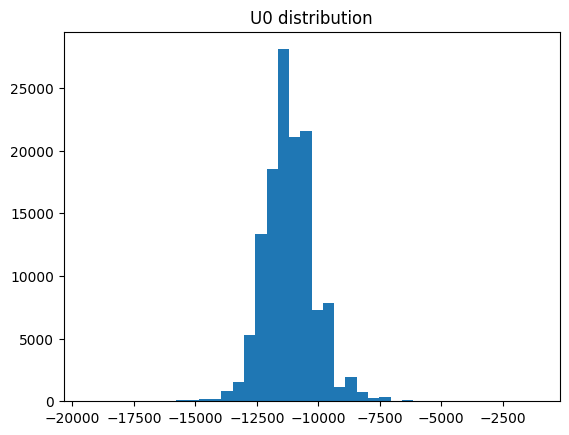

In [ ]:
all_y = dataset.data.y[:, QM9_TARGETS['U0']]

plt.hist(all_y.numpy(), bins=40)
plt.title("U0 distribution")
plt.show()

U0 в QM9 датасете имеет симметричное, гладкое распределение без пиков и провалов.

In [ ]:
torch.isnan(all_y).any()

tensor(False)

In [ ]:
torch.isinf(all_y).any()

tensor(False)

In [ ]:
all_y.min(), all_y.max()

(tensor(-19444.3867), tensor(-1101.4878))

**mu** - дипольный момент, зависит напрямую от пространственного расположения *mu* =*qd* (где mu - дипольный момент, q - величина заряда, d - расстояние между зарядами). Поэтому дипольный момент считают каноническим таргетом для GML. Тем не менее, дипольный момент является векторной величиной - это важный Inductive Biase, который не заложен в те архитектуры, которые будут рассмотрены в этой работе. Важность векторности для дипольного момента можно будет увидеть в том, что обучение будет происходить неэффективно. Не хватает информации о величине зярядов в узлах (она хоть и коррелирует с типом атома, но так же зависит от вида электронных облаков). Дипольные момемнты отдельных связей векторно складываются в общий дипольный момент молекулы. Симметричные молекулы (метан) - имеют 0 дипольный момент.

/tmp/ipython-input-316711965.py:1: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  all_y = dataset.data.y[:, QM9_TARGETS['mu']]


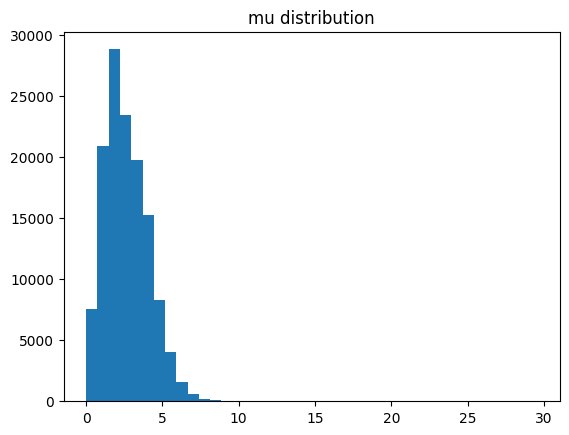

In [ ]:
# `dataset.{attr_name}`
all_y = dataset.data.y[:, QM9_TARGETS['mu']]

plt.hist(all_y.numpy(), bins=40)
plt.title("mu distribution")
plt.show()

Асимметричное распределение (нормализация обязательна). Units: Debye

Typical QM9 range: roughly 0 → 10

In [ ]:
torch.isnan(all_y).any()

tensor(False)

In [ ]:
torch.isinf(all_y).any()

tensor(False)

In [ ]:
all_y.min(), all_y.max()

(tensor(0.), tensor(29.5564))

**Визуализация молекулы**

Молекула с индексом 0 - **метан**. Посмотрим на эту молекулу в заданных координатах и после применения произвольного вращения. Проверим, что после вращения сохранились расстояния между атомами.

In [10]:
# Map atomic numbers to element symbols
ATOM_MAP = {
    1: ('H', 'orange'),
    6: ('C', 'blue'),
    7: ('N', 'purple'),
    8: ('O', 'red'),
    9: ('F', 'green')
}

In [11]:
# By default, Matplotlib distorts aspect ratio. -->

def set_equal_aspect(ax, pos):
    max_range = (pos.max(axis=0) - pos.min(axis=0)).max() / 2
    mid = pos.mean(axis=0)
    ax.set_xlim(mid[0] - max_range, mid[0] + max_range)
    ax.set_ylim(mid[1] - max_range, mid[1] + max_range)
    ax.set_zlim(mid[2] - max_range, mid[2] + max_range)

In [ ]:
# # +
# # globals

# def random_rotation_matrix():
#     A = torch.randn(3, 3)
#     Q, _ = torch.linalg.qr(A)
#     if torch.det(Q) < 0:
#         Q[:, 0] *= -1
#     return Q

In [12]:
def plot_molecule(pos, z, edge_index=None, title="Molecule"):
    pos = pos.detach().cpu().numpy() if torch.is_tensor(pos) else np.asarray(pos)
    z = z.detach().cpu().numpy() if torch.is_tensor(z) else np.asarray(z)

    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_subplot(111, projection='3d')

    for atomic_num in np.unique(z):
        mask = z == atomic_num
        symbol, color = ATOM_MAP[int(atomic_num)]
        ax.scatter(
            pos[mask, 0],
            pos[mask, 1],
            pos[mask, 2],
            s=120,
            color=color,
            label=symbol
        )

    if edge_index is not None:
        edge_index = edge_index.cpu().numpy()
        for i, j in edge_index.T:
            ax.plot(
                [pos[i, 0], pos[j, 0]],
                [pos[i, 1], pos[j, 1]],
                [pos[i, 2], pos[j, 2]],
                color='gray',
                linewidth=1
            )

    set_equal_aspect(ax, pos)

    ax.set_title(title)
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    ax.legend()

    plt.show()

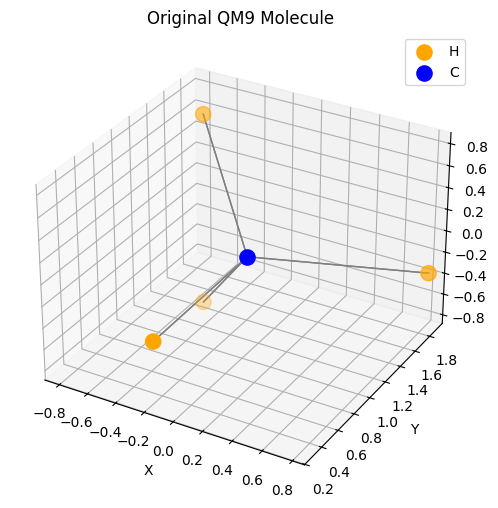

In [ ]:
plot_molecule(
    pos=data.pos,
    z=data.z,
    edge_index=data.edge_index,
    title="Original QM9 Molecule"
)

In [ ]:
R = random_rotation_matrix()
pos_rot = data.pos @ torch.tensor(R, dtype=data.pos.dtype)

/tmp/ipython-input-3409103275.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pos_rot = data.pos @ torch.tensor(R, dtype=data.pos.dtype)


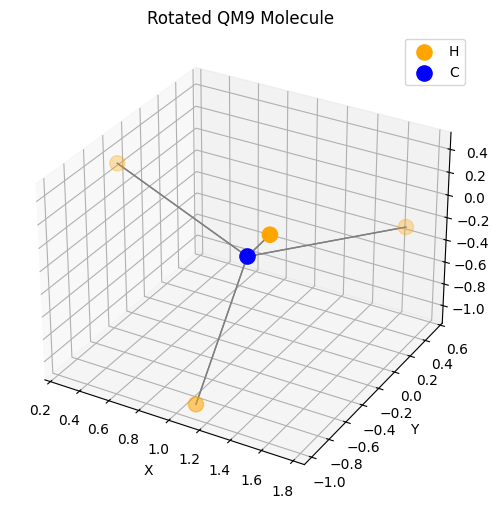

In [ ]:
plot_molecule(
    pos=pos_rot,
    z=data.z,
    edge_index=data.edge_index,
    title="Rotated QM9 Molecule"
)

In [ ]:
# Check. Rotation must preserve distances.

dist_original = torch.cdist(data.pos, data.pos)
dist_rotated = torch.cdist(pos_rot, pos_rot)

print(torch.allclose(dist_original, dist_rotated, atol=1e-5))

True


In [ ]:
from torch.utils.data import Subset

In [ ]:
target_name = "U0"
target_idx = QM9_TARGETS[target_name]

In [ ]:
values = []
for i, data in enumerate(dataset):
    values.append((i, data.y[0, target_idx].item()))

In [ ]:
sorted_indices = [i for i, _ in sorted(values, key=lambda x: x[1], reverse=True)]
sorted_dataset = Subset(dataset, sorted_indices)

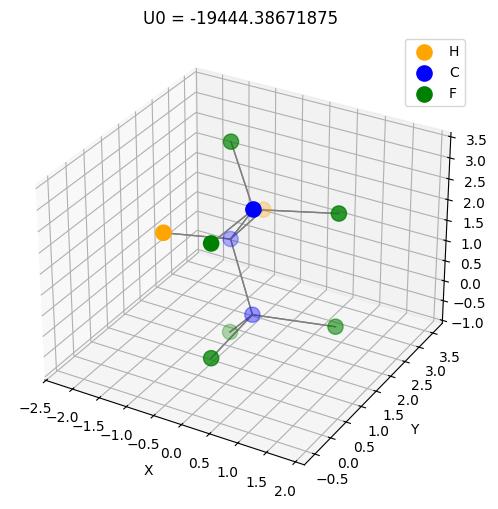

In [ ]:
test_data = sorted_dataset[-1]

# 0 - max  - stable moleculs like methaneunstable moleculs
# -1 - min  - big unstable moleculs
# U0 - is negative !!!

plot_molecule(
    pos=test_data.pos,
    z=test_data.z,
    edge_index=test_data.edge_index,
    title=f"{target_name} = {test_data.y[-1, target_idx]}"
)

In [ ]:
target_name = "mu"
target_idx = QM9_TARGETS[target_name]

values = []
for i, data in enumerate(dataset):
    values.append((i, data.y[0, target_idx].item()))

sorted_indices = [i for i, _ in sorted(values, key=lambda x: x[1], reverse=True)]
sorted_dataset = Subset(dataset, sorted_indices)

tensor(29.5564)


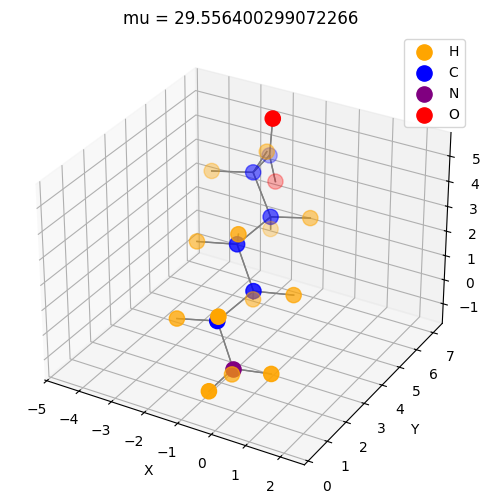

In [ ]:
test_data = sorted_dataset[0]

# 0 - max mu - nonsimmetric dipole molecule

print(test_data.y[0, target_idx])

plot_molecule(
    pos=test_data.pos,
    z=test_data.z,
    edge_index=test_data.edge_index,
    title=f"{target_name} = {test_data.y[-1, target_idx]}"
)

tensor(0.)


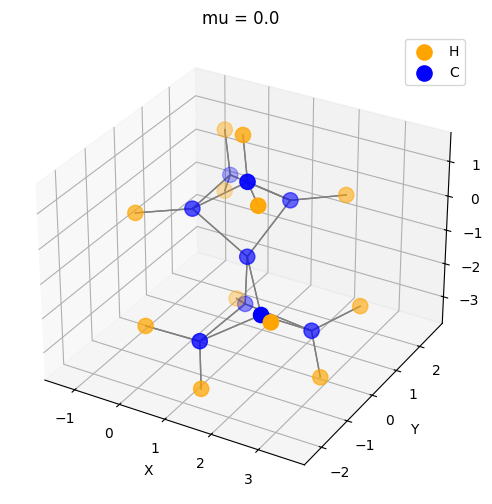

In [ ]:
test_data = sorted_dataset[-1]

# -1 - min mu - simmetric molecule

print(test_data.y[-1, target_idx])

plot_molecule(
    pos=test_data.pos,
    z=test_data.z,
    edge_index=test_data.edge_index,
    title=f"{target_name} = {test_data.y[-1, target_idx]}"
)

In [ ]:
target_name = "gap"
target_idx = QM9_TARGETS[target_name]

values = []
for i, data in enumerate(dataset):
    values.append((i, data.y[0, target_idx].item()))

sorted_indices = [i for i, _ in sorted(values, key=lambda x: x[1], reverse=True)]
sorted_dataset = Subset(dataset, sorted_indices)

tensor(16.9282)


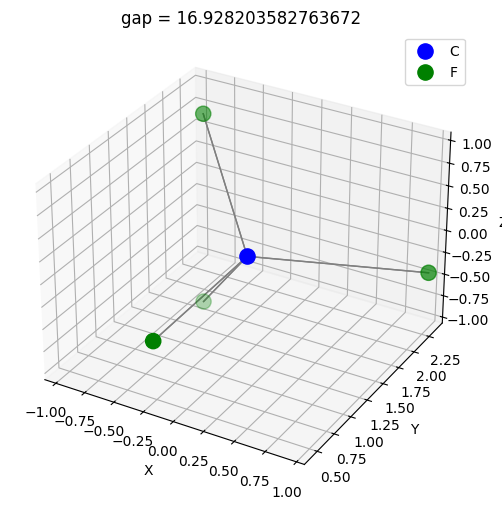

In [ ]:
test_data = sorted_dataset[0]

# 0 - max gap - stable molecule

print(test_data.y[0, target_idx])

plot_molecule(
    pos=test_data.pos,
    z=test_data.z,
    edge_index=test_data.edge_index,
    title=f"{target_name} = {test_data.y[-1, target_idx]}"
)

tensor(0.6694)


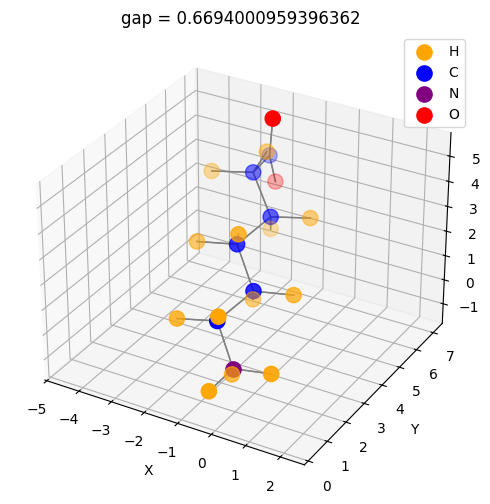

In [ ]:
test_data = sorted_dataset[-1]

# -1 - min gap - unstable molecule

print(test_data.y[0, target_idx])

plot_molecule(
    pos=test_data.pos,
    z=test_data.z,
    edge_index=test_data.edge_index,
    title=f"{target_name} = {test_data.y[-1, target_idx]}"
)

In [ ]:
dataset[49317].idx

tensor([50481])

mol idx = 49317
U0 = -11779.5517578125
mu = 3.3673999309539795
gap = 5.172884464263916
tensor([[0., 0., 0., 1., 0., 8., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 6., 0., 0., 0., 0., 1.],
        [0., 1., 0., 0., 0., 6., 0., 0., 0., 0., 1.],
        [0., 1., 0., 0., 0., 6., 0., 0., 0., 0., 2.],
        [0., 0., 1., 0., 0., 7., 0., 0., 0., 0., 1.],
        [0., 1., 0., 0., 0., 6., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 7., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 6., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 7., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]])


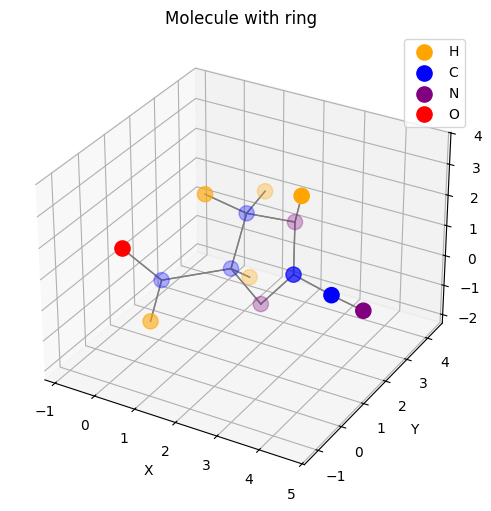

In [ ]:
# example with 1 aroma ring
test_data = dataset[49317]
print(f'mol idx = {test_data.idx}')
print(f"{'U0'} = {test_data.y[-1, QM9_TARGETS['U0']]}")
print(f"{'mu'} = {test_data.y[-1, QM9_TARGETS['mu']]}")
print(f"{'gap'} = {test_data.y[-1, QM9_TARGETS['gap']]}")
print(test_data.x)

plot_molecule(
    pos=test_data.pos,
    z=test_data.z,
    edge_index=test_data.edge_index,
    title="Molecule with ring"
)

# Baseline models

**Инвариантность** - изменение input не приводит к изменению output: f(Rx)≈f(x)

**Эквивариантность** - изменение input приводит к предсказуемому изменению output: f(Rx)≈Rf(x)

**Special Euclidean group in 3D  ( *SE(3)* )** -- f(Rx+t) -- группа симметрий, включающая вращение и сдвиг (rotation and translation) в 3D пространстве. Работает с наборами координат точек (3D Point Clouds), графами.

------------------------------------

***Архитектуры, выбранные в качестве Baseline models:***

**Fully Connected Neural Network (FCNN)** - полносвязная нейронная сеть. В ней нет Geometric Inductive Biases и нет Structural bias. Мы будем пользоваться очень упрощенным вариантом FCNN, который делает предсказания только на основании поданных координат **data.pos**. Этот baseline позволит изучить, как линейные слои справляются с геометрическим обучением (вращением), узнают о топологии.

**Graph Convolutional Network (GCN)** - permutation-equivariant without geometry - архитектура для обучения на граф-структурированных данных (graph structured data). Это расширение применения свертки с сеточных данных (grid-based data - например, изображения) до неевклидовых графов, позволяя агрегировать информацию из локального окружения узла (Message-passing). Messages у GCN зависят только от связности графа (adjacency matrix) и характеристик узлов (QM9 - атомное число, количество и тип химическх связей. Но мы возьмем **только data.z**). Message-passing игнорирует 3D координаты (data.pos) --> тривиальный тест на вращение = применение вращения к input не влияет на output. Нет Geometric Inductive Biases, но есть Structural bias (графы). https://arxiv.org/abs/1704.01212

**Distance-based Graph Neural Network (DistanceGNN)** -  rotation & translation invariant -- чуть более мощная, чем GCN, архитектура, которая использует в Message-passing и расстояния между атомами в молекулах (+Geometric bias (distances only) -- Radial basis function (RBF) - неприрывное представление расстояний (хорошо для обучения, но информация об углах теряется)). Кроме того, т.к. эксперименты проводятся в среде Collab, то не получилось запустить базовую архитектуру GNN (конволюционные слои + RBF-слой). Чтобы обучение стало возможномым, пришлось убрать конволюционные слои. Модель обучается используя информацию о расстояниях (**data.pos** --> d расстояния) и типе атомов (**data.z**).

**Equivariant Graph Neural Network (EGNN)** - full SE(3) equivariance - модель с эквиваринтностью к геоментрическим преобразованиям (rotations, translations, reflections) в 3D пространстве (вращение input - это вращение координат). При вращении молекулы, вращаются связанные с ней координаты. Для обучения модель использует: data.z, расстояния d (как и DistanceGNN) + ветора *xi-xj*. Это очень широкие возможности по сравнению с другими baseline, но среда Collab не позволяет использовать их в полной мере. Пришлось сильно сократить hidden_dim, число ближайших соседей и num_layers. Размер батча был катострофически уменьшен до 1. Но чтобы тренировать модели на одном размере батча мы воспользовались технологией batch accumulation для симмуляции большего размера батча. Опытным путем подобрали размер тренировочного датасета, при котором Collab справляется с нагрузкой - 15000 молекул.

Таким образом, основное сравнение результатов будет проводиться по результатам обучения на тренировочном датасете с размером 15к. Валидационные и тестовые датасеты - 1.5к. Поскольку это очень маленькие размеры, то результаты могут быть сильно зашумлены и зависеть от выбранных наборов молекул. Чтобы примерно оценить вклад этой ошибки, мы проведем обучение на тренировочных наборах 10к, 15к и по возможности 104к. Сделаем несколько запусков обучения на трех разных наборах train-valid, проведем тестирование на нескольких тестовых наборах и выведем усредненные результаты. В анализе основной упор будет сделан не на количественные результаты, а на общие тенденции и закономерности.

In [13]:
# MODEL_NAMES = ('FCNN', 'GCN', 'DistanceGNN', 'EGNN')

model_description = {}

model_description["Model name"] = ['FCNN', 'GCN', 'DistanceGNN', 'EGNN']
model_description["Geometry"] = ['X', 'X', 'distances', '3D coord']
model_description["Inductive bias"] = ['No bias', 'topology bias', 'd=∥x𝑖−x𝑗∥', 'x𝑖−x𝑗 and ∥x𝑖−x𝑗∥']
model_description["Symmetry"] = ['X', 'permutation, trivial SE(3)', 'SE(3) invariance', 'SE(3) equivariance']
model_description["takes from QM9"] = ['data.pos', 'data.z', 'data.pos, data.z', 'data.pos, data.z']
model_description["model input"] = ['N, 3D coord', 'N, z, edge_idx', 'N, z, edge_idx, d', 'N, z, 3D coord']

df_model_description = pd.DataFrame.from_dict(model_description)

In [14]:
df_model_description

Model name   Geometry     Inductive bias                    Symmetry  \
0         FCNN          X            No bias                           X   
1          GCN          X      topology bias  permutation, trivial SE(3)   
2  DistanceGNN  distances          d=∥x𝑖−x𝑗∥            SE(3) invariance   
3         EGNN   3D coord  x𝑖−x𝑗 and ∥x𝑖−x𝑗∥          SE(3) equivariance   

     takes from QM9        model input  
0          data.pos        N, 3D coord  
1            data.z     N, z, edge_idx  
2  data.pos, data.z  N, z, edge_idx, d  
3  data.pos, data.z     N, z, 3D coord

---------------------------------------------

# -- **Необученные модели.** Test SE(3) equivariance on an untrained model

Цель эксперимента: показать, что FCNN output меняется при вращении, а EGNN output - нет (точнее, координаты на выходе автоматически повернутся при повороте координат на входе). Мы возьмем одну молекулу (метан). Будем вращать её много раз (random rotations 𝑅∈𝑆𝑂(3)) - получим датасет из одной молекулы, но в разных положениях. Подадим этот датасет в необученные модели (для этого простейшего случая возьмем модели, содерждащие 1 слой) - после каждого вращения сохраним предсказание - получим дисперсию (variance) по data.pos (тут хранятся координаты). Проверим EGNN на эквивариантность координат.

In [ ]:
# We take one fixed molecule and apply random rotations

# We measure how much the model’s output changes

# data = dataset[0]
data = data.to(device) # 'cpu'

In [ ]:
# Define a minimal FCNN (non-geometric)

# This model:
#   flattens coordinates
#   has no idea what rotation is

# import torch.nn as nn

class minFCNN(nn.Module):
    def __init__(self, num_nodes=MAX_ATOMS, hidden_dim=128):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(num_nodes * 3, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)
        )

    def forward(self, pos):
        x = pos.view(1, -1)  # flatten
        return self.net(x)

In [ ]:
# Initialize
num_nodes = data.pos.shape[0]
fcnn = minFCNN(num_nodes)
fcnn.eval()

FCNN(
  (net): Sequential(
    (0): Linear(in_features=15, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=1, bias=True)
  )
)

In [ ]:
# FCNN rotation test. Expected output: A clearly non-zero variance.

fcnn_outputs = []

with torch.no_grad():
    for _ in range(50):
        R = random_rotation_matrix()
        pos_rot = data.pos @ R
        out = fcnn(pos_rot)
        fcnn_outputs.append(out.item())

fcnn_outputs = torch.tensor(fcnn_outputs)
print("FCNN output variance:", fcnn_outputs.var().item())

FCNN output variance: 0.012519102543592453


Мы импортируем EGNN от lucidrains, инициализируем модель только с node feature dimension (в нашем случае EGNN = one equivariant message-passing layer). Т.к. тестируем только геоментрию, то создадим фиктивные фичи на базе data.pos. Если заглянуть на гитхаб https://github.com/lucidrains/egnn-pytorch, то видно, что ожидает forward(self, feats, coors, edges = None, mask = None, adj_mat = None). Из примеров использования понятно, что feats.shape = (batch, num_nodes, feature_dim) и coors.shape = (batch, num_nodes, 3) - т.е. на входе ожидается батч, что требует дополнительной предобработки перед подачей данных на вход (у нас 1 молекула).

In [ ]:
# Define a minimal EGNN (untrained) --> Define ONE EGNN layer

# We’ll use lucidrains’ EGNN, but without training.

from egnn_pytorch import EGNN

egnn = EGNN(
    dim=1,            # node feature dimension
    edge_dim=0,       # no edge features
    m_dim=32,         # message dimension
    update_coors=True # enables equivariant coordinate updates
)

egnn.eval()

EGNN(
  (edge_mlp): Sequential(
    (0): Linear(in_features=3, out_features=6, bias=True)
    (1): Identity()
    (2): SiLU()
    (3): Linear(in_features=6, out_features=32, bias=True)
    (4): SiLU()
  )
  (node_norm): Identity()
  (coors_norm): Identity()
  (node_mlp): Sequential(
    (0): Linear(in_features=33, out_features=2, bias=True)
    (1): Identity()
    (2): SiLU()
    (3): Linear(in_features=2, out_features=1, bias=True)
  )
  (coors_mlp): Sequential(
    (0): Linear(in_features=32, out_features=128, bias=True)
    (1): Identity()
    (2): SiLU()
    (3): Linear(in_features=128, out_features=1, bias=True)
  )
)

In [ ]:
# We need dummy node features, since we’re testing geometry only:

num_nodes = data.pos.shape[0]
h = torch.ones((num_nodes, 1))

# EGNN expects batched input
#   feats must have shape (batch, num_nodes, feature_dim)
#   coors must have shape (batch, num_nodes, 3)

# Add batch dimension
h_batched   = h.unsqueeze(0)          # (1, N, 1)
pos_batched = data.pos.unsqueeze(0)   # (1, N, 3)

In [ ]:
# Output invariance test. Expected output: EGNN output variance: ~1e-12 --- Small numerical noise only.

egnn_outputs = []

with torch.no_grad():
    for _ in range(50):
        R = random_rotation_matrix()
        pos_rot = (data.pos @ R).unsqueeze(0)

        # h_out   -- node_out    h_out.shape == (1, N, 1)
        # pos_out -- coors_out   pos_out.shape == (1, N, 3)

        h_out, pos_out = egnn(
            h_batched,
            pos_rot,
            edges=None
        )

        # Update pooling accordingly. Since we added a batch dimension:
        pooled = h_out.sum(dim=1)   # sum over nodes (pool by sum to get a scalar)
        scalar = pooled.squeeze()
        egnn_outputs.append(scalar.item())

egnn_outputs = torch.tensor(egnn_outputs)
print("EGNN output variance:", egnn_outputs.var().item())

EGNN output variance: 2.3201395232125277e-13


In [ ]:
# Coordinate equivariance test (also batched). Expected: very small number < (~1e-6)
# ==> The coordinate update rule is SE(3)-equivariant up to numerical precision.

# This tests: f(Rx)≈Rf(x)

with torch.no_grad():
    R = random_rotation_matrix()

    h1, pos1 = egnn(h_batched, pos_batched, edges=None)
    h2, pos2 = egnn(h_batched, (data.pos @ R).unsqueeze(0), edges=None)

    pos1_rot = pos1 @ R
    error = torch.norm(pos1_rot - pos2)

print("EGNN сoordinate equivariance error:", error.item())

EGNN сoordinate equivariance error: 1.5840151945667458e-07


Мы получили очевидно не нулевую дисперсию (variance) для FCNN, т.е. при изменении input меняется и output --> отсутствие инвариантности к вращению. Для EGNN получили незначительную дисперсию при вращениях (~1e-12), а обновленные координаты удовлетворяют условию эквивариантности с точностью, превышающей заданную в датасете для координат (см.пример координат в части изучения датасета data.pos). Это подтверждает, что вращательная симметрия EGNN обеспечивается архитектурно, а не является результатом обучения.

# -- Обученные модели

Т.к. работа проводится в среде Colab - вычислительные ресурсы сильно ограничены. Нет возможности обучать EGNN на полном датасете и больших батчах. Чтобы сравнивать результаты, нужно обучать сети на одном и том же наборе данных и одинаковом размере батча. Поскольку целью является провести грубое сравнение, иллюстрирующее идею GDL, то будем пользоваться минимальными версиями моделей нейросетей. Для каждого таргета (U0, mu) сеть обучается отдельно.

Forward модеей имеет разный тип *input*:

FCNN input = tensor (B, N, 3)

PyG models input = Data object

EGNN input = (feats, coors, mask)

Обучение и тесты отличаются для tensor-based и graph-based моделей из-за различий в способе представления данных.

Для GCN, DistarnceGNN и FCNN используем rotation test на MSE по изменению координат. Для FCNN ожидаем большую ошибку. GCN -- MSE=0, т.к. координаты не подаются на вход. DistanceMSE - исчезающе маленькую ошибку.

EGNN - координаты вращаются вместе с молекулой. В тесте мы просто посмотрим на разницу в координатах: предсказанные повёрнутые координаты output минус повернутые координаты input.

Для каждого таргета обучение проводится независимо. Все модели обучаются на одних и тех же наборах данных (y_mean и y_std для тестовых наборов берутся из соответсвующих тренировочных наборов для заданного таргета). В качестве метрики берем MSE loss.

Поскольку для работы мы можем взять только маленький датасет, то следует посмотреть, как это скажется на качестве обучения. Как кривые обучения будут зависеть от набора данных. Для каждого таргета будем делать попытки обучения на тренировочных наборах разного размера и состава. Для этих наборов предварительно посчитаем y_mean, y_std (нужны для нормировки). Результат обучения оценим на разных тестовых наборах (к каждому тестовому набору применяются y_mean, y_std, на которых модель тренировалась).

Обучение на полном наборе сделано для FCNN, GCN и DistanceGNN, чтобы посмотреть, как сказалось уменьшиение размера датасета на обучении.

Обучение занимает много времени. Collab часто перезапускает сессию. Поэтому, чтобы обучить все модели на одном и том же наборе, нужно сделать предопределенным разделение Train/val/test split. В библиотечной функции random_split нет аргумента random_state, но есть возможность использовать генератор (для него есть ф-ция manual_seed(seed)).

In [278]:
# create determenistic dataset split (reproducibility concern)

from torch.utils.data import random_split

def deterministic_split(dataset, lengths, seed=42):
    g = torch.Generator(device=device) # default device='cuda'
    # manual_seed(seed) -- Sets the seed for generating random numbers. Returns a torch.Generator object.
    g.manual_seed(seed)
    return random_split(dataset, lengths, generator=g)

In [279]:
# n - number of experiments for every target

def data_set_maker(data_set, size, n=3):
  return [data_set[size*i : size*(i+1)] for i in range(n)]

In [280]:
def experiment_data_splitter(data_split, train_size, val_size, n=3):
  output = {}
  output['train'] = data_set_maker(data_split[0], train_size, n)
  output['val'] = data_set_maker(data_split[1], val_size, n)
  return output

Для каждого таргета и эксперимента отдельно высчитываются среднее и дисперсия по соответствующему train набору. Для столь маленьких наборов (10k-15k) значения отличаются уже в 3ей значащей цифре.

In [281]:
# for normalization

# target_idx = QM9_TARGETS['U0']
# target_idx = QM9_TARGETS['mu']

def compute_target_stats(dataset, target_idx):
    ys = []
    for data in dataset:
        ys.append(data.y[0, target_idx])
    ys = torch.stack(ys)
    return ys.mean(), ys.std()

In [282]:
def plot_experiments_loss(loss_dict, max_cols=3, figsize=(15, 4)):
    """
    Plot train/val loss curves for multiple experiments.

    Args:
        loss_dict: dict
            { "experiment": (train_losses, val_losses), ... }
        max_cols: int
            Max plots per row
        figsize: tuple
            Figure size per row
    """

    n_exp = len(loss_dict)
    n_cols = min(max_cols, n_exp)
    n_rows = (n_exp + n_cols - 1) // n_cols

    fig, axes = plt.subplots(
        n_rows, n_cols,
        figsize=(figsize[0], figsize[1] * n_rows),
        sharey=True
    )

    # Flatten axes to 1D list
    axes = np.atleast_1d(axes).ravel()

    for ax, (name, (train_loss, val_loss)) in zip(axes, loss_dict.items()):
        ax.plot(train_loss, label="Train", linewidth=2)
        ax.plot(val_loss, label="Val", linewidth=2)
        ax.set_title(name)
        ax.set_xlabel("Epoch_idx")
        ax.set_ylabel("MSE")
        ax.grid(alpha=0.3)
        ax.legend()

    # Hide unused subplots
    for ax in axes[len(loss_dict):]:
        ax.axis("off")

    plt.tight_layout()
    plt.show()

In [283]:
####################### SAVE and LOAD functions for checkpoints and results

In [284]:
def load_if_exists(
    model,
    optimizer,
    ckpt_dir,
    # device="cpu",
    experiment_no
):
    last_path = os.path.join(ckpt_dir, f"last{experiment_no}.pt")
    meta_path = os.path.join(ckpt_dir, f"meta{experiment_no}.json")

    if not os.path.exists(last_path):
        print("No checkpoint found — starting fresh")
        return 0, float("inf"), [], []

    ckpt = torch.load(last_path, map_location=device)
    model.load_state_dict(ckpt["model_state"])
    optimizer.load_state_dict(ckpt["optimizer_state"])

    with open(meta_path, "r") as f:
        meta = json.load(f)

    print(f"Resuming from epoch {meta['epoch']} | best_val = {meta['best_val']:.4f}")
    return meta["epoch"], meta["best_val"], meta["train_losses_list"], meta["val_losses_list"]

In [285]:
def load_json_if_exists(ckpt_dir, file_name):
    results_path = os.path.join(ckpt_dir, file_name)

    print(results_path)

    if not os.path.exists(results_path):
        print(f"{results_path}  not found !!!")
        return {}

    with open(results_path, "r") as f:
        results = json.load(f)

    return results

In [286]:
def save_checkpoint(
    model,
    optimizer,
    epoch,
    val_loss,
    train_losses,
    val_losses,
    ckpt_dir,
    experiment_no
):
    os.makedirs(ckpt_dir, exist_ok=True)

    # Always save last
    torch.save({
        "model_state": model.state_dict(),
        "optimizer_state": optimizer.state_dict(),
    }, os.path.join(ckpt_dir, f"last{experiment_no}.pt"))

    # Save metadata
    meta = {
        "epoch": epoch,
        "best_val": val_loss,
        "train_losses_list": train_losses,
        "val_losses_list": val_losses,
    }
    with open(os.path.join(ckpt_dir, f"meta{experiment_no}.json"), "w") as f:
        json.dump(meta, f)

    print(f"💾 Saved new checkpoint. Epoch start idx = {epoch}")

In [287]:
def save_best(model, ckpt_dir, target_name, experiment_no):
    torch.save(
        model.state_dict(),
        os.path.join(ckpt_dir, f"best{model.name}_{target_name}_ex{experiment_no}.pt")
    )
    print(f"*** New best model saved in best{model.name}_{target_name}_ex{experiment_no}.pt")

In [288]:
def save_dict_to_json(
    dir_name,
    file_name,
    results_dict
):
    os.makedirs(dir_name, exist_ok=True)

    file_path = os.path.join(dir_name, file_name)

    with open(file_path, "w") as f:
        json.dump(results_dict, f)

    print(f"💾 Dict of results Saved in {file_path} ")

In [289]:
# def load_checkpoint(model, model_name, target_name, experiment_no, train_size):

#   ckpt_dir = f"/content/{model_name}_{target_name}_checkpoint_{train_size//1000}k"
#   file_name = f'best{model_name}_{target_name}_ex{experiment_no}.pt'

#   if os.path.exists(os.path.join(os.getcwd(), ckpt_dir, file_name)):
#     ckpt = torch.load(os.path.join(os.getcwd(), ckpt_dir, file_name))
#   else:
#     print(f'Load checkpoint file {ckpt}!!! File do not exist !!!')

#   best_model = model()
#   best_model.load_state_dict(ckpt)
#   best_model.to(device)

#   return best_model

In [290]:
def load_best_model_of_experiment(model_init, model_name, target_name, experiment_no, train_size):

    ckpt_dir = f"/content/{model_name}_{target_name}_checkpoint_{train_size//1000}k"
    file_name = f'best{model_name}_{target_name}_ex{experiment_no}.pt'
    if os.path.exists(os.path.join(os.getcwd(), ckpt_dir, file_name)):
      ckpt = torch.load(os.path.join(os.getcwd(), ckpt_dir, file_name))
    else:
      print(f'Load checkpoint file {file_name}!!! File do not exist !!!')
      print(f'ckpt_dir = {ckpt_dir}')

    best_model = model_init()
    best_model.load_state_dict(ckpt)
    best_model.to(device)

    return best_model

In [291]:
################ get test MSE, test ROTATION

In [292]:
# ROTATION

def test_rot_experiment(model, model_name, target_name,
                        experiment_no, rot_test_func,
                        test_loader, train_size,
                        ckpt_dir, file_name):

  print(f'experiment_no = {experiment_no}')

  best_model = load_best_model_of_experiment(model, model_name, target_name, experiment_no, train_size)

  criterion = torch.nn.MSELoss()

  if best_model.name == 'EGNN':
    test_loader = next(iter(test_loader))
    feats, coors, mask, y = test_loader # batch

  rot_result = rot_test_func(best_model, test_loader)
  print(f'{best_model.name}. {target_name}. Rotation test result = {rot_result}')

  return rot_result

In [293]:
# tests MSE

def test_experiment(model, model_name,
                    target_name, experiment_no,
                    mse_test, test_loaders,
                    train_size, ckpt_dir, stats=None):

  print(f'experiment_no = {experiment_no}')

  test_losses = []
  results_dict = {}

  best_model = load_best_model_of_experiment(model, model_name, target_name, experiment_no, train_size)
  criterion = torch.nn.MSELoss()

  params = None

  if stats:
      target_idx = QM9_TARGETS[target_name]
      experiment_stats = stats[target_idx][experiment_no-1] # y_mean, y_std
      params = (target_idx, experiment_stats[0], experiment_stats[1])

  for i in range(len(test_loaders)):
    print(f'test loader idx = {i}')

    test_loader = test_loaders[i] # to call collite

    test_loss = mse_test(test_loader, best_model, criterion, params)
    print(f'{best_model.name}. {target_name} test_loss = {test_loss:.4f}')
    test_losses.append(test_loss)

  results_dict['test_losses'] = test_losses

  res_file_name = f'mse_results_{best_model.name}_{target_name}_ex{experiment_no}.json'

  save_dict_to_json(ckpt_dir, res_file_name, results_dict)

In [294]:
# tests MSE

def test_target(model, model_name, target_name,
                test_funcs, test_loaders, train_size, ckpt_dir, stats=None, n=3):
  print(f'target_name = {target_name}')

  for experiment_no in range(1, n+1):

    # ex2, ex3 do not exists for train_size 104k
    file_name = f'best{model_name}_{target_name}_ex{experiment_no}.pt'

    if os.path.exists(os.path.join(os.getcwd(), ckpt_dir, file_name)):
      test_experiment(model, model_name,
                      target_name, experiment_no,
                      test_funcs, test_loaders,
                      train_size, ckpt_dir, stats)

In [295]:
# tests MSE

def test_model(target_names, train_size, model, model_name, test_funcs, model_test_loaders, stats=None, n=3):
  print(f'model name = {model_name}')
  print(f'train_size = {train_size//1000}k')

  for target_name in target_names:

    target_test_loaders = model_test_loaders[target_name] #
    ckpt_dir = f"/content/{model_name}_{target_name}_checkpoint_{train_size//1000}k"

    # train_size 104k folder do not exists for EGNN
    if os.path.isdir(ckpt_dir):
      test_loaders = model_test_loaders[target_name]

      test_target(model, model_name, target_name,
                  test_funcs,
                  test_loaders,
                  train_size,
                  ckpt_dir,
                  stats, n)

In [296]:
# TABLE for test MSE

def get_data_for_losses_table(model_name, target_name, train_sizes, n=3):
  print('get_data_for_losses_table(model_name, target_name, train_sizes, n=3)')
  results_dict = {}

  size_list = []
  ex_no_list = []
  test_mse_list = []
  mean_std_list = []
  test_baseline_mse_list = []

  model_target_size_dict = {}


  for train_size in train_sizes:

    ckpt_dir = f"/content/{model_name}_{target_name}_checkpoint_{train_size//1000}k"

    # train_size 104k folder do not exists for EGNN
    if os.path.isdir(ckpt_dir):

      losses_by_train_size = []

      for experiment_no in range(1, n+1):
        # /content/FCNN_U0_checkpoint_10k/mse_results_FCNN_U0_ex1.json
        file_name = f"mse_results_{model_name}_{target_name}_ex{experiment_no}.json"

        # "test_losses_list": test_losses,
        test_losses_dict = load_json_if_exists(ckpt_dir, file_name)
        # for 104k and ex2, ex3 --> test_losses_dict = {}
        if test_losses_dict:
          test_losses = test_losses_dict["test_losses"]

          test_losses_str = ", ".join(f"{loss:.2f}" for loss in test_losses[1:])

          losses_by_train_size.append(test_losses[1:])

          # idx=0 - full test set
          mse_mean = np.mean(test_losses[1:])
          mse_std = np.std(test_losses[1:])
          mean_std_str = f'{mse_mean:.2f} +/- {mse_std:.2f}'

          size_list.append(f'{train_size//1000}k')
          ex_no_list.append(f'{experiment_no}')
          test_mse_list.append(test_losses_str)
          mean_std_list.append(mean_std_str)
          test_baseline_mse_list.append(f"{test_losses[0]:.3f}")

      losses_by_train_size_list = np.hstack(np.array(losses_by_train_size))
      mse_mean_by_size = np.mean(losses_by_train_size_list)
      mse_std_by_size = np.std(losses_by_train_size_list)
      mean_std_str_by_size = f'{mse_mean_by_size:.2f} +/- {mse_std_by_size:.2f}'

      model_target_size_dict[f'{train_size//1000}k'] = mean_std_str_by_size

  results_dict['Train size'] = size_list
  results_dict['Experiment no'] = ex_no_list
  results_dict['Test MSE on TEST_SIZE=1500'] = test_mse_list
  results_dict['Test MSE, mean +/- std'] = mean_std_list
  results_dict['Test MSE on full test set (13k)'] = test_baseline_mse_list


  return results_dict, model_target_size_dict

In [297]:
################# TRAIN

In [298]:
def train_experiment(model_init, experiment_loaders,
                     target_name, experiment_no,
                     epoch_funcs,
                     epochs, train_size,
                     stats=None):

  print(f'experiment_no = {experiment_no}')

  results_dict = {}

  train_epoch, eval_epoch = epoch_funcs

  params = None
  best_epoch = 0

  if stats:
    target_idx = QM9_TARGETS[target_name]
    y_mean, y_std = stats[target_idx][experiment_no-1]
    params = (target_idx, y_mean, y_std)

  # model = EGNNModelSafe(hidden_dim=16, num_neighbors=2).to(device)
  model = model_init().to(device)

  optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
  criterion = torch.nn.MSELoss()

  ckpt_dir = f"/content/{model.name}_{target_name}_checkpoint_{train_size//1000}k"
  os.makedirs(ckpt_dir, exist_ok=True)

  # start_epoch, best_val, train_losses, val_losses = 0, float("inf"), [], []
  start_epoch, best_val, train_losses, val_losses = load_if_exists(
    model, optimizer, ckpt_dir, experiment_no)

  train_loader = experiment_loaders[0]
  val_loader = experiment_loaders[1]

  for epoch in range(start_epoch, epochs):

      train_loss = train_epoch(train_loader, model, optimizer, criterion, params)
      val_loss = eval_epoch(val_loader, model, criterion, params)

      train_losses.append(train_loss)
      val_losses.append(val_loss)

      if val_loss < best_val:
          best_val = val_loss
          save_best(model, ckpt_dir, target_name, experiment_no)

      if (epoch+5)%5 == 0 or (epoch+1)==epochs:
        print(f"Epoch {(epoch):03d} | Train MSE: {train_loss:.4f} | Val MSE: {val_loss:.4f}")

  res_file_name = f'results_{model.name}_{target_name}_ex{experiment_no}.json'
  results_dict['train_losses_list'] = train_losses
  results_dict['val_losses_list'] = val_losses

  plt.figure(figsize=(5, 3))
  plt.plot(np.arange(epochs), train_losses, label=f'train_losses')
  plt.plot(np.arange(epochs), val_losses, label=f'val_losses')
  plt.title(f'experiment_no = {experiment_no}. {model.name}. {target_name} MSE loss')
  plt.legend(loc='best')
  plt.xlabel("Epoch_idx")
  plt.ylabel("MSE")
  plt.show()
  plt.close() # mandatory inside loops or reusable functions

  if start_epoch != epochs:

    save_dict_to_json(ckpt_dir, res_file_name, results_dict)

    save_checkpoint(
          model, optimizer, epochs, val_loss, train_losses, val_losses, ckpt_dir, experiment_no
      )
  else:
    print(f'start_epoch = epochs = {start_epoch} ==> NO new checkpoint to save.')

  return

In [299]:
def train_target(model_name, model_init,
                  target_loaders,
                  target_name,
                  epoch_funcs,
                  epochs, train_size,
                 stats=None):

  print(f'target_name = {target_name}')

  for experiment_no in range(1, len(target_loaders)+1):

    experiment_loaders = target_loaders[experiment_no - 1]

    train_experiment(model_init, experiment_loaders,
                      target_name, experiment_no,
                      epoch_funcs,
                      epochs, train_size, stats)

In [300]:
def train_model(model_name, model_init,
                all_loaders,
                target_names,
                epoch_funcs,
                epochs, train_size, stats=None
                ):

  print(f'model name = {model_name}')

  for target_name in target_names:

    target_loaders = all_loaders[target_name]

    train_target(model_name, model_init,
                  target_loaders,
                  target_name,
                  epoch_funcs,
                  epochs, train_size, stats)


In [301]:
##################  LOADERS

In [302]:
# test loaders
# y_mean, y_std, target_name, collate_func
def get_test_loaders(test_set, params = None):

  loaders = []
  n = len(test_set)//TEST_SIZE

  if params:

    experiment_stats, target_name, collate_func = params
    y_mean, y_std = experiment_stats
    collate_fn = collate_func(y_mean, y_std, QM9_TARGETS[target_name])
    assert collate_fn is not None

    test_loader = DataLoader(
        test_set,
        batch_size=BATCH_SIZE,
        # shuffle=True,
        shuffle=False,
        collate_fn=collate_fn
    )

    loaders.append(test_loader)

    [loaders.append(DataLoader(
          test_set[TEST_SIZE*i : TEST_SIZE*(i+1)],
          batch_size=BATCH_SIZE,
          shuffle=False,
          collate_fn=collate_fn
      )) for i in range(n)]

  else:

    test_loader = geometric_DataLoader(test_set, batch_size=BATCH_SIZE) # , shuffle=True
    loaders.append(test_loader)

    [loaders.append(geometric_DataLoader(
          test_set[TEST_SIZE*i : TEST_SIZE*(i+1)],
          batch_size=BATCH_SIZE,
      )) for i in range(n)]

  print(f'len test_loaders in experiment = {len(loaders)}')

  return loaders

In [303]:
# test loaders

def get_model_test_loaders(test_set, target_names, params=None, n=3):
  loaders = {}

  for target_name in target_names:
    print(f'target_name = {target_name}')

    # train y_mean, y_std applied to experiment_test_loader

    for i in range(n):
      if params:
        stats, collate_func = params
        target_stats = stats[QM9_TARGETS[target_name]]

        for j in range(len(target_stats)):
          args = (target_stats[j],
                  target_name,
                  collate_func)
          loaders[target_name] = get_test_loaders(test_set, args)
      else:
        loaders[target_name] = get_test_loaders(test_set)

  return loaders

In [304]:
# train loader

def get_experiment_loaders(dataset_split, params = None):

  train_set, val_set = dataset_split
  loaders = []

  if params:

    target_stats, target_name, collate_func = params
    y_mean, y_std = target_stats

    collate_fn = collate_func(y_mean, y_std, QM9_TARGETS[target_name])
    assert collate_fn is not None

    train_loader = DataLoader(
        train_set,
        batch_size=BATCH_SIZE,
        # shuffle=True,
        shuffle=False,
        collate_fn=collate_fn
    )

    loaders.append(train_loader)

    val_loader = DataLoader(
        val_set,
        batch_size=BATCH_SIZE,
        shuffle=False,
        collate_fn=collate_fn
    )
    loaders.append(val_loader)

  else:

    train_loader = geometric_DataLoader(train_set, batch_size=BATCH_SIZE) # , shuffle=True
    loaders.append(train_loader)

    val_loader = geometric_DataLoader(val_set, batch_size=BATCH_SIZE)
    loaders.append(val_loader)

  print(f'len loaders in experiment (1*train + 1*val) = {len(loaders)}')

  return loaders

In [305]:
# train loader

def get_target_loaders(data_dict, params=None):

  loaders = []

  for i in range(len(data_dict['val'])):

    dataset_split = (data_dict['train'][i], data_dict['val'][i])

    if params:
      target_name, target_stats, collate_func = params
      args = (target_stats[i]), target_name, collate_func
      target_loaders = get_experiment_loaders(dataset_split, args)
      loaders.append(target_loaders)
    else:
      target_loaders = get_experiment_loaders(dataset_split)
      loaders.append(target_loaders)

  print(f'len of loaders for target = {len(loaders)} (number of experiments)')

  return loaders

In [306]:
# train loader

def get_model_loaders(data_dict, target_names, params=None):

  loaders = {}

  for target_name in target_names:
    print(f'target_name = {target_name}')
    if params:
      stats, collate_func = params
      args = target_name, stats[QM9_TARGETS[target_name]], collate_func
      loaders[target_name] = get_target_loaders(data_dict, args)
    else:
      loaders[target_name] = get_target_loaders(data_dict)

  print(f'len of model loaders = {len(loaders)} ( number of targets)')

  return loaders

In [307]:
########### GEOMERTY ABLATION and BETTI NUMBERS

In [308]:
# BETTI NUMBERS are measure of geometry-sensitive complexity

# Compute β₁ for one molecule
# ripser() expects one point cloud (no bonds, no graph, just geometry)

# Vietoris–Rips - Connect everything that is mutually close (connect points whose distance ≤ ε)
# --> This is not a chemical graph, bonds are not used - Everything is inferred from distances only

# Instead of choosing one ε, ripser sweeps: ε = 0 → ∞
# At each ε: build VR(ε)
# track topological features as they:
        # appear (birth)
        # disappear (death)

# Persistance diagram
      # H₀	connected components
      # H₁	loops / rings

# Each diagram is an array of shape: [num_features, 2], where each row is: [birth, death]
                                                        # birth → loop appears
                                                        # death → loop filled in by triangles

# persistence = H1[:, 1] - H1[:, 0]
          # short-lived cycles → noise
          # long-lived cycles → meaningful topology

# β₁:
  # not exactly chemical rings
  # not graph cycles
  # a geometric/topological complexity measure

def compute_beta1(coords, persistence_threshold=0.2):
    """
    coords: np.ndarray [N, 3]  (single molecule!)
    returns: beta1 (int)
    """

    # Minimum loop in VR requires ≥ 4 points
    if coords.shape[0] < 4:
        return 0  # no 1-cycles possible

    # VR filtration: Computes H₀ and H₁ persistence
    # Uses optimized union–find + matrix reduction (Ripser algorithm)
    result = ripser(coords, maxdim=1) # maxdim=1 <-- H2+ ignored
    H1 = result["dgms"][1]  # H1 persistence diagram

    # No loops case
    if len(H1) == 0:
        return 0

    # Persistence filtering: Count loops that survive longer than ε = persistence_threshold
    persistence = H1[:, 1] - H1[:, 0]
    return int((persistence > persistence_threshold).sum())

Для FCNN / EGNN функции compute_beta1(coords, persistence_threshold) достаточно, β₁ коррелирует с числом колец. Но в случае GCN / DistanceGNN получается корреляция с числом атомов. Для графовых моделей см.функцию для получения чисел Бетти в разделе Graph based (PyG).

In [309]:
# ΔError - Reflects relative degradation due to geometry removal

# Spearman’s rank correlation (ρ)
# it measures Monotonic relationship between two variables.
    # Do higher β₁ values tend to correspond to higher Error, ΔError?
    # Does geometry sensitivity increase as topology gets more complex?

# ρ value	Meaning
    # +1.0	perfect increasing monotonic relation
    #  0.0	no monotonic relation
    # −1.0	perfect decreasing monotonic relation

#-------

# p-value (statistical significance)
    # Small p → unlikely to be random
    # Large p → could easily be noise

# Typical thresholds:
    # p < 0.05 → statistically significant
    # p < 0.01 → strongly significant

def plot_delta_error_vs_beta(beta, delta_err, title, xlabel, ylabel):
    plt.figure(figsize=(5, 4))
    plt.scatter(beta, delta_err, alpha=0.7)
    plt.axhline(0, color="gray", linestyle="--", linewidth=1)

    plt.xlabel(xlabel)
    plt.ylabel(ylabel) # r"$\Delta$ Error (ablated − full)"
    plt.title(title)

    if len(np.unique(beta)) > 2:
        rho, p = spearmanr(beta, delta_err)
        plt.text(
            0.05, 0.95,
            f"Spearman ρ = {rho:.2f}\np = {p:.2e}",
            transform=plt.gca().transAxes,
            va="top"
        )

    plt.tight_layout()
    plt.show()

In [310]:
def mann_whitney_test(model_name,
                      loader_idx,
                      target_name,
                      betas_list,
                      errs_list):
  print(f'{model_name} {target_name} test_loader_{loader_idx}')
  print()

  target_idx = QM9_TARGETS[target_name]

  low_mask = betas_list <= 0  # <= 0 -- for graph lvl
  high_mask = betas_list >= 1

  errors_low = errs_list[low_mask]
  errors_high = errs_list[high_mask]

  print(f"Low β₁ samples: {len(errors_low)}")
  print(f"High β₁ samples: {len(errors_high)}")
  print()

  u_stat, p_value = mannwhitneyu(
    errors_low,
    errors_high,
    alternative="two-sided"
    )

  print(f"Mann–Whitney U = {u_stat:.2f}")
  print(f"p-value = {p_value:.4e}")
  print()
  print('----------------------------')

  if p_value < 0.001:
    return 'p < 0.001 → very strong evidence'
  elif p_value < 0.01:
    return 'p < 0.01 → strong evidence'
  elif p_value < 0.05:
    return 'p < 0.05 → statistically significant'
  else:
    return 'indistinguishable groups'

---------------------------------------------------

# = Baseline 1 — FCNN (no inductive bias)

In [50]:
# Baseline 1 — FCNN (no inductive bias)

# Show what happens when geometry is ignored?

# FCNN sees
#   Absolute coordinates
#   Fixed atom ordering
#   No permutation, rotation, or translation invariance

# Input
#   Flattened coordinates (N × 3)

# Architecture
# Flatten → Linear → ReLU → Linear → ReLU → Output

# Expected behavior
#   Sensitive to rotations
#   Poor generalization

class FCNN(torch.nn.Module):
    def __init__(self, num_nodes=MAX_ATOMS, hidden_dim=256):
        super().__init__()

        self.name = 'FCNN'

        self.net = torch.nn.Sequential(
            torch.nn.Linear(num_nodes * 3, hidden_dim),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_dim, hidden_dim),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_dim, 1)
        )

    def forward(self, pos):
        x = pos.view(pos.size(0), -1)  # (batch, N*3)
        return self.net(x)

In [51]:
# Training loop

def train_epoch_fcnn(loader, model, optimizer, criterion, params=None):
    model.train()
    total_loss = 0

    for pos, y, idx in loader:
        pos, y, idx = pos.to(device), y.to(device), idx.to(device)

        optimizer.zero_grad()
        pred = model(pos)
        loss = criterion(pred, y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * pos.size(0)

    return total_loss / len(loader.dataset)

In [52]:
# Validation loop

@torch.no_grad()
def eval_epoch_fcnn(loader, model, criterion, params=None):
    model.eval()
    total_loss = 0

    for pos, y, idx in loader:
        pos, y, idx = pos.to(device), y.to(device), idx.to(device)
        pred = model(pos)
        loss = criterion(pred, y)
        total_loss += loss.item() * pos.size(0)

    return total_loss / len(loader.dataset)

In [53]:
# FCNN. Rotation must affect predictions
# This test measures positions MSE

def rotation_invariance_test_fcnn(model, loader, n_batches=10):
    model.eval()
    diffs = []

    with torch.no_grad():
        for i, (pos, y, idx) in enumerate(loader):
            if i >= n_batches:
                break

            pos = pos.to(device)
            y = y.to(device)

            pred1 = model(pos)

            R = random_rotation_matrix().to(device)
            pos_rot = pos @ R.T

            pred2 = model(pos_rot)

            diff = torch.mean((pred1 - pred2) ** 2)
            diffs.append(diff.item())

    return sum(diffs) / len(diffs)

Согласно документации https://docs.pytorch.org/docs/stable/data.html#dataloader-collate-fn при отключении automatic batching - dataset обрабатывается путем индивидуального сэмплирования (Each sample obtained from the dataset is processed with the function passed as the collate_fn argument). Если не определить collate_fn, то будет использоваться default_collate(batch), где batch это list из сэмплов. Проблема в том, что Each QM9 item is a Data object --> data.pos → (num_atoms_i, 3) Но! num_atoms_i зависит от молекулы (разный для разных молекул). --> torch.stack ломается, т.к. стакает элементы разных размеров. Поэтому есть необходимость переписать стандартное батчирование под батч не из списка сэмплов, а списка объектов данных QM9. Кастомная функция fcnn_collate должна принимать батч объектов и возвращать батч-тензор описания молекул и батч-таргеты (индексы).

In [54]:
# Dataset preparation (QM9 → fixed-size tensors)

# QM9 molecules have variable number of atoms, but FCNN needs fixed-size input.

# QM9 max atoms = 29

# We will:
#   pad positions to (29, 3)
#   mask unused atoms (implicitly via zeros)

def make_fcnn_collate(y_mean, y_std, target_idx):
    def collate(batch):
        pos_list = []
        y_list = []
        idx_list = []

        for data in batch:
            n = data.pos.shape[0]

            pos = torch.zeros((MAX_ATOMS, 3))
            pos[:n] = data.pos

            y = (data.y[0, target_idx] - y_mean) / y_std

            pos_list.append(pos)
            y_list.append(y)
            idx_list.append(data.idx)

        pos = torch.stack(pos_list)
        y = torch.stack(y_list).unsqueeze(1)
        idx = torch.tensor(idx_list)
        return pos, y, idx

    return collate

In [55]:
def fcnn_ablate_geometry(pos, mode="collapse"):

    assert torch.is_tensor(pos), "FCNN ablation expects torch.Tensor"

    pos_ab = pos.clone()

    B, N, _ = pos.shape

    for b in range(B):
        coords = pos[b]

        # detect valid atoms (non-padding)
        mask = coords.norm(dim=1) > 1e-6
        valid_coords = coords[mask]

        if valid_coords.size(0) == 0:
            continue

        if mode == "collapse":
            center = valid_coords.mean(dim=0, keepdim=True)
            pos_ab[b, mask] = center

        else:
            raise ValueError(f"Unknown ablation mode: {mode}")

    return pos_ab

In [115]:
def collect_fcnn_betti_end_errors(model,
                                  loader,
                                  persistence_threshold=0.2,
                                  ):

    beta1_list = []

    err_full = []
    err_ab = []
    delta_err = []
    idx_list =[]

    model.eval()
    with torch.no_grad():
        for pos, y, idx in loader:
            pos, y, idx = pos.to(device), y.to(device), idx.to(device)

            # ===== full geometry prediction =====
            preds_full = model(pos)
            err = (preds_full - y).abs().cpu().numpy()

            # ===== ablated geometry =====
            pos_ab = fcnn_ablate_geometry(pos, mode="collapse")
            # pos_ab = torch.zeros(MAX_ATOMS, 3)
            # pos: torch.Tensor of shape (B, MAX_ATOMS, 3)
            preds_ab = model(pos_ab)  # (B, 1)

            pos_np = pos.cpu().numpy()   # (B, MAX_ATOMS, 3)

            B = pos_np.shape[0]

            for b in range(B):
                mol_idx = int(idx[b])
                coords = pos_np[b]

                # remove padded atoms
                mask = np.linalg.norm(coords, axis=1) > 1e-6
                coords_valid = coords[mask]

                beta1 = compute_beta1(coords_valid)
                beta1_list.append(beta1)

                # ---- errors ----
                ef = torch.abs(preds_full[b] - y[b]).item()
                ea = torch.abs(preds_ab[b] - y[b]).item()

                err_full.append(ef)
                err_ab.append(ea)
                delta_err.append(ea - ef)
                idx_list.append(mol_idx)

    return (
        np.array(beta1_list),
        # np.array(beta1_geom_ab),
        np.array(err_full),
        np.array(err_ab),
        np.array(delta_err),
        np.array(idx_list),
    )

---------------------------------------------

# =__Graph based (PyG)

Для GCN и Distance-based GNN - общий DataLoader из torch_geometric.loader. Нормировка включена в функции train_epoch и eval_epoch. Поэтому y_mean, y_std текущего train_loader будут автоматически применяться к test_loader.

In [56]:
# Training loop

def train_epoch(loader, model, optimizer, criterion, params):
    target_idx, y_mean, y_std = params
    model.train()
    total_loss = 0

    for data in loader:
        data = data.to(device)

        optimizer.zero_grad()

        pred = model(data)
        y = (data.y[:, target_idx] - y_mean) / y_std
        y = y.unsqueeze(1)

        loss = criterion(pred, y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * data.num_graphs

    return total_loss / len(loader.dataset)

In [57]:
# Evaluation loop

@torch.no_grad()
def eval_epoch(loader, model, criterion, params):
    target_idx, y_mean, y_std = params
    model.eval()
    total_loss = 0

    for data in loader:
        data = data.to(device)
        pred = model(data)
        y = (data.y[:, target_idx] - y_mean) / y_std
        y = y.unsqueeze(1)

        loss = criterion(pred, y)
        total_loss += loss.item() * data.num_graphs

    return total_loss / len(loader.dataset)

In [58]:
# Use MSE for fairness across models.

def rotation_invariance_test(model, loader, n_batches=10):
    model.eval()
    diffs = []

    with torch.no_grad():
        for i, data in enumerate(loader):
            if i >= n_batches:
                break

            data = data.to(device)
            pred1 = model(data)

            R = random_rotation_matrix().to(device)

            data_rot = data.clone()
            data_rot.pos = data.pos @ R.T

            pred2 = model(data_rot)

            diff = torch.mean((pred1 - pred2) ** 2)
            diffs.append(diff.item())

    return sum(diffs) / len(diffs)

In [136]:
def get_graph_target(data, target_idx, y_mean, y_std):
    """
    Returns normalized graph-level target tensor
    with shape [num_graphs, 1].
    """

    y = data.y[:, target_idx]
    batch = data.batch

    # normalize FIRST
    y = (y - y_mean) / y_std
    y = y.unsqueeze(1)

    num_graphs = int(batch.max()) + 1

    # node-level → graph-level
    if y.size(0) != num_graphs:
        y = global_mean_pool(y, batch)

    # hard guards
    assert y.dim() == 2
    assert y.size(0) == num_graphs

    return y

In [137]:
def compute_geom_beta1_batch(data):
    """
    Returns a list of β₁ values, one per graph in batch
    """
    beta_list = []

    edge_index = data.edge_index
    batch = data.batch
    num_graphs = data.num_graphs

    for g in range(num_graphs):
        # nodes belonging to graph g
        node_mask = batch == g
        nodes = node_mask.nonzero(as_tuple=False).view(-1)

        if len(nodes) < 3:
            beta_list.append(0)
            continue

        # remap node indices
        node_id_map = {int(n): i for i, n in enumerate(nodes)}

        # select edges inside graph
        mask = node_mask[edge_index[0]] & node_mask[edge_index[1]]
        edges = edge_index[:, mask]

        if edges.numel() == 0:
            beta_list.append(0)
            continue

        # remap edges
        edges = torch.stack([
            torch.tensor([node_id_map[int(i)] for i in edges[0]]),
            torch.tensor([node_id_map[int(i)] for i in edges[1]])
        ])

        # graph theory: β₁ = E - V + C
        V = len(nodes)
        E = edges.size(1)
        C = 1  # connected component (QM9 molecules)

        beta = max(E - V + C, 0)
        beta_list.append(beta)

    return beta_list

In [138]:
def compute_graph_beta1_batch(data, persistence_threshold=0.2):
    beta_list = []

    pos = data.pos
    batch = data.batch
    num_graphs = data.num_graphs

    for g in range(num_graphs):
        coords = pos[batch == g].cpu().numpy()
        beta = compute_beta1(coords, persistence_threshold)
        beta_list.append(beta)

    return beta_list

In [139]:
def collect_error_and_betti(best_model, subset_loader, target_idx, y_mean, y_std):
    beta_graph = []
    beta_geom = []
    err_full_list = []
    err_ab_list = []
    delta_err = []

    best_model.eval()
    with torch.no_grad():
        for data in subset_loader:
            data = data.to(device)
            num_graphs = data.num_graphs

            # ===== Betti numbers PER GRAPH =====
            beta_graph_batch = compute_graph_beta1_batch(data)   # len = num_graphs
            beta_geom_batch  = compute_geom_beta1_batch(data)

            # ===== graph-level target =====
            y_graph = get_graph_target(data, target_idx, y_mean, y_std)  # [num_graphs, 1]

            # ===== full geometry =====
            pred_full = best_model(data)  # [num_graphs, 1]
            err_full = (pred_full - y_graph).abs().mean(dim=1)  # [num_graphs]

            # ===== ablated geometry =====
            data_ab = data.clone()
            data_ab.pos = pg_ablate_geometry(data.pos, mode="shuffle")

            pred_ab = best_model(data_ab)
            err_ab = (pred_ab - y_graph).abs().mean(dim=1)       # [num_graphs]

            # ===== collect PER GRAPH =====
            beta_graph.extend(beta_graph_batch)
            beta_geom.extend(beta_geom_batch)
            err_full_list.extend(err_full.cpu().numpy())
            err_ab_list.extend(err_ab.cpu().numpy())
            delta_err.extend((err_ab - err_full).cpu().numpy())

    return (
        np.array(beta_graph),
        np.array(beta_geom),
        np.array(err_full_list),
        np.array(err_ab_list),
        np.array(delta_err),
    )

In [62]:
def pg_ablate_geometry(coors, mode="collapse"):
    """
    coors: (N, 3)
    """
    if mode == "collapse":
        return np.zeros_like(coors)

    elif mode == "shuffle":
        idx = np.random.permutation(coors.shape[0])
        return coors[idx]

    else:
        raise ValueError("Unknown ablation mode")

--------------------------------------------------------------

# =__Baseline 2 — GCN permutation only (topology only)

In [63]:
# Baseline 2 — GCN permutation only (topology only)

# Input
#   Node features (atom types)
#   Graph edges

# Architecture
#   GCNConv × 3
#   Global pooling (z)
#   Linear head

# Expected behavior
#   Permutation invariant
#   No rotation awareness
#   Geometry lost entirely

from torch_geometric.nn import GCNConv, global_mean_pool

# GCNConv - The graph convolutional operator based on message passing layer

class GCN(torch.nn.Module):
    def __init__(self, hidden_dim=128):
        super().__init__()

        self.name ='GCN'

        self.embed = torch.nn.Embedding(100, hidden_dim)

        self.conv1 = GCNConv(hidden_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.conv3 = GCNConv(hidden_dim, hidden_dim)

        self.out = torch.nn.Linear(hidden_dim, 1)

    def forward(self, data):
        x = self.embed(data.z)
        edge_index = data.edge_index
        batch = data.batch

        x = torch.relu(self.conv1(x, edge_index))
        x = torch.relu(self.conv2(x, edge_index))
        x = torch.relu(self.conv3(x, edge_index))

        # Returns batch-wise graph-level-outputs by averaging node features across the node dimension.
        x = global_mean_pool(x, batch)

        return self.out(x)

------------------------------------------------

# =__Baseline 3 — Distance-based GNN (invariant geometry)

In [64]:
# Baseline 3 — Distance-based GNN (invariant geometry) -- Minimal custom Distance-GNN

# Test SE(3) invariance without equivariance.

# Input
#   Distances ∥x𝑖−x𝑗∥

# Message function
#   mij​=ϕ(hi​,hj​,dij​)

# Expected behavior
#   Rotation invariant

# Architecture
#   RBFLayer
#   Global pooling (d_RBF, z)
#   Linear head

In [65]:
# Distance embedding (Radial Basis Function - RBF) -
# - learning representations where distances reflect meaningful relationships.

# squared exponential kernel: exp(-gamma * distance**2)

# Distance is expanded into multiple channels -->
# --> Smooth, localized encoding --> Much easier to learn geometry
# (Learns distance-dependent linear operators)

class RBFLayer(torch.nn.Module):
    def __init__(self, num_rbf=16, cutoff=5.0):
        super().__init__()
        centers = torch.linspace(0, cutoff, num_rbf)
        self.register_buffer("centers", centers)
        self.gamma = 10.0

    def forward(self, d):
        return torch.exp(-self.gamma * (d.unsqueeze(-1) - self.centers) ** 2)

In [66]:
# Distance-GNN model

# from torch_geometric.nn import NNConv, global_mean_pool


# class DistanceGNN(torch.nn.Module):
#     def __init__(self, hidden_dim=64, num_rbf=8):
#         super().__init__()

#         self.embed = torch.nn.Embedding(100, hidden_dim)
#         self.rbf = RBFLayer(num_rbf)

#         self.edge_mlp = torch.nn.Sequential(
#             torch.nn.Linear(num_rbf, hidden_dim * hidden_dim),
#             torch.nn.ReLU(),
#             torch.nn.Linear(hidden_dim * hidden_dim, hidden_dim * hidden_dim)
#         )

#         self.conv1 = NNConv(hidden_dim, hidden_dim, self.edge_mlp, aggr='mean')
#         self.conv2 = NNConv(hidden_dim, hidden_dim, self.edge_mlp, aggr='mean')
#         self.conv3 = NNConv(hidden_dim, hidden_dim, self.edge_mlp, aggr='mean')

#         self.out = torch.nn.Linear(hidden_dim, 1)

#     def forward(self, data):
#         x = self.embed(data.z)
#         edge_index = data.edge_index
#         batch = data.batch

#         # Compute distances
#         row, col = edge_index
#         dist = (data.pos[row] - data.pos[col]).norm(dim=1)

#         edge_attr = self.rbf(dist)

#         x = torch.relu(self.conv1(x, edge_index, edge_attr))
#         x = torch.relu(self.conv2(x, edge_index, edge_attr))
#         x = torch.relu(self.conv3(x, edge_index, edge_attr))

#         x = global_mean_pool(x, batch)
#         return self.out(x)

#=======================
# NNConv is expressive, but very memory-hungry. -->
# Reduce the convolution to a scalar edge weight version
# --> avoids the hidden_dim² blowup
# --> This preserves:
      # distance-based geometry
      # rotation invariance
#=======================

from torch_geometric.nn import global_mean_pool

class DistanceGNN(torch.nn.Module):
    def __init__(self, hidden_dim=64, num_rbf=8):
        super().__init__()

        self.name = 'DistanceGNN'

        self.embed = torch.nn.Embedding(100, hidden_dim)
        self.rbf = RBFLayer(num_rbf)

        self.edge_mlp = torch.nn.Sequential(
            torch.nn.Linear(num_rbf, hidden_dim),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_dim, hidden_dim)
        )

        self.node_mlp = torch.nn.Sequential(
            torch.nn.Linear(hidden_dim * 2, hidden_dim),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_dim, hidden_dim)
        )

        self.out = torch.nn.Linear(hidden_dim, 1)

    def forward(self, data):
        x = self.embed(data.z)
        pos = data.pos
        edge_index = data.edge_index
        batch = data.batch

        i, j = edge_index
        d = (pos[i] - pos[j]).norm(dim=1)

        e = self.edge_mlp(self.rbf(d))

        agg = torch.zeros_like(x)
        agg.index_add_(0, i, e)

        x = self.node_mlp(torch.cat([x, agg], dim=1))
        x = global_mean_pool(x, batch)

        return self.out(x)

------------------------------------------------------------

# = Baseline 4 — EGNN

Как и FCNN, EGNN требует дополнение координат нулями, если число атомов в молекуле меньше максимального (MAX_ATOMS) - padded coordinates.

In [67]:
def make_egnn_collate(y_mean, y_std, target_idx):

    def collate(batch):
        B = len(batch)

        feats = torch.zeros(B, MAX_ATOMS, 1)
        coors = torch.zeros(B, MAX_ATOMS, 3)
        mask  = torch.zeros(B, MAX_ATOMS, dtype=torch.bool)
        y     = torch.zeros(B)
        idx   = torch.zeros(B, dtype=torch.long)

        for i, data in enumerate(batch):
            n = data.num_nodes

            feats[i, :n, 0] = data.z.float()
            coors[i, :n] = data.pos
            mask[i, :n] = True

            y[i] = (data.y[0, target_idx] - y_mean) / y_std
            idx[i] = data.idx

        # safety check (optional but recommended)
        assert idx.unique().numel() == B, "Duplicate idx in batch — dataset identity broken"

        return feats, coors, mask, y.unsqueeze(1), idx

    return collate

https://github.com/lucidrains/egnn-pytorch - EGNN от lucidrains. Чтобы обучение было возможным, возьмем совсем маленькие hidden_dim, num_layers, num_neighbors. Батч = 1. Чтобы сравнивать результаты - симмулируем размер батча = 8 при помощи batch accumulation.

In [68]:
class EGNNModelSafe(nn.Module):
    def __init__(self, hidden_dim=16, num_layers=1, num_neighbors=2):
        super().__init__()

        self.name = 'EGNN'

        self.hidden_dim = hidden_dim

        # Embed scalar atomic number to hidden features
        self.embed = nn.Linear(1, hidden_dim)

        # EGNN block
        self.egnn = EGNN(
            dim=hidden_dim,
            update_coors=True, # enables equivariant coordinate updates
            num_nearest_neighbors=num_neighbors,
            fourier_features=0
        )

        # Graph-level output head
        self.out = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)
        )

    def forward(self, feats, coors, mask):
        """
        feats: (B, N, 1)
        coors: (B, N, 3)
        mask:  (B, N)
        """
        h = self.embed(feats)
        h, _ = self.egnn(h, coors, mask=mask)

        # masked mean pooling
        mask_exp = mask.unsqueeze(-1)       # (B, N, 1)
        h = h * mask_exp
        h = h.sum(dim=1) / mask_exp.sum(dim=1)

        return self.out(h)

In [69]:
from torch.cuda.amp import autocast, GradScaler
scaler = GradScaler()

/tmp/ipython-input-2736003858.py:2: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
/usr/local/lib/python3.12/dist-packages/torch/cuda/amp/grad_scaler.py:31: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  super().__init__(


In [313]:
# +
# EGNN training loop with gradient accumulation
# Key rules
#   Call optimizer.step() only every K batches
#   Scale loss by 1 / accumulation_steps
#   Zero gradients only after optimizer.step()

def train_epoch_egnn(loader, model, optimizer, criterion, params=None, accumulation_steps=8):
    model.train()
    total_loss = 0
    optimizer.zero_grad()

    for i, (feats, coors, mask, y, idx) in enumerate(loader):
        feats, coors, mask, y, idx = (
            feats.to(device),
            coors.to(device),
            mask.to(device),
            y.to(device),
            idx.to(device),
        )

        with autocast():
            pred = model(feats, coors, mask)
            loss = criterion(pred, y) / accumulation_steps

        scaler.scale(loss).backward()

        if (i + 1) % accumulation_steps == 0:
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()
            torch.cuda.empty_cache()

        total_loss += loss.item() * feats.size(0) * accumulation_steps

    return total_loss / len(loader.dataset)

In [71]:
def eval_epoch_egnn(loader, model, criterion, params=None):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for feats, coors, mask, y, idx in loader:
            feats, coors, mask, y, idx = (feats.to(device), coors.to(device),
                                          mask.to(device), y.to(device),
                                          idx.to(device))
            pred = model(feats, coors, mask)
            loss = criterion(pred, y)
            total_loss += loss.item() * feats.size(0)
    return total_loss / len(loader.dataset)

In [72]:
# equivariance test (only for EGNN)

def egnn_equivariance_test(model, batch):
    model.eval()

    feats, coors, mask, _ = batch
    feats = feats.to(device)
    coors = coors.to(device)
    mask = mask.to(device)

    R = random_rotation_matrix().to(device)

    with torch.no_grad():
        _, coors1 = model.egnn(model.embed(feats), coors, mask=mask)
        _, coors2 = model.egnn(model.embed(feats), coors @ R.T, mask=mask)

    diff = (coors2 - coors1 @ R.T)[mask].norm(dim=1).mean()
    return diff.item()

In [73]:
def collect_egnn_betti_and_errors(
    model,
    loader,
    persistence_threshold=0.2,
):
    beta1_geom = []
    beta1_geom_ab = []

    err_full = []
    err_ab = []
    delta_err = []
    idx_list =[]

    model.eval()

    with torch.no_grad():
        for feats, coors, mask, y, idx in loader:
            feats = feats.to(device)
            coors = coors.to(device)
            mask = mask.to(device)
            y = y.to(device)
            idx = idx.to(device)

            B = feats.size(0)

            # ===== full geometry prediction =====
            preds_full = model(feats, coors, mask)  # (B, 1)

            # ===== ablated geometry =====
            coors_ab = torch.zeros(B, MAX_ATOMS, 3)
            preds_ab = model(feats, coors_ab, mask)  # (B, 1)

            for b in range(B):
                valid = mask[b].bool()

                mol_idx = int(idx[b])

                # ---- coordinates ----
                coords = coors[b, valid].cpu().numpy()
                coords_ab = coors_ab[b, valid].cpu().numpy()

                # ---- Betti numbers ----
                beta1_geom.append(
                    compute_beta1(coords, persistence_threshold)
                )
                beta1_geom_ab.append(
                    compute_beta1(coords_ab, persistence_threshold)
                )

                # ---- errors ----
                ef = torch.abs(preds_full[b] - y[b]).item()
                ea = torch.abs(preds_ab[b] - y[b]).item()

                err_full.append(ef)
                err_ab.append(ea)
                delta_err.append(ea - ef)
                idx_list.append(mol_idx)

    return (
        np.array(beta1_geom),
        np.array(beta1_geom_ab),
        np.array(err_full),
        np.array(err_ab),
        np.array(delta_err),
        np.array(idx_list),
    )

# RUN Section

In [79]:
# load checkpoints and best_model state dicts. To get test results - run functions in test sections

!unzip -q /content/Checkpoints.zip

In [75]:
# +
# globals

BATCH_SIZE = 8

VAL_SIZE = 1500
TEST_SIZE = 1500

EPOCHS = 50

TARGET_NAMES = ('U0', 'mu')
MODEL_NAMES = ('FCNN', 'GCN', 'DistanceGNN', 'EGNN')
MODELS = (FCNN, GCN, DistanceGNN, EGNNModelSafe)
TRAIN_SIZES = (10000, 15000, 104000)

In [76]:
# Train/val/test split

train_len = int(0.8 * len(dataset))
val_len = int(0.1 * len(dataset))
test_len = len(dataset) - train_len - val_len

train_set, val_set, test_set = deterministic_split(
    dataset,
    [train_len, val_len, test_len],
    seed=42
)

len(train_set), len(val_set), len(test_set)

(104664, 13083, 13084)

In [77]:
data_dict_10k = experiment_data_splitter((train_set, val_set), 10000, VAL_SIZE)
print(data_dict_10k)

data_dict_15k = experiment_data_splitter((train_set, val_set), 15000, VAL_SIZE)
print(data_dict_15k)

# data_dict_104k - no need.
# train_set, val_set - used in get_experiment_loaders
# train_experiment for training on 104k -- full training size

{'train': [QM9WithIndex(10000), QM9WithIndex(10000), QM9WithIndex(10000)], 'val': [QM9WithIndex(1500), QM9WithIndex(1500), QM9WithIndex(1500)]}
{'train': [QM9WithIndex(15000), QM9WithIndex(15000), QM9WithIndex(15000)], 'val': [QM9WithIndex(1500), QM9WithIndex(1500), QM9WithIndex(1500)]}


In [78]:
stats_10k, stats_15k, stats_104k = {}, {}, {}

for target_idx in [QM9_TARGETS['U0'], QM9_TARGETS['mu']]:

  stats_10k[target_idx] = [compute_target_stats(data, target_idx) for data in data_dict_10k['train']]
  stats_15k[target_idx] = [compute_target_stats(data, target_idx) for data in data_dict_15k['train']]

  stats_104k[target_idx] = [compute_target_stats(train_set, target_idx)]

# ___train FCNN

In [210]:
# init

model_name = "FCNN"
model = FCNN

In [211]:
# stats_104k[target_idx] - is list
# to get mean, std --> stats_104k[target_idx][exp_idx]  --- exp_idx = experiment_no-1

stats_104k

{7: [(tensor(-11180.2764), tensor(1085.7927))],
 0: [(tensor(2.6738), tensor(1.5057))]}

In [212]:
############ 104k
model_name = "FCNN"
model = FCNN
target_name = 'mu'

params = stats_104k[QM9_TARGETS[target_name]][0], target_name, make_fcnn_collate
dataset_split = (train_set, val_set)
fcnn_loaders = get_experiment_loaders(dataset_split, params)

len loaders in experiment (1*train + 1*val) = 2


experiment_no = 1
Resuming from epoch 40 | best_val = 0.4419


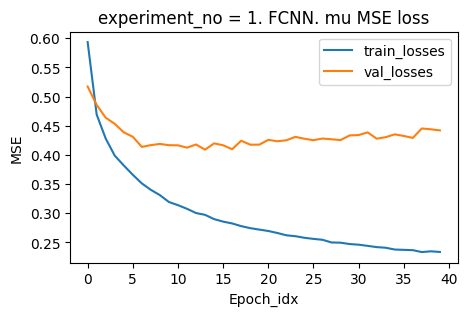

start_epoch = epochs = 40 ==> NO new checkpoint to save.


In [213]:
experiment_no = 1

train_size = len(train_set)

epoch_funcs = (train_epoch_fcnn, eval_epoch_fcnn)

train_experiment(model, fcnn_loaders,
                     target_name, experiment_no,
                     epoch_funcs,
                     40, train_size,
                     )

In [214]:
############ 104k
model_name = "FCNN"
model = FCNN
target_name = 'U0'

params = stats_104k[QM9_TARGETS[target_name]][0], target_name, make_fcnn_collate
dataset_split = (train_set, val_set)
fcnn_loaders = get_experiment_loaders(dataset_split, params)

len loaders in experiment (1*train + 1*val) = 2


experiment_no = 1
Resuming from epoch 40 | best_val = 0.3232


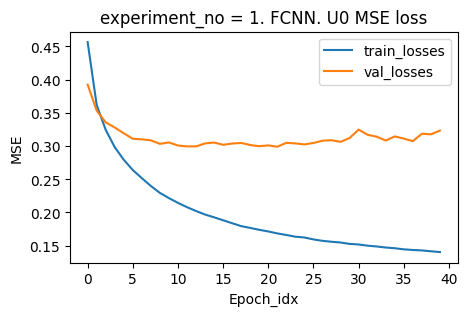

start_epoch = epochs = 40 ==> NO new checkpoint to save.


In [215]:
experiment_no = 1

train_size = len(train_set)

epoch_funcs = (train_epoch_fcnn, eval_epoch_fcnn)

train_experiment(model, fcnn_loaders,
                     target_name, experiment_no,
                     epoch_funcs,
                     40, train_size,
                     )

In [216]:
############# 10k ++
model_name = "FCNN"
model = FCNN

params_10k = stats_10k, make_fcnn_collate
fcnn_model_loaders_10k = get_model_loaders(data_dict_10k, TARGET_NAMES, params_10k)

target_name = U0
len loaders in experiment (1*train + 1*val) = 2
len loaders in experiment (1*train + 1*val) = 2
len loaders in experiment (1*train + 1*val) = 2
len of loaders for target = 3 (number of experiments)
target_name = mu
len loaders in experiment (1*train + 1*val) = 2
len loaders in experiment (1*train + 1*val) = 2
len loaders in experiment (1*train + 1*val) = 2
len of loaders for target = 3 (number of experiments)
len of model loaders = 2 ( number of targets)


model name = FCNN
target_name = U0
experiment_no = 1
🆕 No checkpoint found — starting fresh
⭐ New best model saved in bestFCNN_U0_ex1.pt
Epoch 000 | Train MSE: 0.6344 | Val MSE: 0.5870
⭐ New best model saved in bestFCNN_U0_ex1.pt
⭐ New best model saved in bestFCNN_U0_ex1.pt
⭐ New best model saved in bestFCNN_U0_ex1.pt
⭐ New best model saved in bestFCNN_U0_ex1.pt
⭐ New best model saved in bestFCNN_U0_ex1.pt
Epoch 005 | Train MSE: 0.2905 | Val MSE: 0.4986
Epoch 010 | Train MSE: 0.1727 | Val MSE: 0.5675
Epoch 015 | Train MSE: 0.1201 | Val MSE: 0.5646
Epoch 020 | Train MSE: 0.0893 | Val MSE: 0.5701
Epoch 025 | Train MSE: 0.0763 | Val MSE: 0.5508
Epoch 030 | Train MSE: 0.0669 | Val MSE: 0.5544
Epoch 035 | Train MSE: 0.0581 | Val MSE: 0.5405
Epoch 040 | Train MSE: 0.0518 | Val MSE: 0.5255
Epoch 045 | Train MSE: 0.0465 | Val MSE: 0.5309
Epoch 049 | Train MSE: 0.0420 | Val MSE: 0.5181


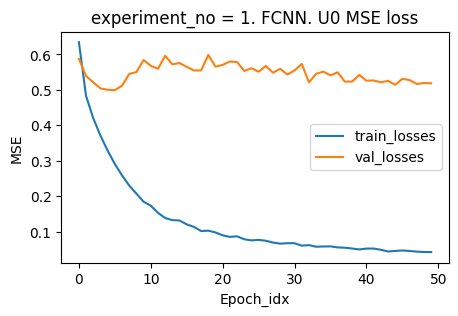

💾 Dict of results Saved in /content/FCNN_U0_checkpoint_10k/results_FCNN_U0_ex1.json 
💾 Saved new checkpoint. Epoch start idx = 50
experiment_no = 2
🆕 No checkpoint found — starting fresh
⭐ New best model saved in bestFCNN_U0_ex2.pt
Epoch 000 | Train MSE: 0.6471 | Val MSE: 0.5349
⭐ New best model saved in bestFCNN_U0_ex2.pt
⭐ New best model saved in bestFCNN_U0_ex2.pt
⭐ New best model saved in bestFCNN_U0_ex2.pt
Epoch 005 | Train MSE: 0.2962 | Val MSE: 0.5005
Epoch 010 | Train MSE: 0.1726 | Val MSE: 0.5042
Epoch 015 | Train MSE: 0.1177 | Val MSE: 0.5173
Epoch 020 | Train MSE: 0.0942 | Val MSE: 0.5404
Epoch 025 | Train MSE: 0.0725 | Val MSE: 0.5247
Epoch 030 | Train MSE: 0.0629 | Val MSE: 0.5003
Epoch 035 | Train MSE: 0.0530 | Val MSE: 0.5145
Epoch 040 | Train MSE: 0.0490 | Val MSE: 0.5036
Epoch 045 | Train MSE: 0.0469 | Val MSE: 0.4885
Epoch 049 | Train MSE: 0.0443 | Val MSE: 0.5001


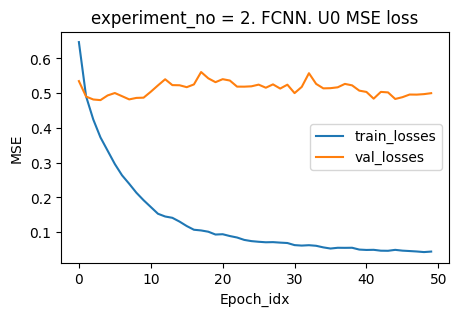

💾 Dict of results Saved in /content/FCNN_U0_checkpoint_10k/results_FCNN_U0_ex2.json 
💾 Saved new checkpoint. Epoch start idx = 50
experiment_no = 3
🆕 No checkpoint found — starting fresh
⭐ New best model saved in bestFCNN_U0_ex3.pt
Epoch 000 | Train MSE: 0.6350 | Val MSE: 0.5755
⭐ New best model saved in bestFCNN_U0_ex3.pt
⭐ New best model saved in bestFCNN_U0_ex3.pt
⭐ New best model saved in bestFCNN_U0_ex3.pt
⭐ New best model saved in bestFCNN_U0_ex3.pt
⭐ New best model saved in bestFCNN_U0_ex3.pt
Epoch 005 | Train MSE: 0.2910 | Val MSE: 0.4621
Epoch 010 | Train MSE: 0.1720 | Val MSE: 0.4956
Epoch 015 | Train MSE: 0.1184 | Val MSE: 0.4970
Epoch 020 | Train MSE: 0.0887 | Val MSE: 0.5070
Epoch 025 | Train MSE: 0.0755 | Val MSE: 0.4730
Epoch 030 | Train MSE: 0.0625 | Val MSE: 0.4886
Epoch 035 | Train MSE: 0.0593 | Val MSE: 0.4766
Epoch 040 | Train MSE: 0.0498 | Val MSE: 0.4701
Epoch 045 | Train MSE: 0.0452 | Val MSE: 0.4694
⭐ New best model saved in bestFCNN_U0_ex3.pt
Epoch 049 | Train 

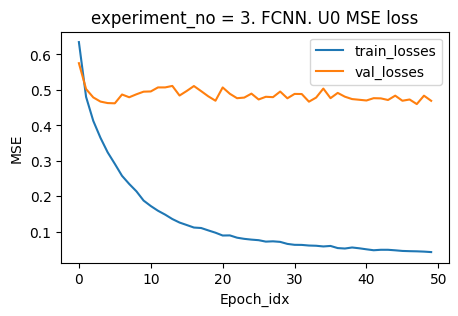

💾 Dict of results Saved in /content/FCNN_U0_checkpoint_10k/results_FCNN_U0_ex3.json 
💾 Saved new checkpoint. Epoch start idx = 50
target_name = mu
experiment_no = 1
🆕 No checkpoint found — starting fresh
⭐ New best model saved in bestFCNN_mu_ex1.pt
Epoch 000 | Train MSE: 0.8008 | Val MSE: 0.7714
⭐ New best model saved in bestFCNN_mu_ex1.pt
⭐ New best model saved in bestFCNN_mu_ex1.pt
⭐ New best model saved in bestFCNN_mu_ex1.pt
⭐ New best model saved in bestFCNN_mu_ex1.pt
Epoch 005 | Train MSE: 0.4077 | Val MSE: 0.6241
Epoch 010 | Train MSE: 0.2419 | Val MSE: 0.6824
Epoch 015 | Train MSE: 0.1645 | Val MSE: 0.7229
Epoch 020 | Train MSE: 0.1346 | Val MSE: 0.7231
Epoch 025 | Train MSE: 0.1047 | Val MSE: 0.6827
Epoch 030 | Train MSE: 0.0951 | Val MSE: 0.7086
Epoch 035 | Train MSE: 0.0774 | Val MSE: 0.7101
Epoch 040 | Train MSE: 0.0660 | Val MSE: 0.7062
Epoch 045 | Train MSE: 0.0657 | Val MSE: 0.6579
Epoch 049 | Train MSE: 0.0582 | Val MSE: 0.6625


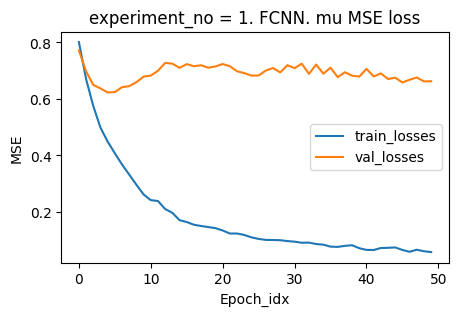

💾 Dict of results Saved in /content/FCNN_mu_checkpoint_10k/results_FCNN_mu_ex1.json 
💾 Saved new checkpoint. Epoch start idx = 50
experiment_no = 2
🆕 No checkpoint found — starting fresh
⭐ New best model saved in bestFCNN_mu_ex2.pt
Epoch 000 | Train MSE: 0.7806 | Val MSE: 0.7088
⭐ New best model saved in bestFCNN_mu_ex2.pt
⭐ New best model saved in bestFCNN_mu_ex2.pt
⭐ New best model saved in bestFCNN_mu_ex2.pt
Epoch 005 | Train MSE: 0.3969 | Val MSE: 0.6200
Epoch 010 | Train MSE: 0.2629 | Val MSE: 0.6715
Epoch 015 | Train MSE: 0.1652 | Val MSE: 0.6776
Epoch 020 | Train MSE: 0.1337 | Val MSE: 0.7129
Epoch 025 | Train MSE: 0.1083 | Val MSE: 0.7124
Epoch 030 | Train MSE: 0.0971 | Val MSE: 0.7074
Epoch 035 | Train MSE: 0.0811 | Val MSE: 0.7096
Epoch 040 | Train MSE: 0.0671 | Val MSE: 0.6959
Epoch 045 | Train MSE: 0.0639 | Val MSE: 0.6773
Epoch 049 | Train MSE: 0.0629 | Val MSE: 0.6983


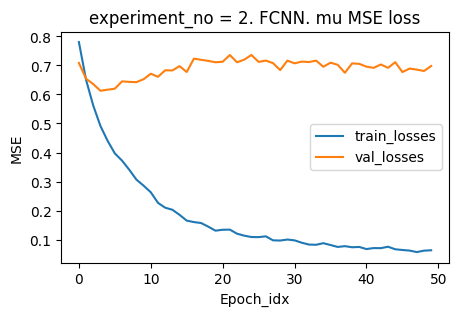

💾 Dict of results Saved in /content/FCNN_mu_checkpoint_10k/results_FCNN_mu_ex2.json 
💾 Saved new checkpoint. Epoch start idx = 50
experiment_no = 3
🆕 No checkpoint found — starting fresh
⭐ New best model saved in bestFCNN_mu_ex3.pt
Epoch 000 | Train MSE: 0.7814 | Val MSE: 0.6534
⭐ New best model saved in bestFCNN_mu_ex3.pt
⭐ New best model saved in bestFCNN_mu_ex3.pt
⭐ New best model saved in bestFCNN_mu_ex3.pt
Epoch 005 | Train MSE: 0.4146 | Val MSE: 0.5824
Epoch 010 | Train MSE: 0.2541 | Val MSE: 0.6297
Epoch 015 | Train MSE: 0.1751 | Val MSE: 0.6624
Epoch 020 | Train MSE: 0.1351 | Val MSE: 0.6495
Epoch 025 | Train MSE: 0.1101 | Val MSE: 0.6336
Epoch 030 | Train MSE: 0.0905 | Val MSE: 0.6549
Epoch 035 | Train MSE: 0.0864 | Val MSE: 0.6355
Epoch 040 | Train MSE: 0.0757 | Val MSE: 0.6486
Epoch 045 | Train MSE: 0.0692 | Val MSE: 0.6320
Epoch 049 | Train MSE: 0.0604 | Val MSE: 0.6277


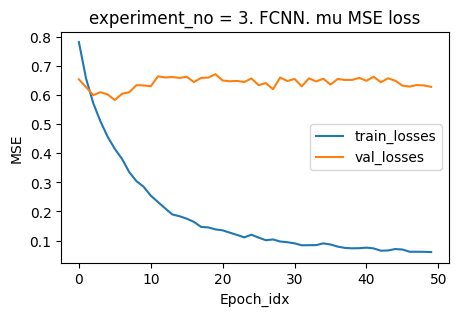

💾 Dict of results Saved in /content/FCNN_mu_checkpoint_10k/results_FCNN_mu_ex3.json 
💾 Saved new checkpoint. Epoch start idx = 50


In [ ]:
# train

# 10k
epoch_funcs = (train_epoch_fcnn, eval_epoch_fcnn)
train_model(model_name, model,
                fcnn_model_loaders_10k,
                TARGET_NAMES,
                epoch_funcs,
                EPOCHS, 10000
                )

In [217]:
############# 15k
params_15k = stats_15k, make_fcnn_collate
fcnn_model_loaders_15k = get_model_loaders(data_dict_15k, TARGET_NAMES, params_15k)

target_name = U0
len loaders in experiment (1*train + 1*val) = 2
len loaders in experiment (1*train + 1*val) = 2
len loaders in experiment (1*train + 1*val) = 2
len of loaders for target = 3 (number of experiments)
target_name = mu
len loaders in experiment (1*train + 1*val) = 2
len loaders in experiment (1*train + 1*val) = 2
len loaders in experiment (1*train + 1*val) = 2
len of loaders for target = 3 (number of experiments)
len of model loaders = 2 ( number of targets)


In [ ]:
# тренировка была проведена на 50 эпохах. сдесь вывод функции - просто проверка, что все еще работает

model name = FCNN
target_name = U0
experiment_no = 1
No checkpoint found — starting fresh
*** New best model saved in bestFCNN_U0_ex1.pt
Epoch 000 | Train MSE: 0.6009 | Val MSE: 0.5262
*** New best model saved in bestFCNN_U0_ex1.pt
Epoch 001 | Train MSE: 0.4606 | Val MSE: 0.5022


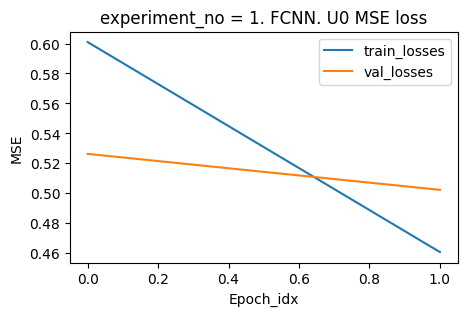

💾 Dict of results Saved in /content/FCNN_U0_checkpoint_15k/results_FCNN_U0_ex1.json 
💾 Saved new checkpoint. Epoch start idx = 2
experiment_no = 2
No checkpoint found — starting fresh
*** New best model saved in bestFCNN_U0_ex2.pt
Epoch 000 | Train MSE: 0.6014 | Val MSE: 0.4988
*** New best model saved in bestFCNN_U0_ex2.pt
Epoch 001 | Train MSE: 0.4674 | Val MSE: 0.4556


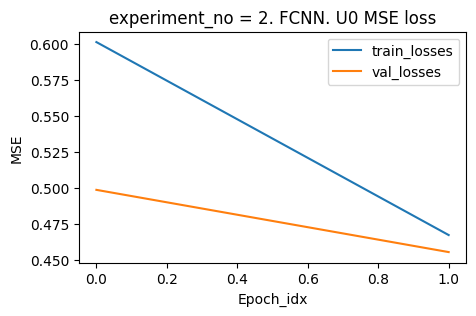

💾 Dict of results Saved in /content/FCNN_U0_checkpoint_15k/results_FCNN_U0_ex2.json 
💾 Saved new checkpoint. Epoch start idx = 2
experiment_no = 3
No checkpoint found — starting fresh
*** New best model saved in bestFCNN_U0_ex3.pt
Epoch 000 | Train MSE: 0.5974 | Val MSE: 0.5675
*** New best model saved in bestFCNN_U0_ex3.pt
Epoch 001 | Train MSE: 0.4600 | Val MSE: 0.5304


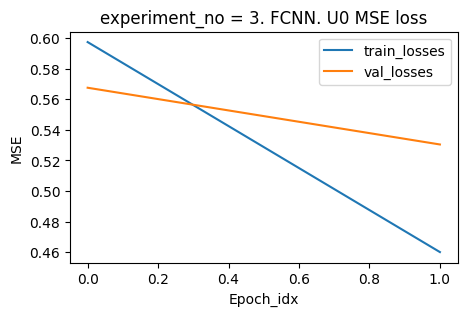

💾 Dict of results Saved in /content/FCNN_U0_checkpoint_15k/results_FCNN_U0_ex3.json 
💾 Saved new checkpoint. Epoch start idx = 2
target_name = mu
experiment_no = 1
No checkpoint found — starting fresh
*** New best model saved in bestFCNN_mu_ex1.pt
Epoch 000 | Train MSE: 0.7662 | Val MSE: 0.6826
*** New best model saved in bestFCNN_mu_ex1.pt
Epoch 001 | Train MSE: 0.6278 | Val MSE: 0.6396


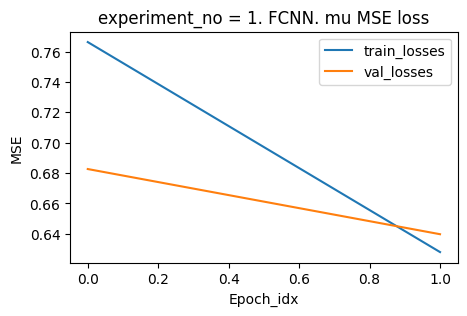

💾 Dict of results Saved in /content/FCNN_mu_checkpoint_15k/results_FCNN_mu_ex1.json 
💾 Saved new checkpoint. Epoch start idx = 2
experiment_no = 2
No checkpoint found — starting fresh
*** New best model saved in bestFCNN_mu_ex2.pt
Epoch 000 | Train MSE: 0.7490 | Val MSE: 0.7387
*** New best model saved in bestFCNN_mu_ex2.pt
Epoch 001 | Train MSE: 0.6136 | Val MSE: 0.6949


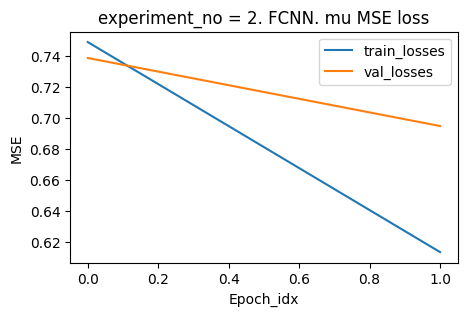

💾 Dict of results Saved in /content/FCNN_mu_checkpoint_15k/results_FCNN_mu_ex2.json 
💾 Saved new checkpoint. Epoch start idx = 2
experiment_no = 3
No checkpoint found — starting fresh
*** New best model saved in bestFCNN_mu_ex3.pt
Epoch 000 | Train MSE: 0.7653 | Val MSE: 0.6124
*** New best model saved in bestFCNN_mu_ex3.pt
Epoch 001 | Train MSE: 0.6157 | Val MSE: 0.5787


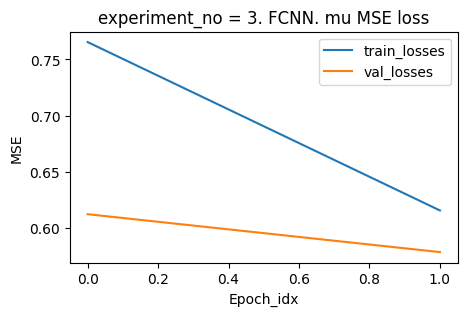

💾 Dict of results Saved in /content/FCNN_mu_checkpoint_15k/results_FCNN_mu_ex3.json 
💾 Saved new checkpoint. Epoch start idx = 2


In [218]:
# train

# 15k
epoch_funcs = (train_epoch_fcnn, eval_epoch_fcnn)
train_model(model_name, model,
                fcnn_model_loaders_15k,
                TARGET_NAMES,
                epoch_funcs,
                2, 15000
                )

# ___train GCN

In [219]:
# init

model_name = "GCN"
model = GCN

In [220]:
gcn_loaders_10k = get_model_loaders(data_dict_10k, TARGET_NAMES)

target_name = U0
len loaders in experiment (1*train + 1*val) = 2
len loaders in experiment (1*train + 1*val) = 2
len loaders in experiment (1*train + 1*val) = 2
len of loaders for target = 3 (number of experiments)
target_name = mu
len loaders in experiment (1*train + 1*val) = 2
len loaders in experiment (1*train + 1*val) = 2
len loaders in experiment (1*train + 1*val) = 2
len of loaders for target = 3 (number of experiments)
len of model loaders = 2 ( number of targets)


model name = GCN
target_name = U0
experiment_no = 1
🔄 Resuming from epoch 5 | best_val = 0.4244
Epoch 005 | Train MSE: 0.3799 | Val MSE: 0.4272
Epoch 010 | Train MSE: 0.3738 | Val MSE: 0.4299
Epoch 015 | Train MSE: 0.3703 | Val MSE: 0.4328
Epoch 020 | Train MSE: 0.3673 | Val MSE: 0.4339
⭐ New best model saved in bestGCN_U0_ex1.pt
Epoch 025 | Train MSE: 0.3660 | Val MSE: 0.4293
Epoch 030 | Train MSE: 0.3640 | Val MSE: 0.4263
⭐ New best model saved in bestGCN_U0_ex1.pt
Epoch 035 | Train MSE: 0.3625 | Val MSE: 0.4224
⭐ New best model saved in bestGCN_U0_ex1.pt
⭐ New best model saved in bestGCN_U0_ex1.pt
Epoch 040 | Train MSE: 0.3607 | Val MSE: 0.4180
⭐ New best model saved in bestGCN_U0_ex1.pt
⭐ New best model saved in bestGCN_U0_ex1.pt
Epoch 045 | Train MSE: 0.3602 | Val MSE: 0.4142
Epoch 049 | Train MSE: 0.3583 | Val MSE: 0.4136


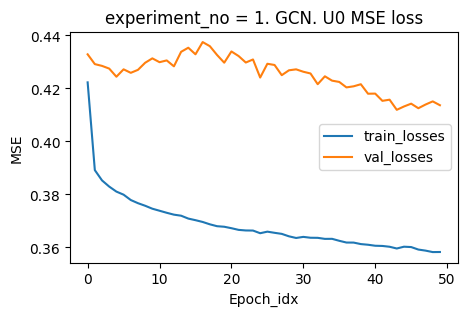

💾 Dict of results Saved in /content/GCN_U0_checkpoint_10k/results_GCN_U0_ex1.json 
💾 Saved new checkpoint. Epoch start idx = 50
experiment_no = 2
🔄 Resuming from epoch 5 | best_val = 0.4156
Epoch 005 | Train MSE: 0.3763 | Val MSE: 0.4187
⭐ New best model saved in bestGCN_U0_ex2.pt
⭐ New best model saved in bestGCN_U0_ex2.pt
⭐ New best model saved in bestGCN_U0_ex2.pt
⭐ New best model saved in bestGCN_U0_ex2.pt
Epoch 010 | Train MSE: 0.3696 | Val MSE: 0.4109
⭐ New best model saved in bestGCN_U0_ex2.pt
⭐ New best model saved in bestGCN_U0_ex2.pt
⭐ New best model saved in bestGCN_U0_ex2.pt
⭐ New best model saved in bestGCN_U0_ex2.pt
Epoch 015 | Train MSE: 0.3668 | Val MSE: 0.4074
⭐ New best model saved in bestGCN_U0_ex2.pt
⭐ New best model saved in bestGCN_U0_ex2.pt
⭐ New best model saved in bestGCN_U0_ex2.pt
⭐ New best model saved in bestGCN_U0_ex2.pt
⭐ New best model saved in bestGCN_U0_ex2.pt
Epoch 020 | Train MSE: 0.3650 | Val MSE: 0.4047
⭐ New best model saved in bestGCN_U0_ex2.pt
Ep

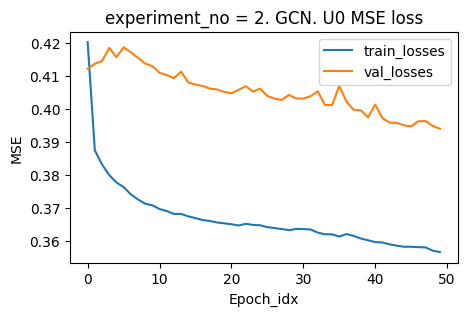

💾 Dict of results Saved in /content/GCN_U0_checkpoint_10k/results_GCN_U0_ex2.json 
💾 Saved new checkpoint. Epoch start idx = 50
experiment_no = 3
🔄 Resuming from epoch 5 | best_val = 0.4281
⭐ New best model saved in bestGCN_U0_ex3.pt
Epoch 005 | Train MSE: 0.3810 | Val MSE: 0.4264
⭐ New best model saved in bestGCN_U0_ex3.pt
⭐ New best model saved in bestGCN_U0_ex3.pt
Epoch 010 | Train MSE: 0.3762 | Val MSE: 0.4252
⭐ New best model saved in bestGCN_U0_ex3.pt
⭐ New best model saved in bestGCN_U0_ex3.pt
⭐ New best model saved in bestGCN_U0_ex3.pt
⭐ New best model saved in bestGCN_U0_ex3.pt
Epoch 015 | Train MSE: 0.3732 | Val MSE: 0.4207
Epoch 020 | Train MSE: 0.3708 | Val MSE: 0.4224
⭐ New best model saved in bestGCN_U0_ex3.pt
⭐ New best model saved in bestGCN_U0_ex3.pt
Epoch 025 | Train MSE: 0.3686 | Val MSE: 0.4187
⭐ New best model saved in bestGCN_U0_ex3.pt
⭐ New best model saved in bestGCN_U0_ex3.pt
⭐ New best model saved in bestGCN_U0_ex3.pt
Epoch 030 | Train MSE: 0.3658 | Val MSE: 0

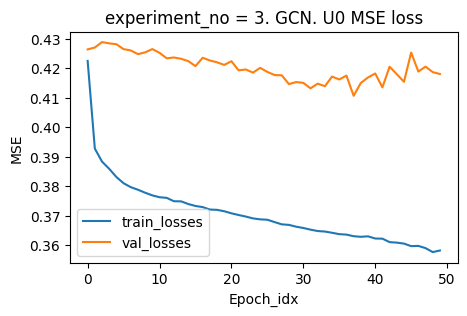

💾 Dict of results Saved in /content/GCN_U0_checkpoint_10k/results_GCN_U0_ex3.json 
💾 Saved new checkpoint. Epoch start idx = 50
target_name = mu
experiment_no = 1
🔄 Resuming from epoch 5 | best_val = 0.6190
⭐ New best model saved in bestGCN_mu_ex1.pt
Epoch 005 | Train MSE: 0.6649 | Val MSE: 0.6032
⭐ New best model saved in bestGCN_mu_ex1.pt
⭐ New best model saved in bestGCN_mu_ex1.pt
⭐ New best model saved in bestGCN_mu_ex1.pt
⭐ New best model saved in bestGCN_mu_ex1.pt
⭐ New best model saved in bestGCN_mu_ex1.pt
Epoch 010 | Train MSE: 0.6196 | Val MSE: 0.5655
⭐ New best model saved in bestGCN_mu_ex1.pt
⭐ New best model saved in bestGCN_mu_ex1.pt
⭐ New best model saved in bestGCN_mu_ex1.pt
⭐ New best model saved in bestGCN_mu_ex1.pt
⭐ New best model saved in bestGCN_mu_ex1.pt
Epoch 015 | Train MSE: 0.5976 | Val MSE: 0.5487
⭐ New best model saved in bestGCN_mu_ex1.pt
⭐ New best model saved in bestGCN_mu_ex1.pt
⭐ New best model saved in bestGCN_mu_ex1.pt
Epoch 020 | Train MSE: 0.5792 | V

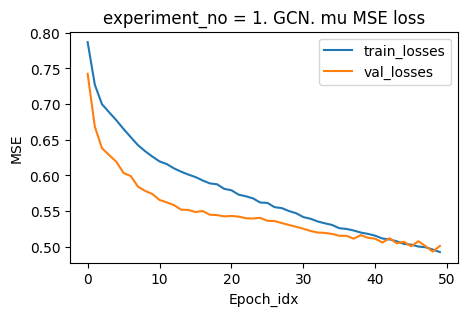

💾 Dict of results Saved in /content/GCN_mu_checkpoint_10k/results_GCN_mu_ex1.json 
💾 Saved new checkpoint. Epoch start idx = 50
experiment_no = 2
🔄 Resuming from epoch 5 | best_val = 0.6209
⭐ New best model saved in bestGCN_mu_ex2.pt
Epoch 005 | Train MSE: 0.6227 | Val MSE: 0.6186
⭐ New best model saved in bestGCN_mu_ex2.pt
⭐ New best model saved in bestGCN_mu_ex2.pt
⭐ New best model saved in bestGCN_mu_ex2.pt
⭐ New best model saved in bestGCN_mu_ex2.pt
⭐ New best model saved in bestGCN_mu_ex2.pt
Epoch 010 | Train MSE: 0.5954 | Val MSE: 0.5994
⭐ New best model saved in bestGCN_mu_ex2.pt
⭐ New best model saved in bestGCN_mu_ex2.pt
⭐ New best model saved in bestGCN_mu_ex2.pt
⭐ New best model saved in bestGCN_mu_ex2.pt
⭐ New best model saved in bestGCN_mu_ex2.pt
Epoch 015 | Train MSE: 0.5782 | Val MSE: 0.5844
⭐ New best model saved in bestGCN_mu_ex2.pt
⭐ New best model saved in bestGCN_mu_ex2.pt
⭐ New best model saved in bestGCN_mu_ex2.pt
⭐ New best model saved in bestGCN_mu_ex2.pt
⭐ New 

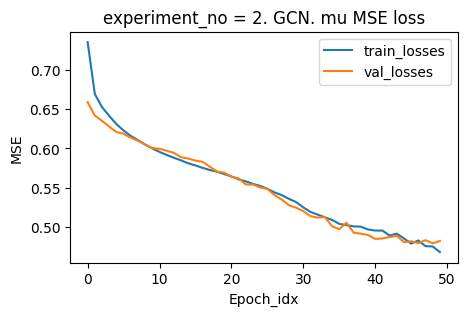

💾 Dict of results Saved in /content/GCN_mu_checkpoint_10k/results_GCN_mu_ex2.json 
💾 Saved new checkpoint. Epoch start idx = 50
experiment_no = 3
🔄 Resuming from epoch 5 | best_val = 0.5863
⭐ New best model saved in bestGCN_mu_ex3.pt
Epoch 005 | Train MSE: 0.6305 | Val MSE: 0.5793
⭐ New best model saved in bestGCN_mu_ex3.pt
⭐ New best model saved in bestGCN_mu_ex3.pt
⭐ New best model saved in bestGCN_mu_ex3.pt
⭐ New best model saved in bestGCN_mu_ex3.pt
⭐ New best model saved in bestGCN_mu_ex3.pt
Epoch 010 | Train MSE: 0.5789 | Val MSE: 0.5488
⭐ New best model saved in bestGCN_mu_ex3.pt
⭐ New best model saved in bestGCN_mu_ex3.pt
⭐ New best model saved in bestGCN_mu_ex3.pt
⭐ New best model saved in bestGCN_mu_ex3.pt
⭐ New best model saved in bestGCN_mu_ex3.pt
Epoch 015 | Train MSE: 0.5540 | Val MSE: 0.5351
⭐ New best model saved in bestGCN_mu_ex3.pt
⭐ New best model saved in bestGCN_mu_ex3.pt
⭐ New best model saved in bestGCN_mu_ex3.pt
⭐ New best model saved in bestGCN_mu_ex3.pt
⭐ New 

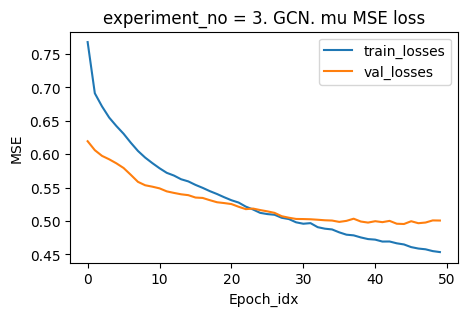

💾 Dict of results Saved in /content/GCN_mu_checkpoint_10k/results_GCN_mu_ex3.json 
💾 Saved new checkpoint. Epoch start idx = 50


In [ ]:
# train ++

# 10k
epoch_funcs = (train_epoch, eval_epoch)
train_model(model_name, model,
                gcn_loaders_10k,
                TARGET_NAMES,
                epoch_funcs,
                EPOCHS, 10000,
                stats_10k
                )

In [ ]:
######################## 15k

In [222]:
gcn_loaders_15k = get_model_loaders(data_dict_15k, TARGET_NAMES)

target_name = U0
len loaders in experiment (1*train + 1*val) = 2
len loaders in experiment (1*train + 1*val) = 2
len loaders in experiment (1*train + 1*val) = 2
len of loaders for target = 3 (number of experiments)
target_name = mu
len loaders in experiment (1*train + 1*val) = 2
len loaders in experiment (1*train + 1*val) = 2
len loaders in experiment (1*train + 1*val) = 2
len of loaders for target = 3 (number of experiments)
len of model loaders = 2 ( number of targets)


model name = GCN
target_name = U0
experiment_no = 1
No checkpoint found — starting fresh
*** New best model saved in bestGCN_U0_ex1.pt
Epoch 000 | Train MSE: 0.4080 | Val MSE: 0.4514
*** New best model saved in bestGCN_U0_ex1.pt
Epoch 001 | Train MSE: 0.3825 | Val MSE: 0.4495


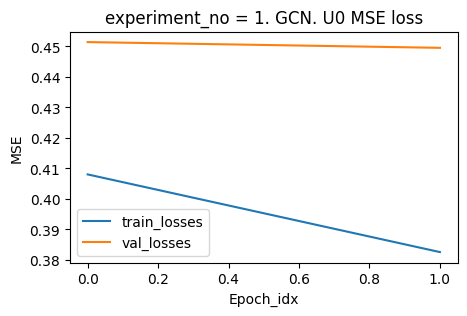

💾 Dict of results Saved in /content/GCN_U0_checkpoint_15k/results_GCN_U0_ex1.json 
💾 Saved new checkpoint. Epoch start idx = 2
experiment_no = 2
No checkpoint found — starting fresh
*** New best model saved in bestGCN_U0_ex2.pt
Epoch 000 | Train MSE: 0.4117 | Val MSE: 0.3893
Epoch 001 | Train MSE: 0.3894 | Val MSE: 0.3928


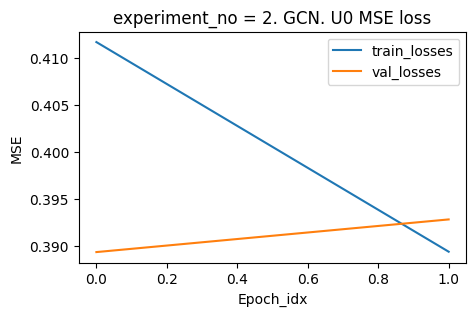

💾 Dict of results Saved in /content/GCN_U0_checkpoint_15k/results_GCN_U0_ex2.json 
💾 Saved new checkpoint. Epoch start idx = 2
experiment_no = 3
No checkpoint found — starting fresh
*** New best model saved in bestGCN_U0_ex3.pt
Epoch 000 | Train MSE: 0.4294 | Val MSE: 0.4163
*** New best model saved in bestGCN_U0_ex3.pt
Epoch 001 | Train MSE: 0.4054 | Val MSE: 0.4126


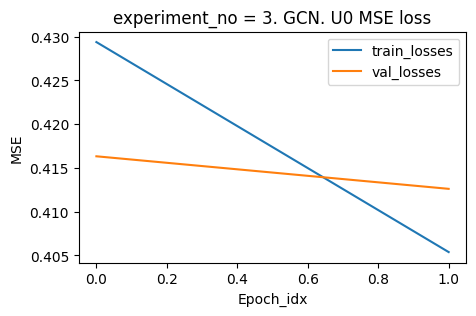

💾 Dict of results Saved in /content/GCN_U0_checkpoint_15k/results_GCN_U0_ex3.json 
💾 Saved new checkpoint. Epoch start idx = 2
target_name = mu
experiment_no = 1
No checkpoint found — starting fresh
*** New best model saved in bestGCN_mu_ex1.pt
Epoch 000 | Train MSE: 0.7566 | Val MSE: 0.6427
*** New best model saved in bestGCN_mu_ex1.pt
Epoch 001 | Train MSE: 0.6979 | Val MSE: 0.6187


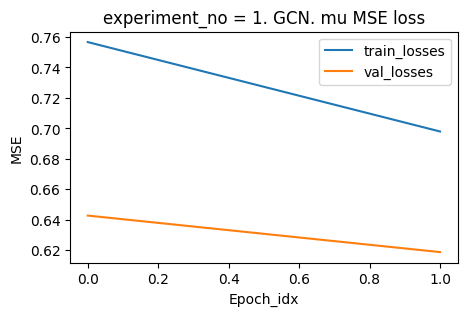

💾 Dict of results Saved in /content/GCN_mu_checkpoint_15k/results_GCN_mu_ex1.json 
💾 Saved new checkpoint. Epoch start idx = 2
experiment_no = 2
No checkpoint found — starting fresh
*** New best model saved in bestGCN_mu_ex2.pt
Epoch 000 | Train MSE: 0.7459 | Val MSE: 0.6899
*** New best model saved in bestGCN_mu_ex2.pt
Epoch 001 | Train MSE: 0.6667 | Val MSE: 0.6592


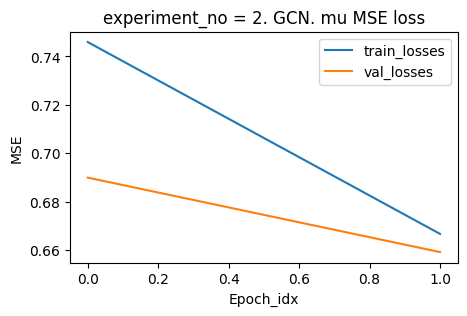

💾 Dict of results Saved in /content/GCN_mu_checkpoint_15k/results_GCN_mu_ex2.json 
💾 Saved new checkpoint. Epoch start idx = 2
experiment_no = 3
No checkpoint found — starting fresh
*** New best model saved in bestGCN_mu_ex3.pt
Epoch 000 | Train MSE: 0.7518 | Val MSE: 0.5973
*** New best model saved in bestGCN_mu_ex3.pt
Epoch 001 | Train MSE: 0.7004 | Val MSE: 0.5846


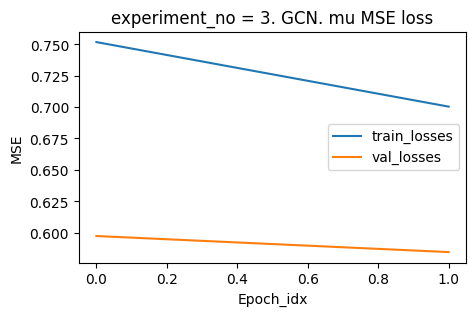

💾 Dict of results Saved in /content/GCN_mu_checkpoint_15k/results_GCN_mu_ex3.json 
💾 Saved new checkpoint. Epoch start idx = 2


In [223]:
# train

# 15k
epoch_funcs = (train_epoch, eval_epoch)
train_model(model_name, model,
                gcn_loaders_15k,
                TARGET_NAMES,
                epoch_funcs,
                2, 15000,
                stats_15k
                )

In [224]:
############ 104k
model_name = "GCN"
model = GCN

dataset_split = (train_set, val_set) ## , [test_set]
gcn_loader = get_experiment_loaders(dataset_split)

len loaders in experiment (1*train + 1*val) = 2


experiment_no = 1
Resuming from epoch 60 | best_val = 0.3736


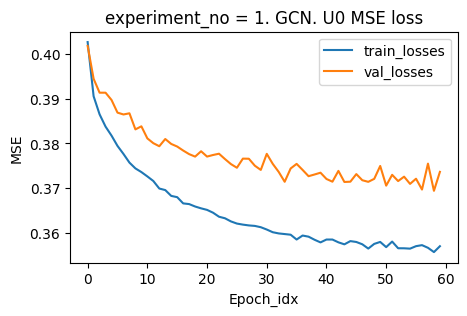

start_epoch = epochs = 60 ==> NO new checkpoint to save.


In [225]:
target_name = 'U0'
experiment_no = 1

train_size = len(train_set)

epoch_funcs = (train_epoch, eval_epoch)

train_experiment(model, gcn_loader,
                     target_name, experiment_no,
                     epoch_funcs,
                     60, train_size,
                     stats_104k)

In [226]:
############ 104k
model_name = "GCN"
model = GCN

dataset_split = (train_set, val_set) ## , [test_set]
gcn_loader = get_experiment_loaders(dataset_split)

len loaders in experiment (1*train + 1*val) = 2


experiment_no = 1
Resuming from epoch 60 | best_val = 0.3702


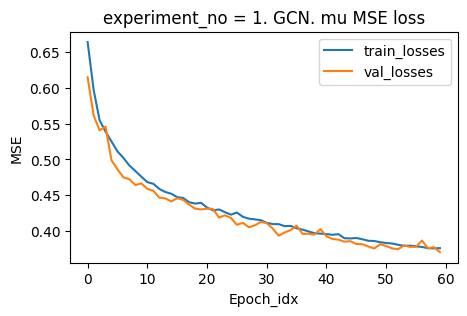

start_epoch = epochs = 60 ==> NO new checkpoint to save.


In [227]:
target_name = 'mu'
experiment_no = 1

train_size = len(train_set)

epoch_funcs = (train_epoch, eval_epoch)

train_experiment(model, gcn_loader,
                     target_name, experiment_no,
                     epoch_funcs,
                     60, train_size,
                     stats_104k)

# ___train DistanceGNN

In [228]:
# init

model_name = "DistanceGNN"
model = DistanceGNN

In [229]:
############ 104k
model_name = "DistanceGNN"
model = DistanceGNN

dataset_split = (train_set, val_set) ## , [test_set]
gnn_loader = get_experiment_loaders(dataset_split)

len loaders in experiment (1*train + 1*val) = 2


experiment_no = 1
Resuming from epoch 50 | best_val = 0.3678


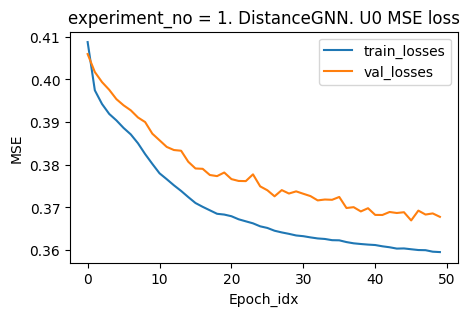

start_epoch = epochs = 50 ==> NO new checkpoint to save.


In [230]:
target_name = 'U0'
experiment_no = 1

train_size = len(train_set)

epoch_funcs = (train_epoch, eval_epoch)

train_experiment(model, gnn_loader,
                     target_name, experiment_no,
                     epoch_funcs,
                     50, train_size,
                     stats_104k)

experiment_no = 1
Resuming from epoch 50 | best_val = 0.5562


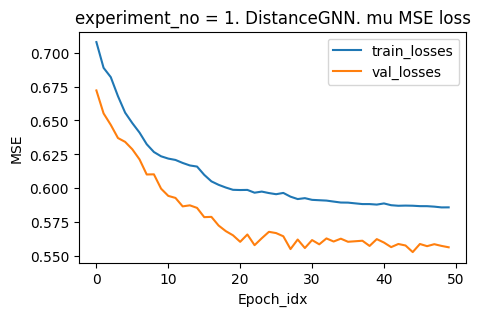

start_epoch = epochs = 50 ==> NO new checkpoint to save.


In [231]:
target_name = 'mu'
experiment_no = 1

train_size = len(train_set)

epoch_funcs = (train_epoch, eval_epoch)

train_experiment(model, gnn_loader,
                     target_name, experiment_no,
                     epoch_funcs,
                     50, train_size,
                     stats_104k)

In [ ]:
################### 15k
gnn_loaders_15k = get_model_loaders(data_dict_15k, TARGET_NAMES)

model name = DistanceGNN
target_name = U0
experiment_no = 1
⭐ New best model saved in bestDistanceGNN_U0_ex1.pt
Epoch 001 | Train MSE: 0.4177 | Val MSE: 0.4402
⭐ New best model saved in bestDistanceGNN_U0_ex1.pt
⭐ New best model saved in bestDistanceGNN_U0_ex1.pt
⭐ New best model saved in bestDistanceGNN_U0_ex1.pt
⭐ New best model saved in bestDistanceGNN_U0_ex1.pt
⭐ New best model saved in bestDistanceGNN_U0_ex1.pt
Epoch 006 | Train MSE: 0.3801 | Val MSE: 0.4189
⭐ New best model saved in bestDistanceGNN_U0_ex1.pt
⭐ New best model saved in bestDistanceGNN_U0_ex1.pt
⭐ New best model saved in bestDistanceGNN_U0_ex1.pt
⭐ New best model saved in bestDistanceGNN_U0_ex1.pt
⭐ New best model saved in bestDistanceGNN_U0_ex1.pt
Epoch 011 | Train MSE: 0.3759 | Val MSE: 0.4148
⭐ New best model saved in bestDistanceGNN_U0_ex1.pt
⭐ New best model saved in bestDistanceGNN_U0_ex1.pt
⭐ New best model saved in bestDistanceGNN_U0_ex1.pt
⭐ New best model saved in bestDistanceGNN_U0_ex1.pt
⭐ New best model

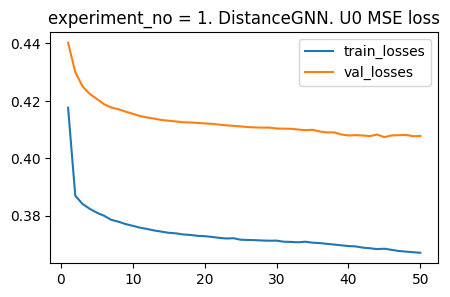

experiment_no = 2
⭐ New best model saved in bestDistanceGNN_U0_ex2.pt
Epoch 001 | Train MSE: 0.4223 | Val MSE: 0.4069
⭐ New best model saved in bestDistanceGNN_U0_ex2.pt
⭐ New best model saved in bestDistanceGNN_U0_ex2.pt
⭐ New best model saved in bestDistanceGNN_U0_ex2.pt
⭐ New best model saved in bestDistanceGNN_U0_ex2.pt
⭐ New best model saved in bestDistanceGNN_U0_ex2.pt
Epoch 006 | Train MSE: 0.3825 | Val MSE: 0.3991
⭐ New best model saved in bestDistanceGNN_U0_ex2.pt
⭐ New best model saved in bestDistanceGNN_U0_ex2.pt
⭐ New best model saved in bestDistanceGNN_U0_ex2.pt
⭐ New best model saved in bestDistanceGNN_U0_ex2.pt
⭐ New best model saved in bestDistanceGNN_U0_ex2.pt
Epoch 011 | Train MSE: 0.3776 | Val MSE: 0.3940
⭐ New best model saved in bestDistanceGNN_U0_ex2.pt
⭐ New best model saved in bestDistanceGNN_U0_ex2.pt
⭐ New best model saved in bestDistanceGNN_U0_ex2.pt
⭐ New best model saved in bestDistanceGNN_U0_ex2.pt
Epoch 016 | Train MSE: 0.3748 | Val MSE: 0.3920
⭐ New best

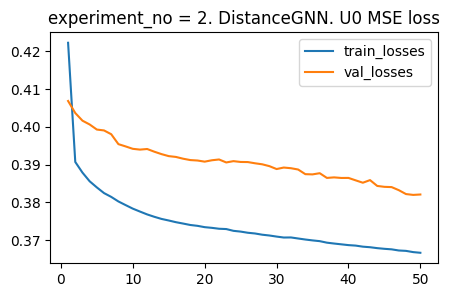

experiment_no = 3
⭐ New best model saved in bestDistanceGNN_U0_ex3.pt
Epoch 001 | Train MSE: 0.4384 | Val MSE: 0.4286
⭐ New best model saved in bestDistanceGNN_U0_ex3.pt
⭐ New best model saved in bestDistanceGNN_U0_ex3.pt
⭐ New best model saved in bestDistanceGNN_U0_ex3.pt
⭐ New best model saved in bestDistanceGNN_U0_ex3.pt
⭐ New best model saved in bestDistanceGNN_U0_ex3.pt
Epoch 006 | Train MSE: 0.4044 | Val MSE: 0.4155
⭐ New best model saved in bestDistanceGNN_U0_ex3.pt
⭐ New best model saved in bestDistanceGNN_U0_ex3.pt
⭐ New best model saved in bestDistanceGNN_U0_ex3.pt
⭐ New best model saved in bestDistanceGNN_U0_ex3.pt
⭐ New best model saved in bestDistanceGNN_U0_ex3.pt
Epoch 011 | Train MSE: 0.3997 | Val MSE: 0.4105
⭐ New best model saved in bestDistanceGNN_U0_ex3.pt
⭐ New best model saved in bestDistanceGNN_U0_ex3.pt
⭐ New best model saved in bestDistanceGNN_U0_ex3.pt
⭐ New best model saved in bestDistanceGNN_U0_ex3.pt
⭐ New best model saved in bestDistanceGNN_U0_ex3.pt
Epoch 

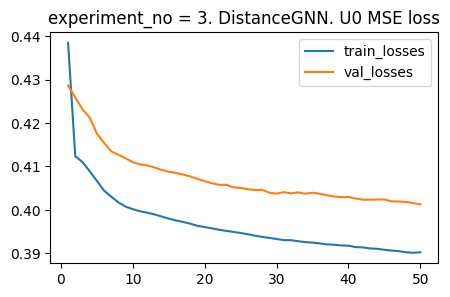

target_name = mu
experiment_no = 1
⭐ New best model saved in bestDistanceGNN_mu_ex1.pt
Epoch 001 | Train MSE: 0.7654 | Val MSE: 0.6577
⭐ New best model saved in bestDistanceGNN_mu_ex1.pt
⭐ New best model saved in bestDistanceGNN_mu_ex1.pt
⭐ New best model saved in bestDistanceGNN_mu_ex1.pt
⭐ New best model saved in bestDistanceGNN_mu_ex1.pt
⭐ New best model saved in bestDistanceGNN_mu_ex1.pt
Epoch 006 | Train MSE: 0.6992 | Val MSE: 0.6462
⭐ New best model saved in bestDistanceGNN_mu_ex1.pt
⭐ New best model saved in bestDistanceGNN_mu_ex1.pt
⭐ New best model saved in bestDistanceGNN_mu_ex1.pt
⭐ New best model saved in bestDistanceGNN_mu_ex1.pt
Epoch 011 | Train MSE: 0.6950 | Val MSE: 0.6443
⭐ New best model saved in bestDistanceGNN_mu_ex1.pt
⭐ New best model saved in bestDistanceGNN_mu_ex1.pt
⭐ New best model saved in bestDistanceGNN_mu_ex1.pt
⭐ New best model saved in bestDistanceGNN_mu_ex1.pt
⭐ New best model saved in bestDistanceGNN_mu_ex1.pt
Epoch 016 | Train MSE: 0.6895 | Val MSE: 

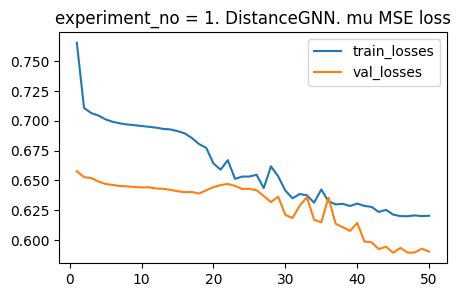

experiment_no = 2
⭐ New best model saved in bestDistanceGNN_mu_ex2.pt
Epoch 001 | Train MSE: 0.7498 | Val MSE: 0.7249
⭐ New best model saved in bestDistanceGNN_mu_ex2.pt
⭐ New best model saved in bestDistanceGNN_mu_ex2.pt
⭐ New best model saved in bestDistanceGNN_mu_ex2.pt
⭐ New best model saved in bestDistanceGNN_mu_ex2.pt
⭐ New best model saved in bestDistanceGNN_mu_ex2.pt
Epoch 006 | Train MSE: 0.6729 | Val MSE: 0.6951
⭐ New best model saved in bestDistanceGNN_mu_ex2.pt
⭐ New best model saved in bestDistanceGNN_mu_ex2.pt
⭐ New best model saved in bestDistanceGNN_mu_ex2.pt
⭐ New best model saved in bestDistanceGNN_mu_ex2.pt
⭐ New best model saved in bestDistanceGNN_mu_ex2.pt
Epoch 011 | Train MSE: 0.6678 | Val MSE: 0.6905
⭐ New best model saved in bestDistanceGNN_mu_ex2.pt
⭐ New best model saved in bestDistanceGNN_mu_ex2.pt
⭐ New best model saved in bestDistanceGNN_mu_ex2.pt
⭐ New best model saved in bestDistanceGNN_mu_ex2.pt
⭐ New best model saved in bestDistanceGNN_mu_ex2.pt
Epoch 

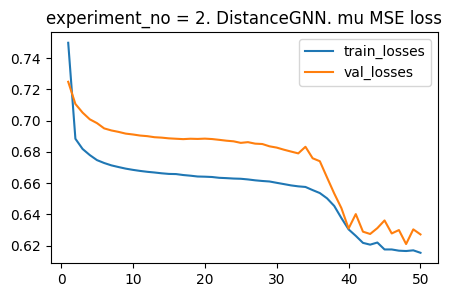

experiment_no = 3
⭐ New best model saved in bestDistanceGNN_mu_ex3.pt
Epoch 001 | Train MSE: 0.7682 | Val MSE: 0.6097
⭐ New best model saved in bestDistanceGNN_mu_ex3.pt
⭐ New best model saved in bestDistanceGNN_mu_ex3.pt
⭐ New best model saved in bestDistanceGNN_mu_ex3.pt
⭐ New best model saved in bestDistanceGNN_mu_ex3.pt
⭐ New best model saved in bestDistanceGNN_mu_ex3.pt
Epoch 006 | Train MSE: 0.7078 | Val MSE: 0.5895
⭐ New best model saved in bestDistanceGNN_mu_ex3.pt
⭐ New best model saved in bestDistanceGNN_mu_ex3.pt
⭐ New best model saved in bestDistanceGNN_mu_ex3.pt
⭐ New best model saved in bestDistanceGNN_mu_ex3.pt
Epoch 011 | Train MSE: 0.6926 | Val MSE: 0.5753
⭐ New best model saved in bestDistanceGNN_mu_ex3.pt
⭐ New best model saved in bestDistanceGNN_mu_ex3.pt
Epoch 016 | Train MSE: 0.6665 | Val MSE: 0.5770
Epoch 021 | Train MSE: 0.6451 | Val MSE: 0.5851
Epoch 026 | Train MSE: 0.6343 | Val MSE: 0.5856
Epoch 031 | Train MSE: 0.6286 | Val MSE: 0.5798
Epoch 036 | Train MSE:

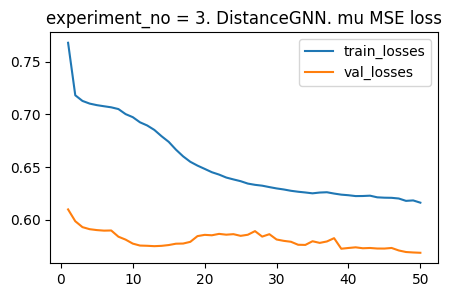

In [ ]:
# train

# 15k
epoch_funcs = (train_epoch, eval_epoch)
train_model(model_name, model,
                gnn_loaders_15k,
                TARGET_NAMES,
                epoch_funcs,
                EPOCHS, 15000,
                stats_15k
                )

In [233]:
#################### 10k
gnn_loaders_10k = get_model_loaders(data_dict_10k, TARGET_NAMES)

target_name = U0
len loaders in experiment (1*train + 1*val) = 2
len loaders in experiment (1*train + 1*val) = 2
len loaders in experiment (1*train + 1*val) = 2
len of loaders for target = 3 (number of experiments)
target_name = mu
len loaders in experiment (1*train + 1*val) = 2
len loaders in experiment (1*train + 1*val) = 2
len loaders in experiment (1*train + 1*val) = 2
len of loaders for target = 3 (number of experiments)
len of model loaders = 2 ( number of targets)


model name = DistanceGNN
target_name = U0
experiment_no = 1
No checkpoint found — starting fresh
*** New best model saved in bestDistanceGNN_U0_ex1.pt
Epoch 000 | Train MSE: 0.4247 | Val MSE: 0.4251
*** New best model saved in bestDistanceGNN_U0_ex1.pt
Epoch 001 | Train MSE: 0.3922 | Val MSE: 0.4243


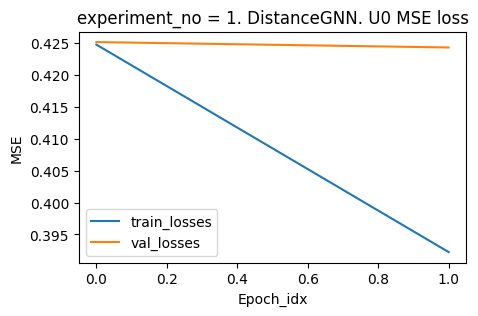

💾 Dict of results Saved in /content/DistanceGNN_U0_checkpoint_10k/results_DistanceGNN_U0_ex1.json 
💾 Saved new checkpoint. Epoch start idx = 2
experiment_no = 2
No checkpoint found — starting fresh
*** New best model saved in bestDistanceGNN_U0_ex2.pt
Epoch 000 | Train MSE: 0.4277 | Val MSE: 0.4233
Epoch 001 | Train MSE: 0.3883 | Val MSE: 0.4302


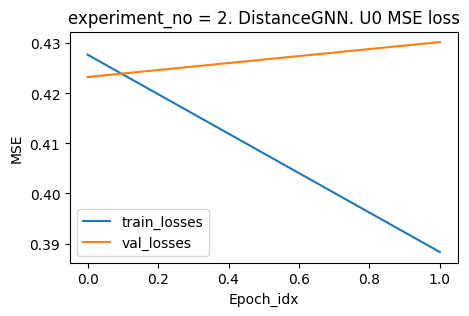

💾 Dict of results Saved in /content/DistanceGNN_U0_checkpoint_10k/results_DistanceGNN_U0_ex2.json 
💾 Saved new checkpoint. Epoch start idx = 2
experiment_no = 3
No checkpoint found — starting fresh
*** New best model saved in bestDistanceGNN_U0_ex3.pt
Epoch 000 | Train MSE: 0.4240 | Val MSE: 0.4313
*** New best model saved in bestDistanceGNN_U0_ex3.pt
Epoch 001 | Train MSE: 0.3924 | Val MSE: 0.4280


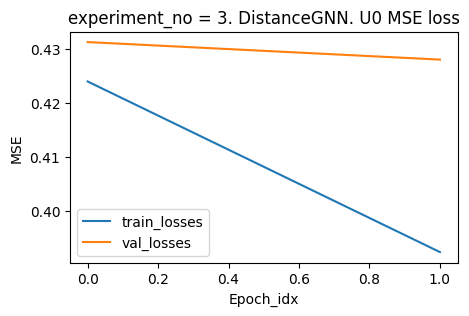

💾 Dict of results Saved in /content/DistanceGNN_U0_checkpoint_10k/results_DistanceGNN_U0_ex3.json 
💾 Saved new checkpoint. Epoch start idx = 2
target_name = mu
experiment_no = 1
No checkpoint found — starting fresh
*** New best model saved in bestDistanceGNN_mu_ex1.pt
Epoch 000 | Train MSE: 0.7919 | Val MSE: 0.6962
*** New best model saved in bestDistanceGNN_mu_ex1.pt
Epoch 001 | Train MSE: 0.7207 | Val MSE: 0.6900


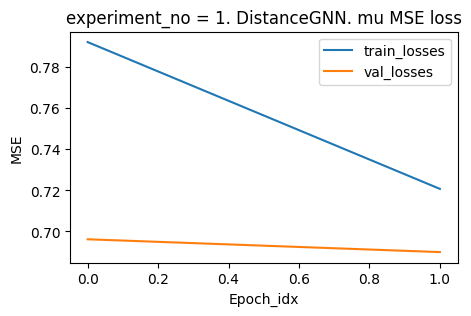

💾 Dict of results Saved in /content/DistanceGNN_mu_checkpoint_10k/results_DistanceGNN_mu_ex1.json 
💾 Saved new checkpoint. Epoch start idx = 2
experiment_no = 2
No checkpoint found — starting fresh
*** New best model saved in bestDistanceGNN_mu_ex2.pt
Epoch 000 | Train MSE: 0.7677 | Val MSE: 0.7172
*** New best model saved in bestDistanceGNN_mu_ex2.pt
Epoch 001 | Train MSE: 0.6966 | Val MSE: 0.6988


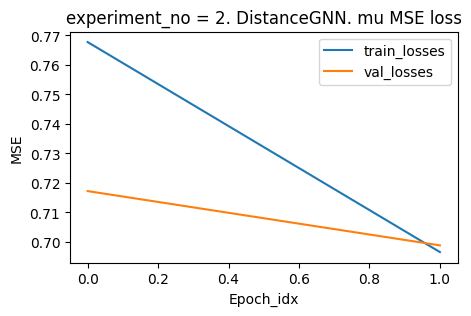

💾 Dict of results Saved in /content/DistanceGNN_mu_checkpoint_10k/results_DistanceGNN_mu_ex2.json 
💾 Saved new checkpoint. Epoch start idx = 2
experiment_no = 3
No checkpoint found — starting fresh
*** New best model saved in bestDistanceGNN_mu_ex3.pt
Epoch 000 | Train MSE: 0.7744 | Val MSE: 0.6338
*** New best model saved in bestDistanceGNN_mu_ex3.pt
Epoch 001 | Train MSE: 0.7006 | Val MSE: 0.6190


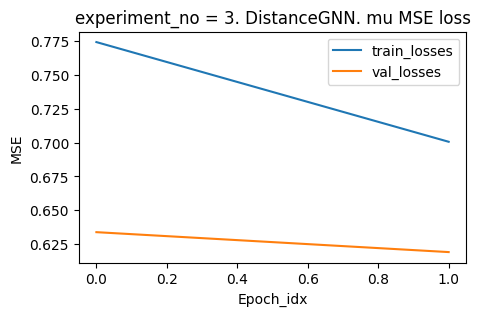

💾 Dict of results Saved in /content/DistanceGNN_mu_checkpoint_10k/results_DistanceGNN_mu_ex3.json 
💾 Saved new checkpoint. Epoch start idx = 2


In [234]:
# train

# 10k
epoch_funcs = (train_epoch, eval_epoch)
train_model(model_name, model,
                gnn_loaders_10k,
                TARGET_NAMES,
                epoch_funcs,
                2, 10000,
                stats_10k
                )

# ___train EGNN

In [ ]:
################# EGNN

In [314]:
# init
model_name = "EGNN"
model = EGNNModelSafe

egnn_epoch_funcs = (train_epoch_egnn, eval_epoch_egnn)

In [236]:
egnn_params_10k = stats_10k, make_egnn_collate
egnn_loaders_10k = get_model_loaders(data_dict_10k, TARGET_NAMES, egnn_params_10k)

target_name = U0
len loaders in experiment (1*train + 1*val) = 2
len loaders in experiment (1*train + 1*val) = 2
len loaders in experiment (1*train + 1*val) = 2
len of loaders for target = 3 (number of experiments)
target_name = mu
len loaders in experiment (1*train + 1*val) = 2
len loaders in experiment (1*train + 1*val) = 2
len loaders in experiment (1*train + 1*val) = 2
len of loaders for target = 3 (number of experiments)
len of model loaders = 2 ( number of targets)


model name = EGNN
target_name = U0
experiment_no = 1
No checkpoint found — starting fresh


/tmp/ipython-input-1072931815.py:22: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/usr/local/lib/python3.12/dist-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


*** New best model saved in bestEGNN_U0_ex1.pt
Epoch 000 | Train MSE: 0.9886 | Val MSE: 0.7842
*** New best model saved in bestEGNN_U0_ex1.pt
Epoch 001 | Train MSE: 0.7321 | Val MSE: 0.7164


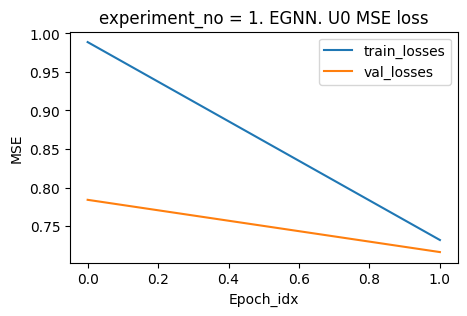

💾 Dict of results Saved in /content/EGNN_U0_checkpoint_10k/results_EGNN_U0_ex1.json 
💾 Saved new checkpoint. Epoch start idx = 2
experiment_no = 2
No checkpoint found — starting fresh
*** New best model saved in bestEGNN_U0_ex2.pt
Epoch 000 | Train MSE: 0.8005 | Val MSE: 0.6850
*** New best model saved in bestEGNN_U0_ex2.pt
Epoch 001 | Train MSE: 0.5601 | Val MSE: 0.4574


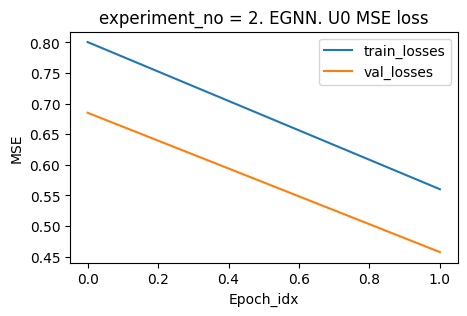

💾 Dict of results Saved in /content/EGNN_U0_checkpoint_10k/results_EGNN_U0_ex2.json 
💾 Saved new checkpoint. Epoch start idx = 2
experiment_no = 3
No checkpoint found — starting fresh
*** New best model saved in bestEGNN_U0_ex3.pt
Epoch 000 | Train MSE: 0.9103 | Val MSE: 0.7884
*** New best model saved in bestEGNN_U0_ex3.pt
Epoch 001 | Train MSE: 0.7122 | Val MSE: 0.7195


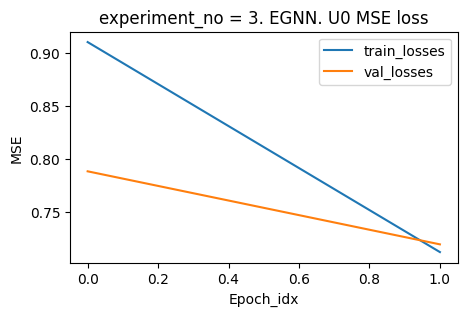

💾 Dict of results Saved in /content/EGNN_U0_checkpoint_10k/results_EGNN_U0_ex3.json 
💾 Saved new checkpoint. Epoch start idx = 2
target_name = mu
experiment_no = 1
No checkpoint found — starting fresh
*** New best model saved in bestEGNN_mu_ex1.pt
Epoch 000 | Train MSE: 0.9970 | Val MSE: 0.9193
*** New best model saved in bestEGNN_mu_ex1.pt
Epoch 001 | Train MSE: 0.8730 | Val MSE: 0.8220


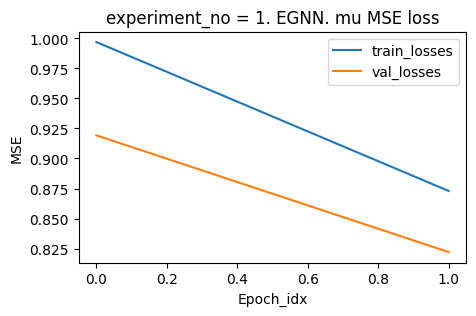

💾 Dict of results Saved in /content/EGNN_mu_checkpoint_10k/results_EGNN_mu_ex1.json 
💾 Saved new checkpoint. Epoch start idx = 2
experiment_no = 2
No checkpoint found — starting fresh
*** New best model saved in bestEGNN_mu_ex2.pt
Epoch 000 | Train MSE: 0.9424 | Val MSE: 0.8614
*** New best model saved in bestEGNN_mu_ex2.pt
Epoch 001 | Train MSE: 0.8468 | Val MSE: 0.8453


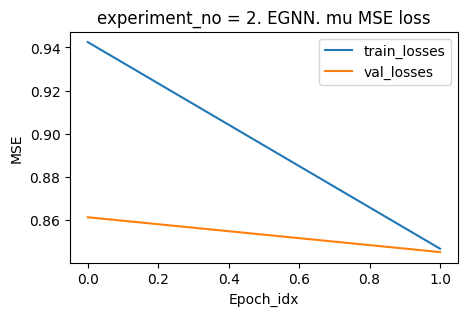

💾 Dict of results Saved in /content/EGNN_mu_checkpoint_10k/results_EGNN_mu_ex2.json 
💾 Saved new checkpoint. Epoch start idx = 2
experiment_no = 3
No checkpoint found — starting fresh
*** New best model saved in bestEGNN_mu_ex3.pt
Epoch 000 | Train MSE: 0.9391 | Val MSE: 0.7475
Epoch 001 | Train MSE: 0.8605 | Val MSE: 0.7638


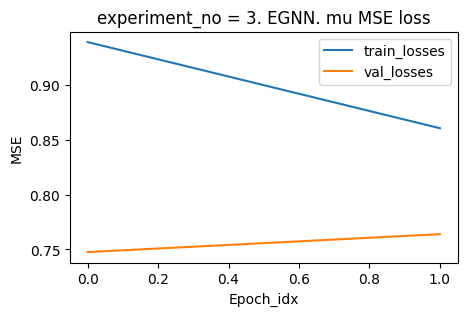

💾 Dict of results Saved in /content/EGNN_mu_checkpoint_10k/results_EGNN_mu_ex3.json 
💾 Saved new checkpoint. Epoch start idx = 2


In [315]:
# 10k
train_model(model_name, model,
                egnn_loaders_10k,
                TARGET_NAMES,
                egnn_epoch_funcs,
                2, 10000
                )

In [238]:
################ 15k

egnn_params_15k = stats_15k, make_egnn_collate
egnn_loaders_15k = get_model_loaders(data_dict_15k, TARGET_NAMES, egnn_params_15k)

target_name = U0
len loaders in experiment (1*train + 1*val) = 2
len loaders in experiment (1*train + 1*val) = 2
len loaders in experiment (1*train + 1*val) = 2
len of loaders for target = 3 (number of experiments)
target_name = mu
len loaders in experiment (1*train + 1*val) = 2
len loaders in experiment (1*train + 1*val) = 2
len loaders in experiment (1*train + 1*val) = 2
len of loaders for target = 3 (number of experiments)
len of model loaders = 2 ( number of targets)


model name = EGNN
target_name = U0
experiment_no = 1
No checkpoint found — starting fresh


/tmp/ipython-input-1072931815.py:22: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


*** New best model saved in bestEGNN_U0_ex1.pt
Epoch 000 | Train MSE: 0.8162 | Val MSE: 0.7266
*** New best model saved in bestEGNN_U0_ex1.pt
Epoch 001 | Train MSE: 0.6629 | Val MSE: 0.5650


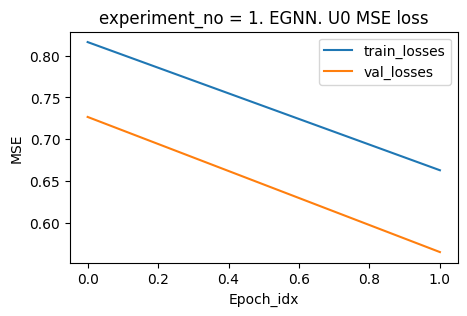

💾 Dict of results Saved in /content/EGNN_U0_checkpoint_15k/results_EGNN_U0_ex1.json 
💾 Saved new checkpoint. Epoch start idx = 2
experiment_no = 2
No checkpoint found — starting fresh
*** New best model saved in bestEGNN_U0_ex2.pt
Epoch 000 | Train MSE: 0.7453 | Val MSE: 0.5728
*** New best model saved in bestEGNN_U0_ex2.pt
Epoch 001 | Train MSE: 0.4712 | Val MSE: 0.4084


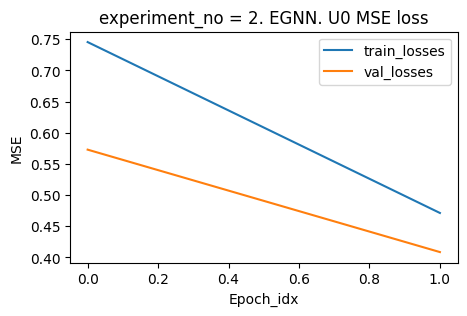

💾 Dict of results Saved in /content/EGNN_U0_checkpoint_15k/results_EGNN_U0_ex2.json 
💾 Saved new checkpoint. Epoch start idx = 2
experiment_no = 3
No checkpoint found — starting fresh
*** New best model saved in bestEGNN_U0_ex3.pt
Epoch 000 | Train MSE: 0.7028 | Val MSE: 0.4750
*** New best model saved in bestEGNN_U0_ex3.pt
Epoch 001 | Train MSE: 0.4702 | Val MSE: 0.4079


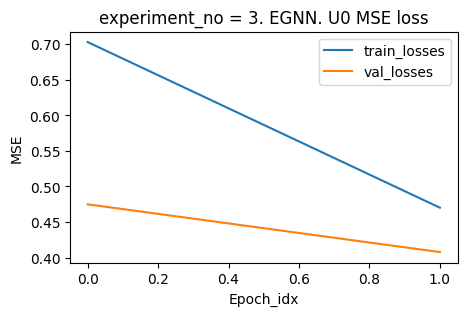

💾 Dict of results Saved in /content/EGNN_U0_checkpoint_15k/results_EGNN_U0_ex3.json 
💾 Saved new checkpoint. Epoch start idx = 2
target_name = mu
experiment_no = 1
No checkpoint found — starting fresh
*** New best model saved in bestEGNN_mu_ex1.pt
Epoch 000 | Train MSE: 0.9341 | Val MSE: 0.8087
*** New best model saved in bestEGNN_mu_ex1.pt
Epoch 001 | Train MSE: 0.8439 | Val MSE: 0.7561


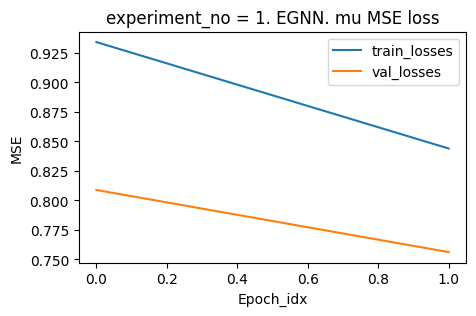

💾 Dict of results Saved in /content/EGNN_mu_checkpoint_15k/results_EGNN_mu_ex1.json 
💾 Saved new checkpoint. Epoch start idx = 2
experiment_no = 2
No checkpoint found — starting fresh
*** New best model saved in bestEGNN_mu_ex2.pt
Epoch 000 | Train MSE: 0.9708 | Val MSE: 0.8648
*** New best model saved in bestEGNN_mu_ex2.pt
Epoch 001 | Train MSE: 0.8289 | Val MSE: 0.8401


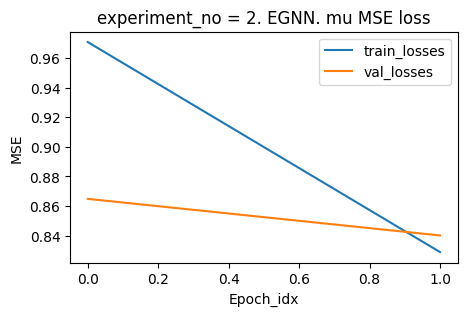

💾 Dict of results Saved in /content/EGNN_mu_checkpoint_15k/results_EGNN_mu_ex2.json 
💾 Saved new checkpoint. Epoch start idx = 2
experiment_no = 3
No checkpoint found — starting fresh
*** New best model saved in bestEGNN_mu_ex3.pt
Epoch 000 | Train MSE: 0.9171 | Val MSE: 0.6806
*** New best model saved in bestEGNN_mu_ex3.pt
Epoch 001 | Train MSE: 0.8201 | Val MSE: 0.6658


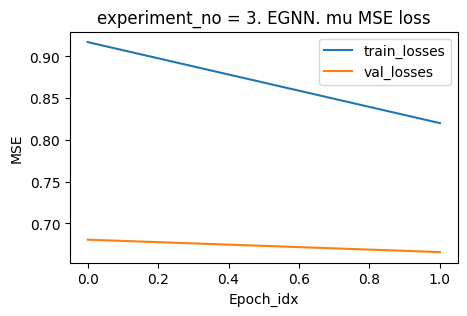

💾 Dict of results Saved in /content/EGNN_mu_checkpoint_15k/results_EGNN_mu_ex3.json 
💾 Saved new checkpoint. Epoch start idx = 2


In [317]:
# 15k
train_model(model_name, model,
                egnn_loaders_15k,
                TARGET_NAMES,
                egnn_epoch_funcs,
                2, 15000
                )

# ТЕСТЫ

1 мы посмотрим, как MSE зависит от выбранной модели, таргета, тренировочного набора и его размера, тестового набора.

2 Визуально оценим training curves

3 Оформим результаты по MSE в таблицы

4 Проведем Rotation tests для обученных и необученных моделей.

5 Сделаем Test geometry ablation - оценим влияние "обессмысливания" координат на предсказание таргета. Рассмотрим, влияет ли топология молекулы на точность предсказаня. Есть ли заввисимость от таргета и inductive biases модели.

# -- Тесты. Сохранение результатов (test MSE).

In [163]:
# GET test loaders
params_10k = stats_10k, make_fcnn_collate
fcnn_10k_test_loders = get_model_test_loaders(test_set, TARGET_NAMES, params_10k)

params_15k = stats_15k, make_fcnn_collate
fcnn_15k_test_loders = get_model_test_loaders(test_set, TARGET_NAMES, params_15k)

params_104k = stats_104k, make_fcnn_collate
fcnn_104k_test_loders = get_model_test_loaders(test_set, TARGET_NAMES, params_104k)

# fcnn_loaders_per_size = (
#     (fcnn_10k_test_loders, 10000, None),
#      (fcnn_15k_test_loders, 15000, None),
#       (fcnn_104k_test_loders, 104000, None)
#       )

target_name = U0
len test_loaders in experiment = 9
len test_loaders in experiment = 9
len test_loaders in experiment = 9
len test_loaders in experiment = 9
len test_loaders in experiment = 9
len test_loaders in experiment = 9
len test_loaders in experiment = 9
len test_loaders in experiment = 9
len test_loaders in experiment = 9
target_name = mu
len test_loaders in experiment = 9
len test_loaders in experiment = 9
len test_loaders in experiment = 9
len test_loaders in experiment = 9
len test_loaders in experiment = 9
len test_loaders in experiment = 9
len test_loaders in experiment = 9
len test_loaders in experiment = 9
len test_loaders in experiment = 9
target_name = U0
len test_loaders in experiment = 9
len test_loaders in experiment = 9
len test_loaders in experiment = 9
len test_loaders in experiment = 9
len test_loaders in experiment = 9
len test_loaders in experiment = 9
len test_loaders in experiment = 9
len test_loaders in experiment = 9
len test_loaders in experiment = 9
targ

In [164]:
# GCN, DistanceGNN
gn_10k_test_loders = get_model_test_loaders(test_set, TARGET_NAMES)

gn_15k_test_loders = get_model_test_loaders(test_set, TARGET_NAMES)

gn_104k_test_loders = get_model_test_loaders(test_set, TARGET_NAMES)

# gn_loaders_per_size = (
#     (gn_10k_test_loders, 10000, stats_10k),
#     (gn_15k_test_loders, 15000, stats_15k),
#     (gn_104k_test_loders, 104000, stats_104k)
#     )

target_name = U0
len test_loaders in experiment = 9
len test_loaders in experiment = 9
len test_loaders in experiment = 9
target_name = mu
len test_loaders in experiment = 9
len test_loaders in experiment = 9
len test_loaders in experiment = 9
target_name = U0
len test_loaders in experiment = 9
len test_loaders in experiment = 9
len test_loaders in experiment = 9
target_name = mu
len test_loaders in experiment = 9
len test_loaders in experiment = 9
len test_loaders in experiment = 9
target_name = U0
len test_loaders in experiment = 9
len test_loaders in experiment = 9
len test_loaders in experiment = 9
target_name = mu
len test_loaders in experiment = 9
len test_loaders in experiment = 9
len test_loaders in experiment = 9


In [165]:
# EGNN
egnn_params_10k = stats_10k, make_egnn_collate
egnn_10k_test_loders = get_model_test_loaders(test_set, TARGET_NAMES, egnn_params_10k)

egnn_params_15k = stats_15k, make_egnn_collate
egnn_15k_test_loders = get_model_test_loaders(test_set, TARGET_NAMES, egnn_params_15k)

# egnn_loaders_per_size = (
#     (egnn_10k_test_loders, 10000, None),
#      (egnn_15k_test_loders, 15000, None),
#       # (egnn_104k_test_loders, 104000, None)
#       )

target_name = U0
len test_loaders in experiment = 9
len test_loaders in experiment = 9
len test_loaders in experiment = 9
len test_loaders in experiment = 9
len test_loaders in experiment = 9
len test_loaders in experiment = 9
len test_loaders in experiment = 9
len test_loaders in experiment = 9
len test_loaders in experiment = 9
target_name = mu
len test_loaders in experiment = 9
len test_loaders in experiment = 9
len test_loaders in experiment = 9
len test_loaders in experiment = 9
len test_loaders in experiment = 9
len test_loaders in experiment = 9
len test_loaders in experiment = 9
len test_loaders in experiment = 9
len test_loaders in experiment = 9
target_name = U0
len test_loaders in experiment = 9
len test_loaders in experiment = 9
len test_loaders in experiment = 9
len test_loaders in experiment = 9
len test_loaders in experiment = 9
len test_loaders in experiment = 9
len test_loaders in experiment = 9
len test_loaders in experiment = 9
len test_loaders in experiment = 9
targ

In [166]:
fcnn_loaders_per_size = (
    (fcnn_10k_test_loders, 10000, None),
     (fcnn_15k_test_loders, 15000, None),
      (fcnn_104k_test_loders, 104000, None)
      )

gn_loaders_per_size = (
    (gn_10k_test_loders, 10000, stats_10k),
    (gn_15k_test_loders, 15000, stats_15k),
    (gn_104k_test_loders, 104000, stats_104k)
    )

egnn_loaders_per_size = (
    (egnn_10k_test_loders, 10000, None),
     (egnn_15k_test_loders, 15000, None),
      # (egnn_104k_test_loders, 104000, None)
      )

models_loaders_per_size = (fcnn_loaders_per_size,
                           gn_loaders_per_size,
                           gn_loaders_per_size,
                           egnn_loaders_per_size)

model_test_funcs = (
    eval_epoch_fcnn,
    eval_epoch,
    eval_epoch,
    eval_epoch_egnn
    )

In [186]:
# zip() function returns a zip object, which is an iterator of tuples
models = zip(MODELS, MODEL_NAMES, model_test_funcs, models_loaders_per_size)

In [187]:
for model_tuple in models:
  model, model_name, test_func, models_loaders = model_tuple
  print(f'-----------------------------MODEL {model_name}')
  for model_test_loaders, train_size, stats in models_loaders:
    print(f'-----------------EXPERIMENTS by model')
    test_model(TARGET_NAMES, train_size, model, model_name, test_func, model_test_loaders, stats)

-----------------------------MODEL FCNN
-----------------EXPERIMENTS by model
model name = FCNN
train_size = 10k
target_name = U0
experiment_no = 1
test loader idx = 0
FCNN. U0 test_loss = 0.4643
test loader idx = 1
FCNN. U0 test_loss = 0.5225
test loader idx = 2
FCNN. U0 test_loss = 0.5301
test loader idx = 3
FCNN. U0 test_loss = 0.4364
test loader idx = 4
FCNN. U0 test_loss = 0.4469
test loader idx = 5
FCNN. U0 test_loss = 0.4538
test loader idx = 6
FCNN. U0 test_loss = 0.4198
test loader idx = 7
FCNN. U0 test_loss = 0.4540
test loader idx = 8
FCNN. U0 test_loss = 0.4736
💾 Dict of results Saved in /content/FCNN_U0_checkpoint_10k/mse_results_FCNN_U0_ex1.json 
experiment_no = 2
test loader idx = 0
FCNN. U0 test_loss = 0.4645
test loader idx = 1
FCNN. U0 test_loss = 0.5061
test loader idx = 2
FCNN. U0 test_loss = 0.5050
test loader idx = 3
FCNN. U0 test_loss = 0.4834
test loader idx = 4
FCNN. U0 test_loss = 0.4687
test loader idx = 5
FCNN. U0 test_loss = 0.4220
test loader idx = 6
FCNN.

# -- Plot training curves

In [ ]:
!unzip -q /content/Checkpoints.zip

FCNN
10000
/content/FCNN_U0_checkpoint_10k/results_FCNN_U0_ex1.json
/content/FCNN_U0_checkpoint_10k/results_FCNN_U0_ex2.json
/content/FCNN_U0_checkpoint_10k/results_FCNN_U0_ex3.json
15000
/content/FCNN_U0_checkpoint_15k/results_FCNN_U0_ex1.json
/content/FCNN_U0_checkpoint_15k/results_FCNN_U0_ex2.json
/content/FCNN_U0_checkpoint_15k/results_FCNN_U0_ex3.json
GCN
10000
/content/GCN_U0_checkpoint_10k/results_GCN_U0_ex1.json
/content/GCN_U0_checkpoint_10k/results_GCN_U0_ex2.json
/content/GCN_U0_checkpoint_10k/results_GCN_U0_ex3.json
15000
/content/GCN_U0_checkpoint_15k/results_GCN_U0_ex1.json
/content/GCN_U0_checkpoint_15k/results_GCN_U0_ex2.json
/content/GCN_U0_checkpoint_15k/results_GCN_U0_ex3.json
DistanceGNN
10000
/content/DistanceGNN_U0_checkpoint_10k/results_DistanceGNN_U0_ex1.json
/content/DistanceGNN_U0_checkpoint_10k/results_DistanceGNN_U0_ex2.json
/content/DistanceGNN_U0_checkpoint_10k/results_DistanceGNN_U0_ex3.json
15000
/content/DistanceGNN_U0_checkpoint_15k/results_DistanceGNN

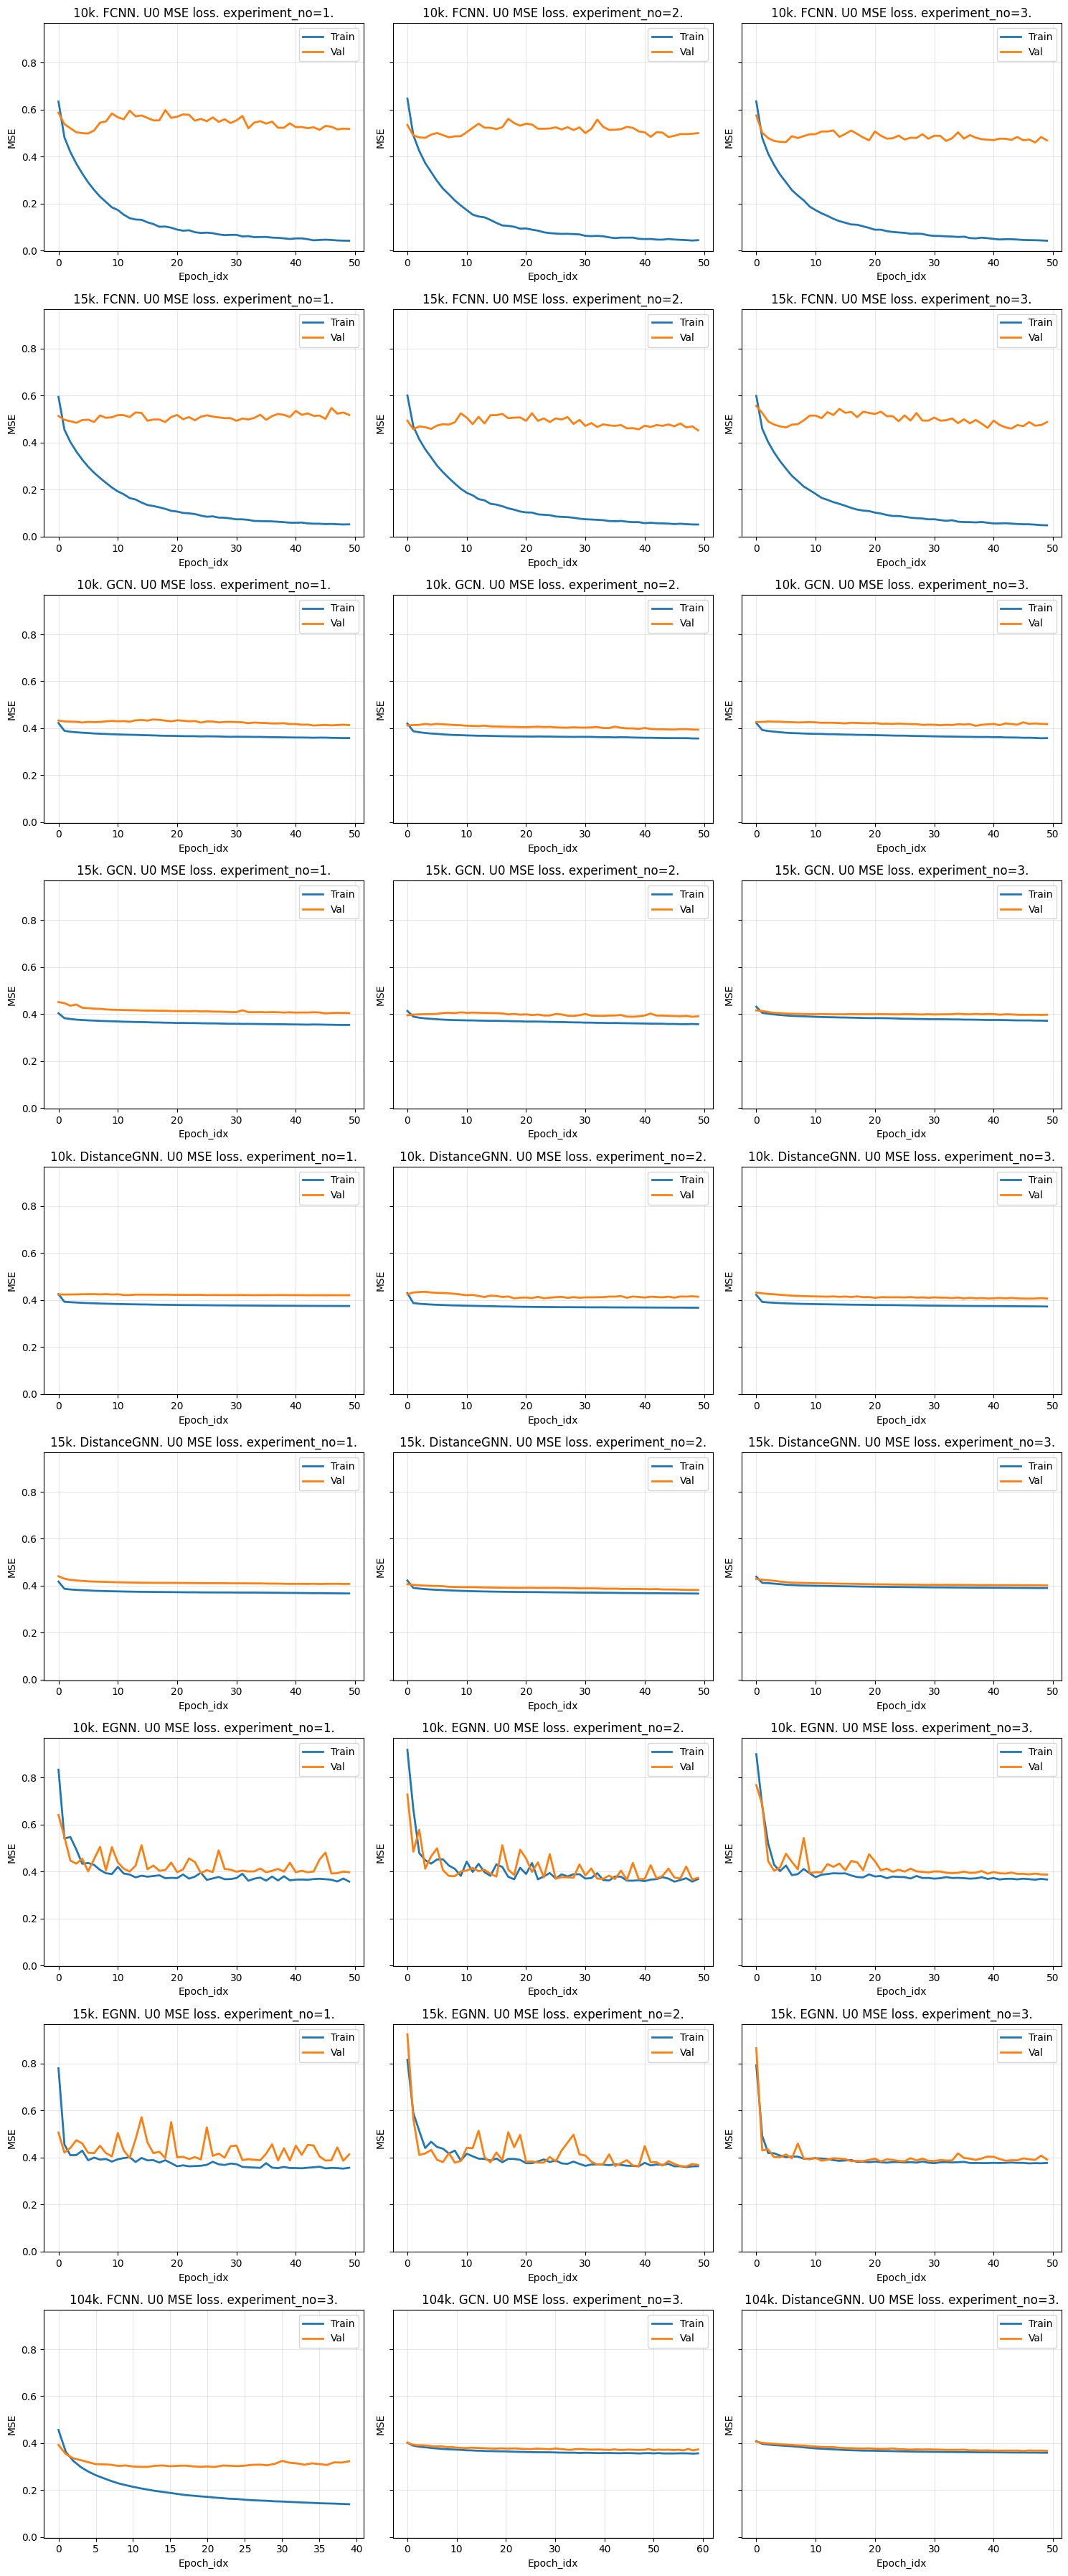

In [157]:
target_name = 'U0'
n=3
target_loss_dict = {}

for model_name in MODEL_NAMES:
  print(model_name)
  for train_size in [10000, 15000]:
    print(train_size)
    for experiment_no in range(1, n+1):
      ckpt_dir = f"/content/{model_name}_{target_name}_checkpoint_{train_size//1000}k"
      file_name = f'results_{model_name}_{target_name}_ex{experiment_no}.json'
      loss_dict = load_json_if_exists(ckpt_dir, file_name)
      losses = []
      for k in loss_dict.keys():
        losses.append(loss_dict[k])
      target_loss_dict[f'{train_size//1000}k. {model_name}. {target_name} MSE loss. experiment_no={experiment_no}.'] = tuple(losses)

for model_name in MODEL_NAMES[:-1]:
  ckpt_dir = f"/content/{model_name}_{target_name}_checkpoint_{104000//1000}k"
  file_name = f'results_{model_name}_{target_name}_ex{1}.json'
  loss_dict = load_json_if_exists(ckpt_dir, file_name)
  losses = []
  for k in loss_dict.keys():
    losses.append(loss_dict[k])
  target_loss_dict[f'{104000//1000}k. {model_name}. {target_name} MSE loss. experiment_no={experiment_no}.'] = tuple(losses)

plot_experiments_loss(target_loss_dict)

FCNN
10000
/content/FCNN_mu_checkpoint_10k/results_FCNN_mu_ex1.json
/content/FCNN_mu_checkpoint_10k/results_FCNN_mu_ex2.json
/content/FCNN_mu_checkpoint_10k/results_FCNN_mu_ex3.json
15000
/content/FCNN_mu_checkpoint_15k/results_FCNN_mu_ex1.json
/content/FCNN_mu_checkpoint_15k/results_FCNN_mu_ex2.json
/content/FCNN_mu_checkpoint_15k/results_FCNN_mu_ex3.json
GCN
10000
/content/GCN_mu_checkpoint_10k/results_GCN_mu_ex1.json
/content/GCN_mu_checkpoint_10k/results_GCN_mu_ex2.json
/content/GCN_mu_checkpoint_10k/results_GCN_mu_ex3.json
15000
/content/GCN_mu_checkpoint_15k/results_GCN_mu_ex1.json
/content/GCN_mu_checkpoint_15k/results_GCN_mu_ex2.json
/content/GCN_mu_checkpoint_15k/results_GCN_mu_ex3.json
DistanceGNN
10000
/content/DistanceGNN_mu_checkpoint_10k/results_DistanceGNN_mu_ex1.json
/content/DistanceGNN_mu_checkpoint_10k/results_DistanceGNN_mu_ex2.json
/content/DistanceGNN_mu_checkpoint_10k/results_DistanceGNN_mu_ex3.json
15000
/content/DistanceGNN_mu_checkpoint_15k/results_DistanceGNN

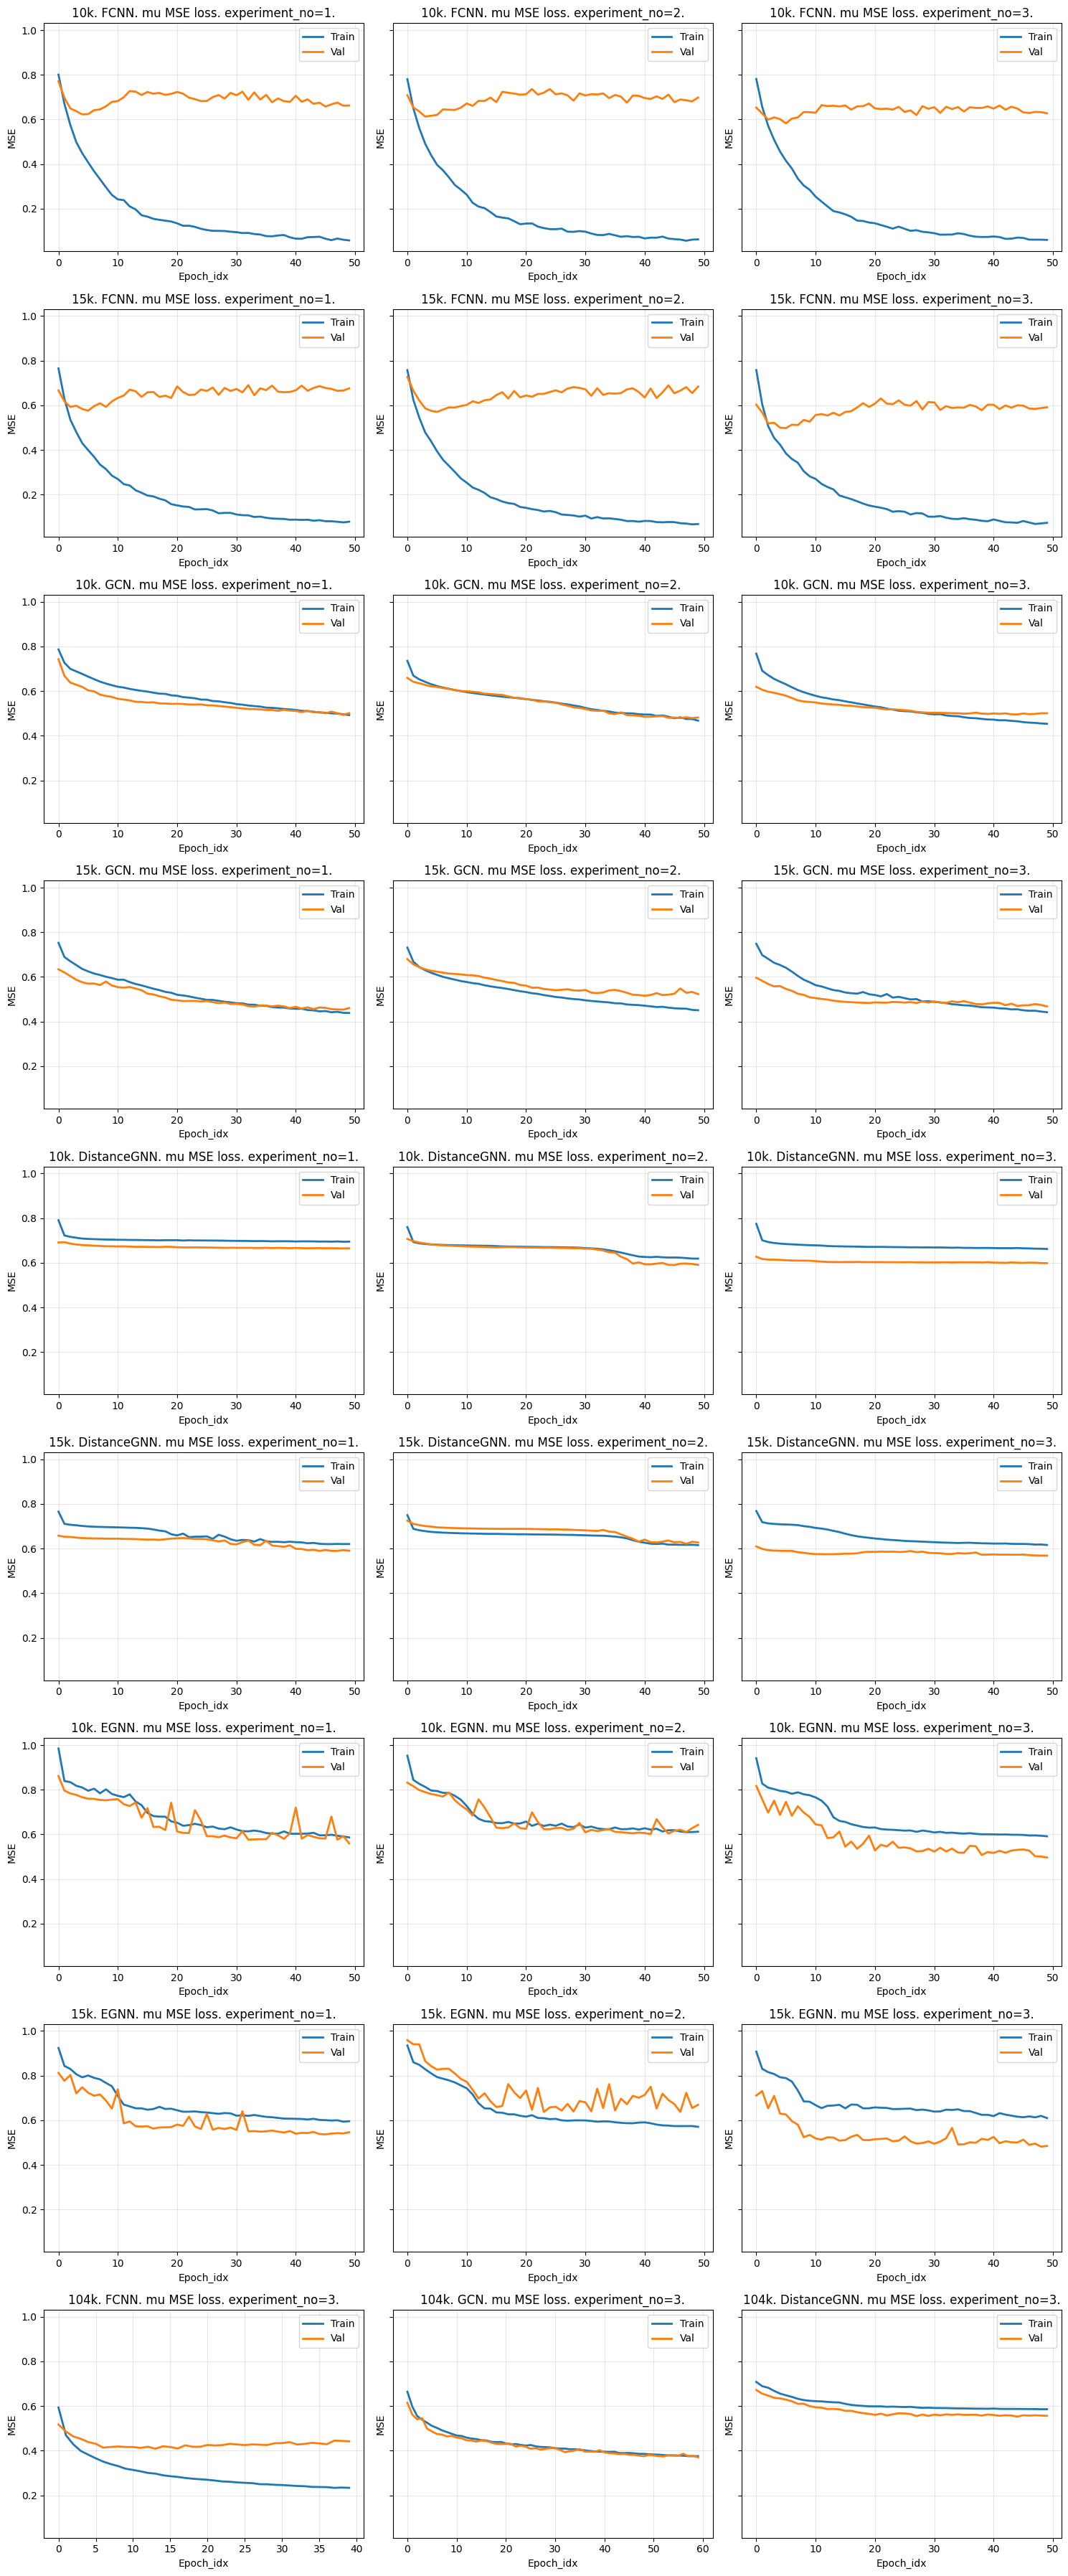

In [158]:
target_name = 'mu'
n=3
target_loss_dict = {}

for model_name in MODEL_NAMES:
  print(model_name)
  for train_size in [10000, 15000]:
    print(train_size)
    # target_loss_dict = {}
    for experiment_no in range(1, n+1):
      ckpt_dir = f"/content/{model_name}_{target_name}_checkpoint_{train_size//1000}k"
      file_name = f'results_{model_name}_{target_name}_ex{experiment_no}.json'
      loss_dict = load_json_if_exists(ckpt_dir, file_name)
      losses = []
      for k in loss_dict.keys():
        losses.append(loss_dict[k])
      target_loss_dict[f'{train_size//1000}k. {model_name}. {target_name} MSE loss. experiment_no={experiment_no}.'] = tuple(losses)

for model_name in MODEL_NAMES[:-1]:
  ckpt_dir = f"/content/{model_name}_{target_name}_checkpoint_{104000//1000}k"
  file_name = f'results_{model_name}_{target_name}_ex{1}.json'
  loss_dict = load_json_if_exists(ckpt_dir, file_name)
  losses = []
  for k in loss_dict.keys():
    losses.append(loss_dict[k])
  target_loss_dict[f'{104000//1000}k. {model_name}. {target_name} MSE loss. experiment_no={experiment_no}.'] = tuple(losses)

plot_experiments_loss(target_loss_dict)

FCNN
10000
/content/FCNN_U0_checkpoint_10k/results_FCNN_U0_ex1.json
/content/FCNN_U0_checkpoint_10k/results_FCNN_U0_ex2.json
/content/FCNN_U0_checkpoint_10k/results_FCNN_U0_ex3.json


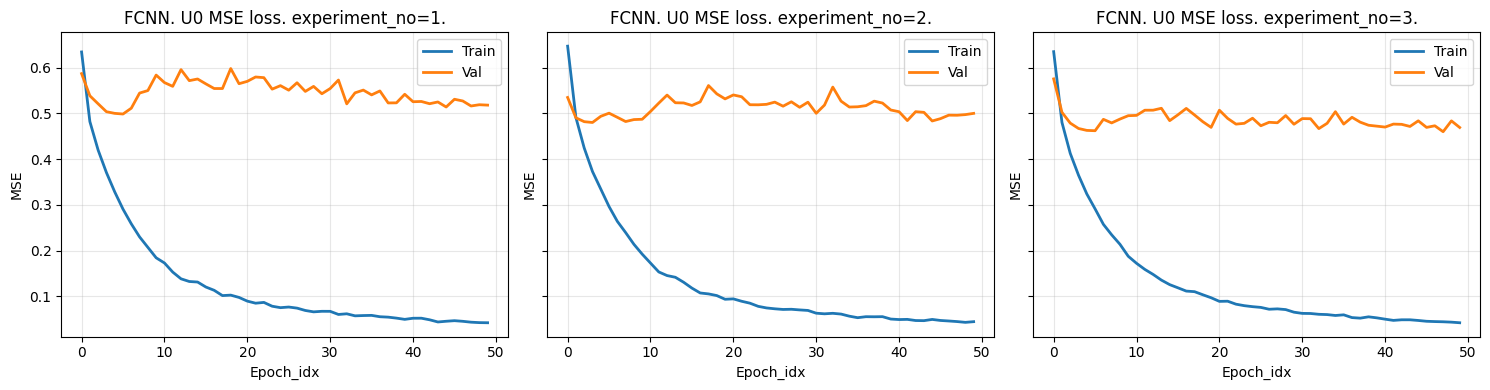

15000
/content/FCNN_U0_checkpoint_15k/results_FCNN_U0_ex1.json
/content/FCNN_U0_checkpoint_15k/results_FCNN_U0_ex2.json
/content/FCNN_U0_checkpoint_15k/results_FCNN_U0_ex3.json


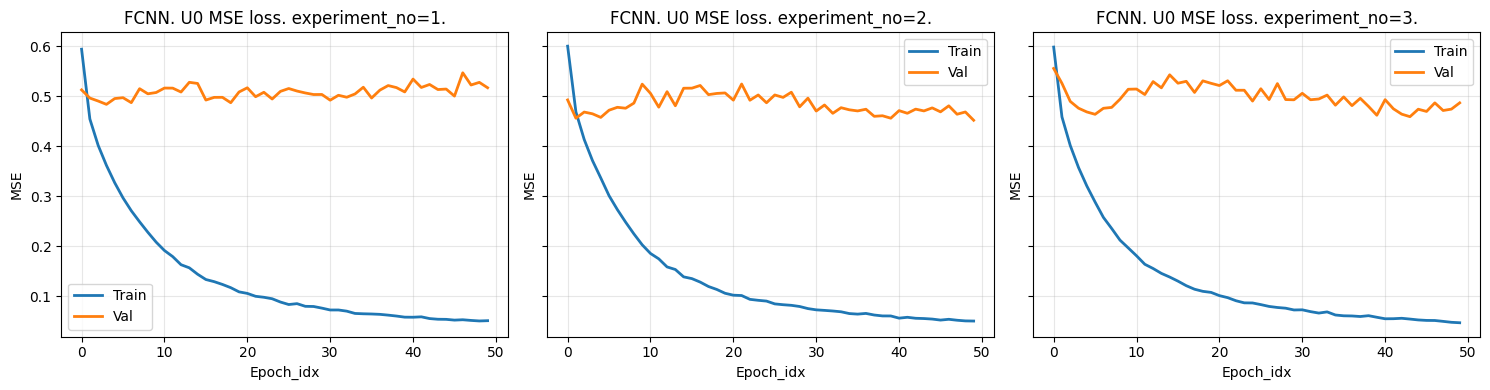

GCN
10000
/content/GCN_U0_checkpoint_10k/results_GCN_U0_ex1.json
/content/GCN_U0_checkpoint_10k/results_GCN_U0_ex2.json
/content/GCN_U0_checkpoint_10k/results_GCN_U0_ex3.json


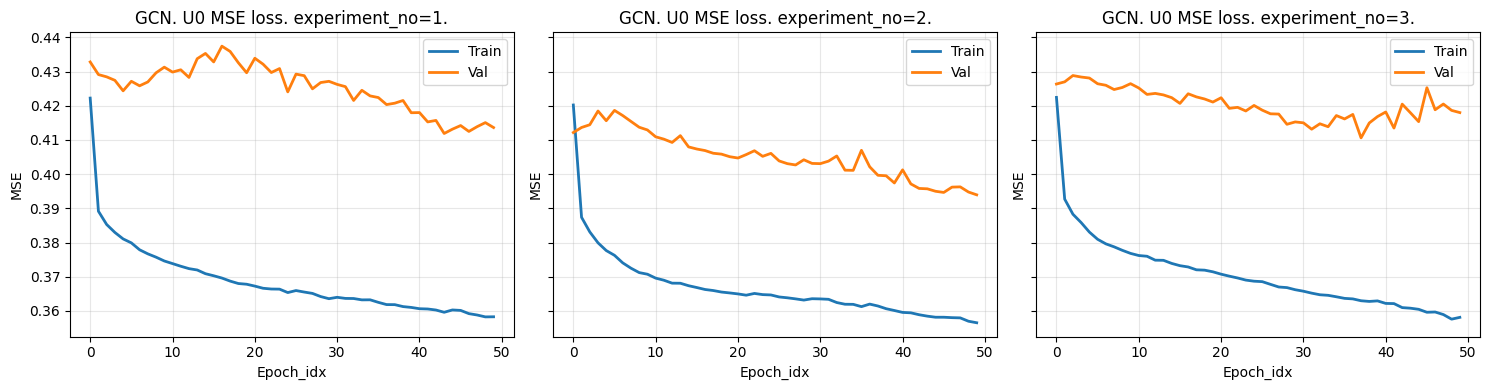

15000
/content/GCN_U0_checkpoint_15k/results_GCN_U0_ex1.json
/content/GCN_U0_checkpoint_15k/results_GCN_U0_ex2.json
/content/GCN_U0_checkpoint_15k/results_GCN_U0_ex3.json


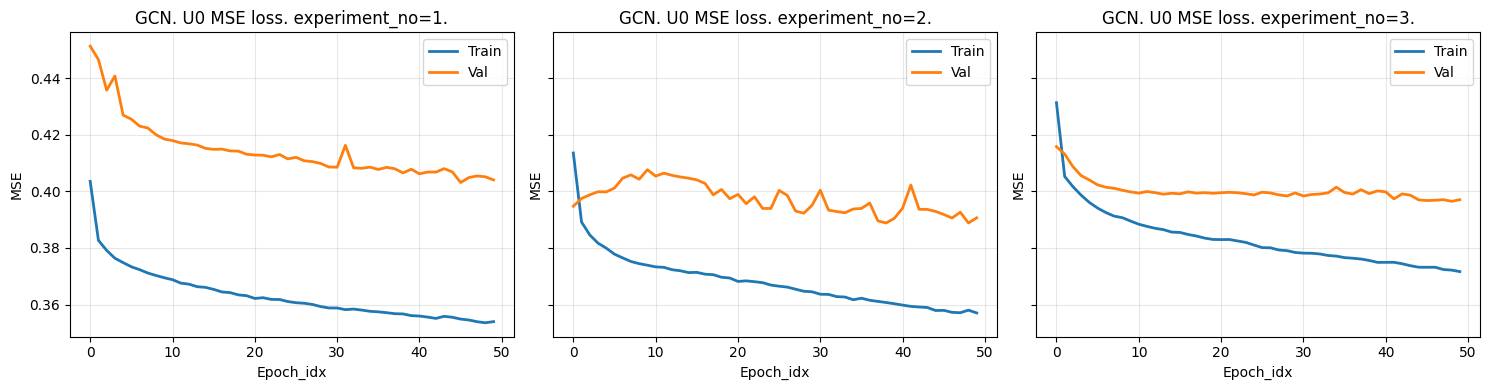

DistanceGNN
10000
/content/DistanceGNN_U0_checkpoint_10k/results_DistanceGNN_U0_ex1.json
/content/DistanceGNN_U0_checkpoint_10k/results_DistanceGNN_U0_ex2.json
/content/DistanceGNN_U0_checkpoint_10k/results_DistanceGNN_U0_ex3.json


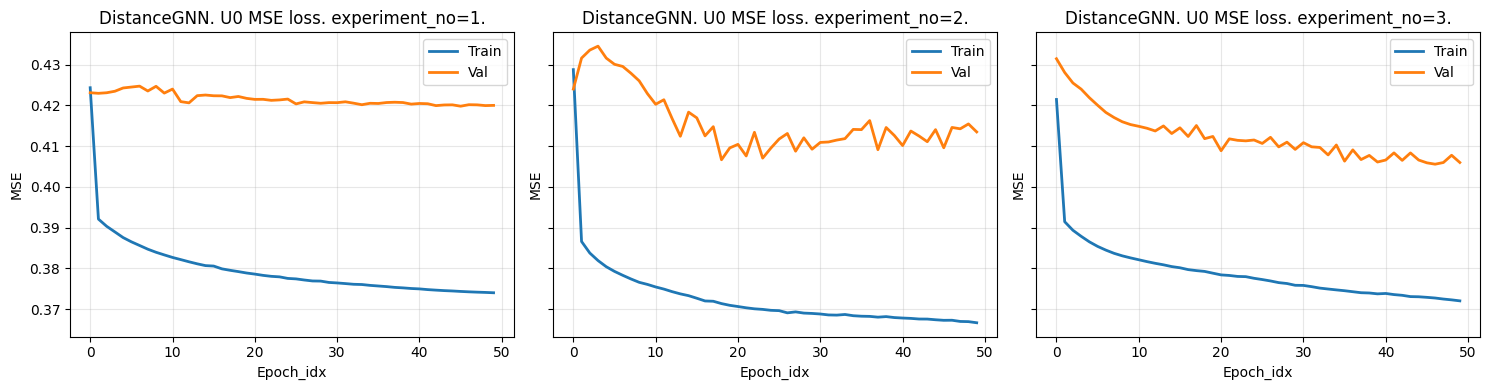

15000
/content/DistanceGNN_U0_checkpoint_15k/results_DistanceGNN_U0_ex1.json
/content/DistanceGNN_U0_checkpoint_15k/results_DistanceGNN_U0_ex2.json
/content/DistanceGNN_U0_checkpoint_15k/results_DistanceGNN_U0_ex3.json


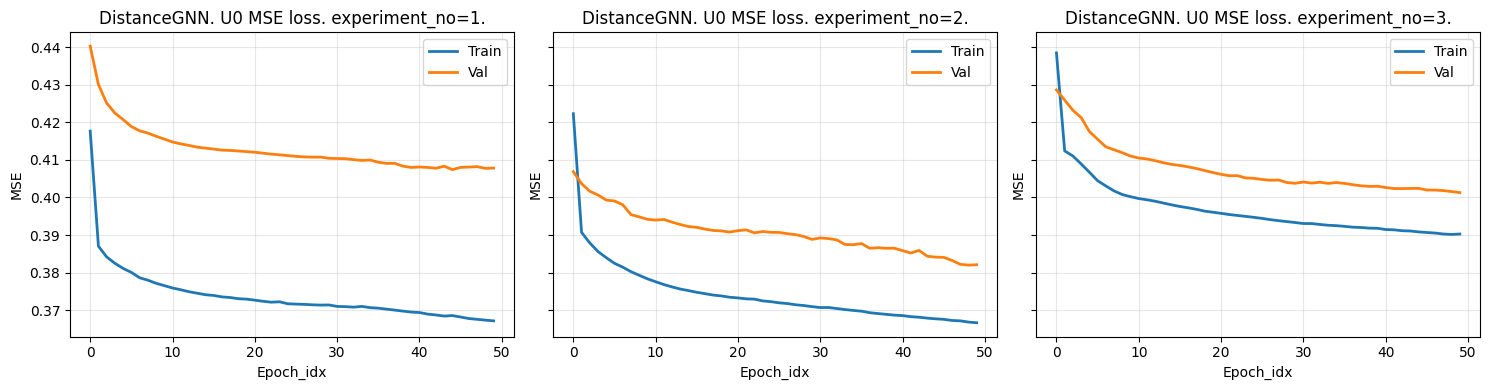

EGNN
10000
/content/EGNN_U0_checkpoint_10k/results_EGNN_U0_ex1.json
/content/EGNN_U0_checkpoint_10k/results_EGNN_U0_ex2.json
/content/EGNN_U0_checkpoint_10k/results_EGNN_U0_ex3.json


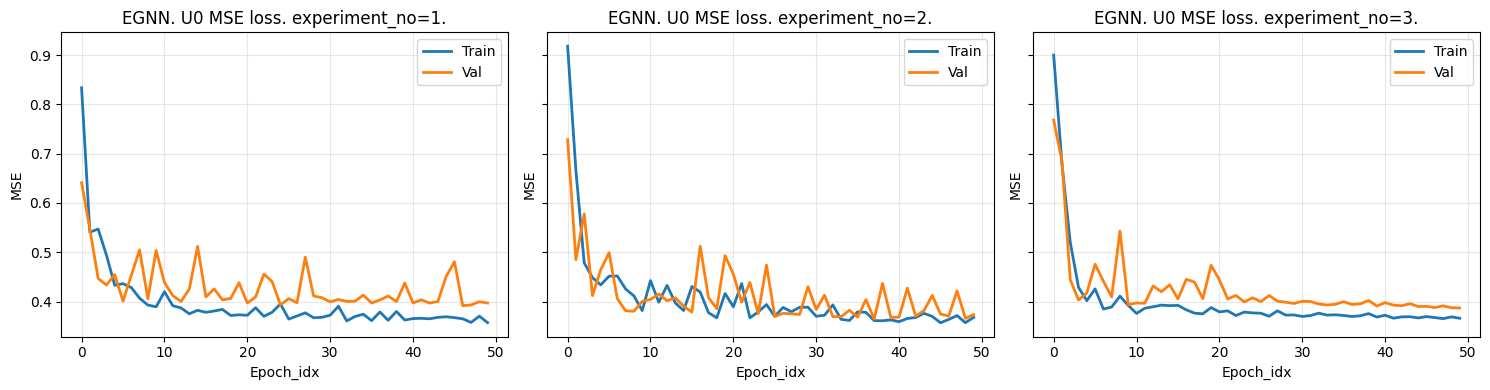

15000
/content/EGNN_U0_checkpoint_15k/results_EGNN_U0_ex1.json
/content/EGNN_U0_checkpoint_15k/results_EGNN_U0_ex2.json
/content/EGNN_U0_checkpoint_15k/results_EGNN_U0_ex3.json


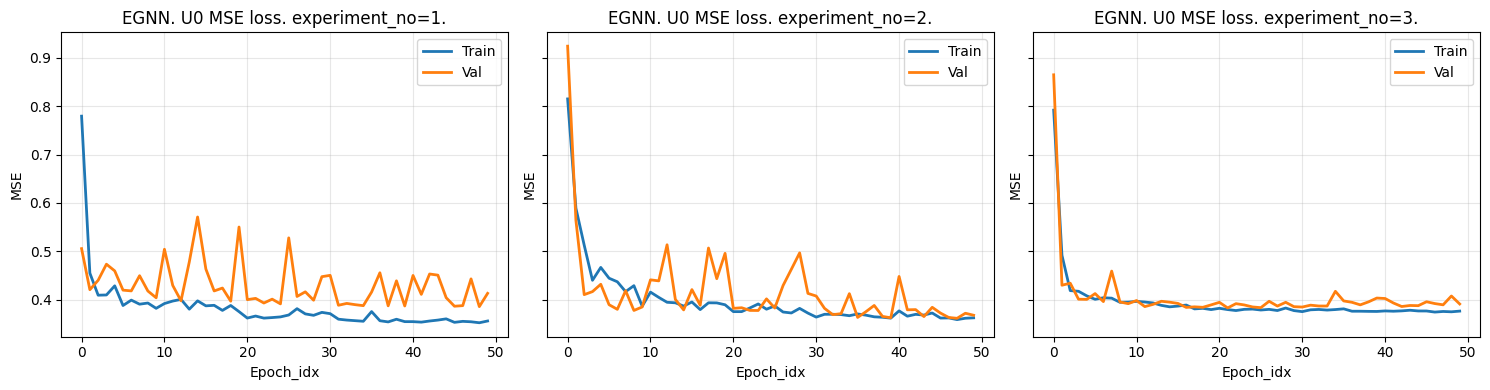

In [159]:
target_name = 'U0'
n=3

for model_name in MODEL_NAMES:
  print(model_name)
  for train_size in [10000, 15000]:
    print(train_size)
    target_loss_dict = {}
    for experiment_no in range(1, n+1):
      ckpt_dir = f"/content/{model_name}_{target_name}_checkpoint_{train_size//1000}k"
      file_name = f'results_{model_name}_{target_name}_ex{experiment_no}.json'
      loss_dict = load_json_if_exists(ckpt_dir, file_name)
      losses = []
      for k in loss_dict.keys():
        losses.append(loss_dict[k])
      target_loss_dict[f'{model_name}. {target_name} MSE loss. experiment_no={experiment_no}.'] = tuple(losses)
    plot_experiments_loss(target_loss_dict)

/content/FCNN_U0_checkpoint_104k/results_FCNN_U0_ex1.json
/content/GCN_U0_checkpoint_104k/results_GCN_U0_ex1.json
/content/DistanceGNN_U0_checkpoint_104k/results_DistanceGNN_U0_ex1.json


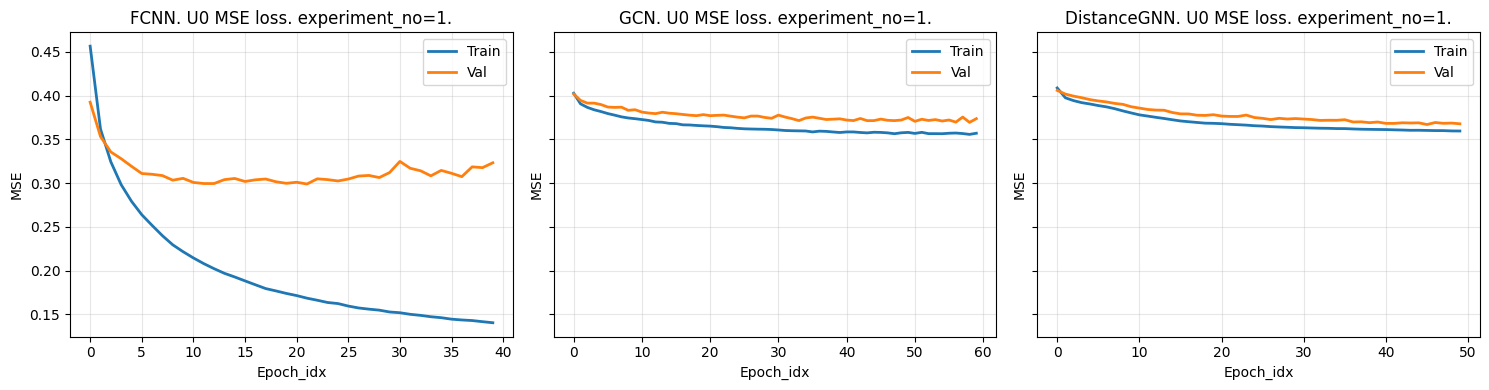

In [160]:
target_name = 'U0'
train_size = 104000
experiment_no = 1
target_loss_dict = {}

for model_name in MODEL_NAMES[:-1]:
  # print()
    ckpt_dir = f"/content/{model_name}_{target_name}_checkpoint_{train_size//1000}k"
    file_name = f'results_{model_name}_{target_name}_ex{experiment_no}.json'
    loss_dict = load_json_if_exists(ckpt_dir, file_name)
    losses = []
    for k in loss_dict.keys():
      losses.append(loss_dict[k])
    target_loss_dict[f'{model_name}. {target_name} MSE loss. experiment_no={experiment_no}.'] = tuple(losses)

plot_experiments_loss(target_loss_dict)

FCNN
10000
/content/FCNN_mu_checkpoint_10k/results_FCNN_mu_ex1.json
/content/FCNN_mu_checkpoint_10k/results_FCNN_mu_ex2.json
/content/FCNN_mu_checkpoint_10k/results_FCNN_mu_ex3.json


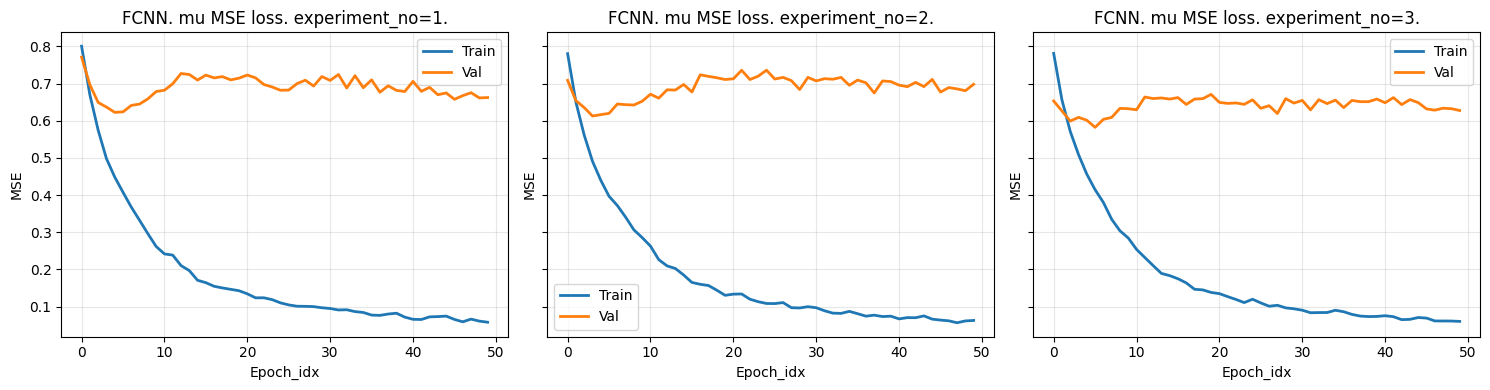

15000
/content/FCNN_mu_checkpoint_15k/results_FCNN_mu_ex1.json
/content/FCNN_mu_checkpoint_15k/results_FCNN_mu_ex2.json
/content/FCNN_mu_checkpoint_15k/results_FCNN_mu_ex3.json


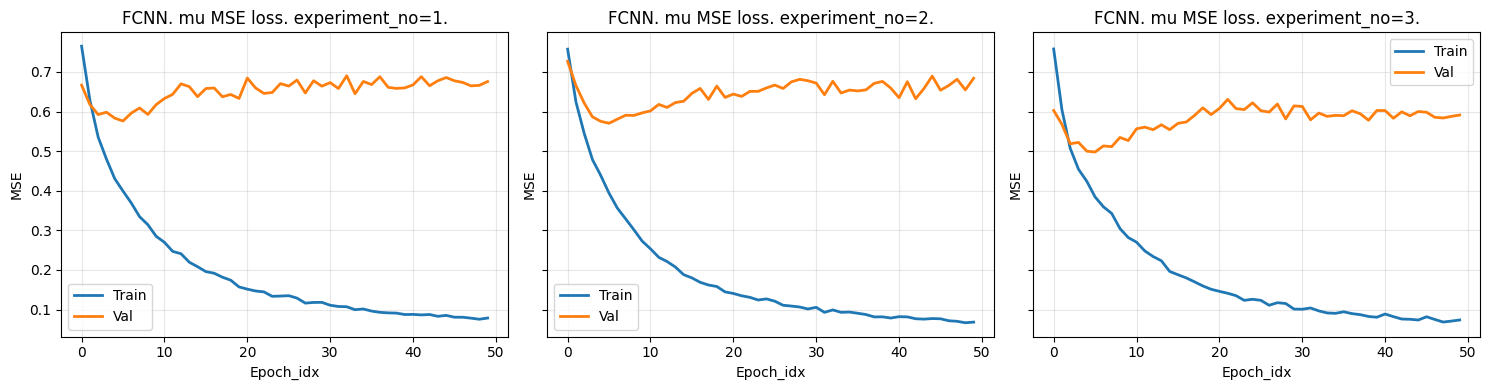

GCN
10000
/content/GCN_mu_checkpoint_10k/results_GCN_mu_ex1.json
/content/GCN_mu_checkpoint_10k/results_GCN_mu_ex2.json
/content/GCN_mu_checkpoint_10k/results_GCN_mu_ex3.json


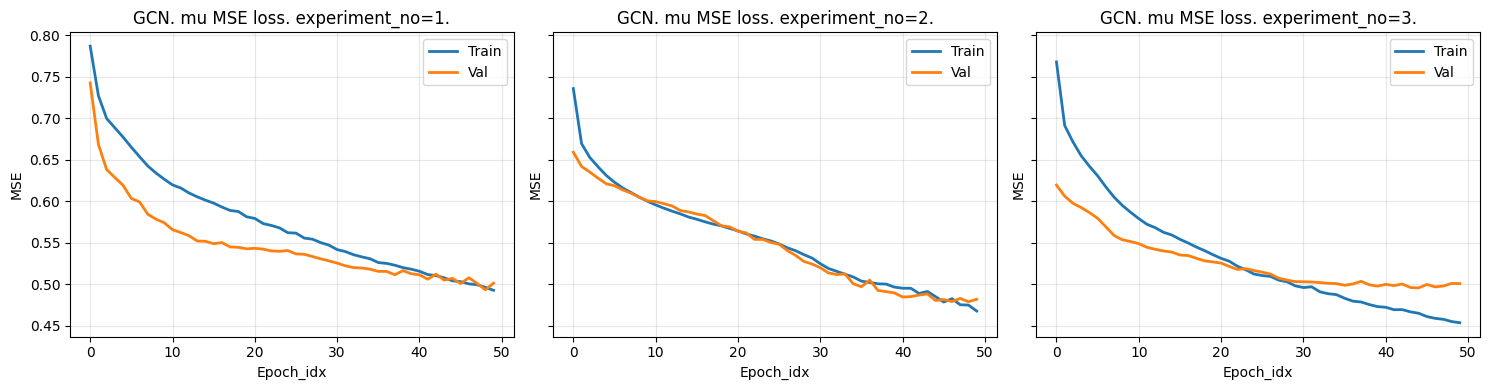

15000
/content/GCN_mu_checkpoint_15k/results_GCN_mu_ex1.json
/content/GCN_mu_checkpoint_15k/results_GCN_mu_ex2.json
/content/GCN_mu_checkpoint_15k/results_GCN_mu_ex3.json


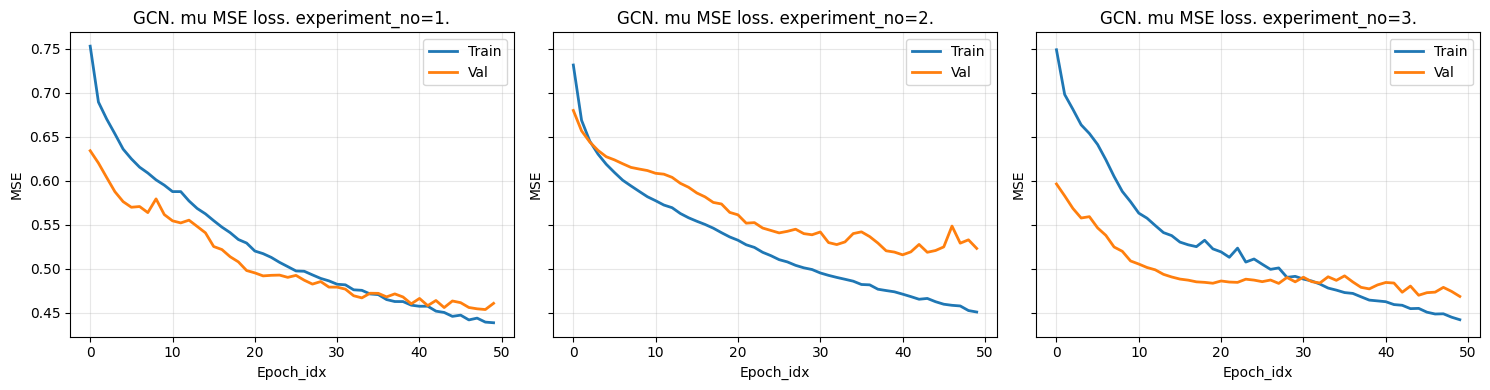

DistanceGNN
10000
/content/DistanceGNN_mu_checkpoint_10k/results_DistanceGNN_mu_ex1.json
/content/DistanceGNN_mu_checkpoint_10k/results_DistanceGNN_mu_ex2.json
/content/DistanceGNN_mu_checkpoint_10k/results_DistanceGNN_mu_ex3.json


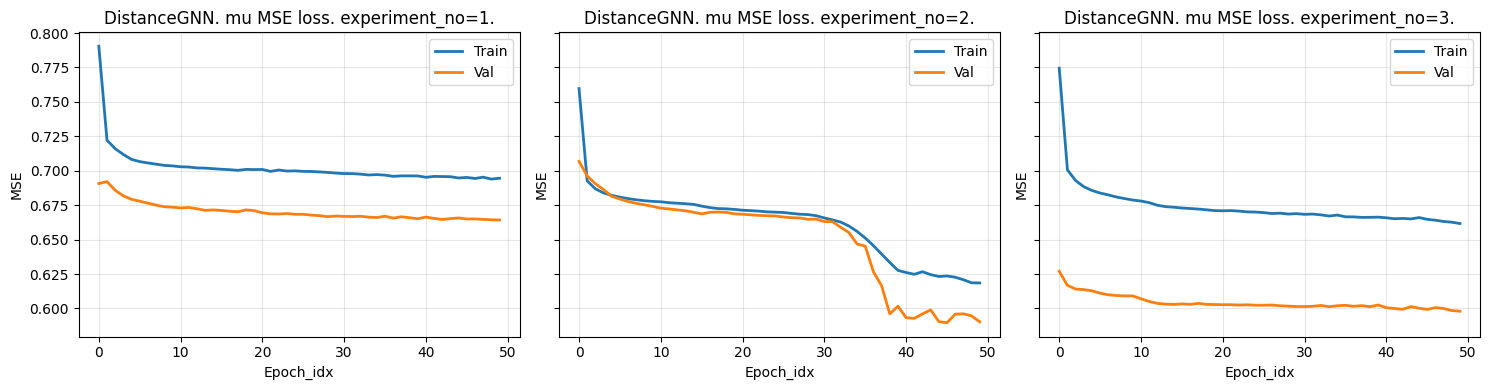

15000
/content/DistanceGNN_mu_checkpoint_15k/results_DistanceGNN_mu_ex1.json
/content/DistanceGNN_mu_checkpoint_15k/results_DistanceGNN_mu_ex2.json
/content/DistanceGNN_mu_checkpoint_15k/results_DistanceGNN_mu_ex3.json


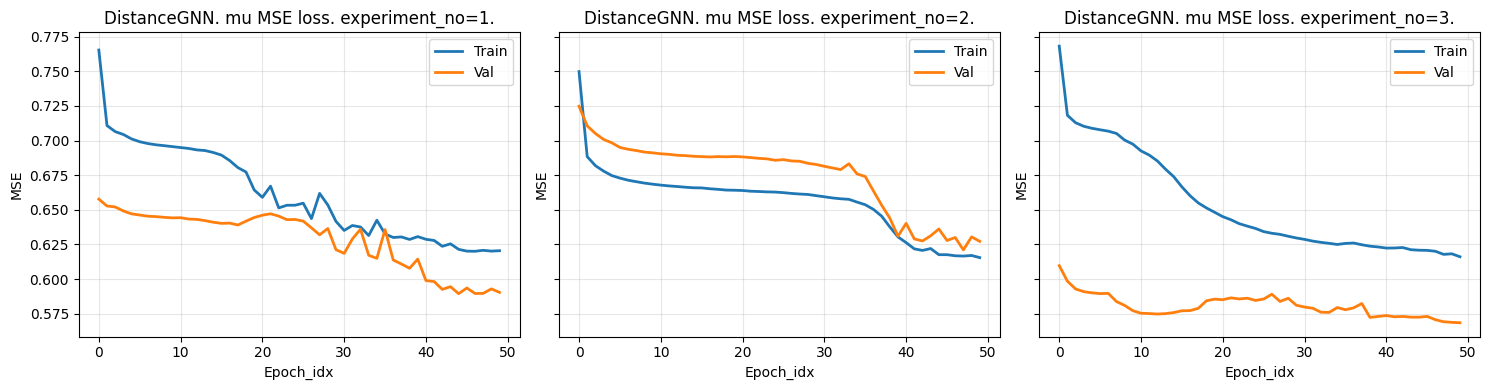

EGNN
10000
/content/EGNN_mu_checkpoint_10k/results_EGNN_mu_ex1.json
/content/EGNN_mu_checkpoint_10k/results_EGNN_mu_ex2.json
/content/EGNN_mu_checkpoint_10k/results_EGNN_mu_ex3.json


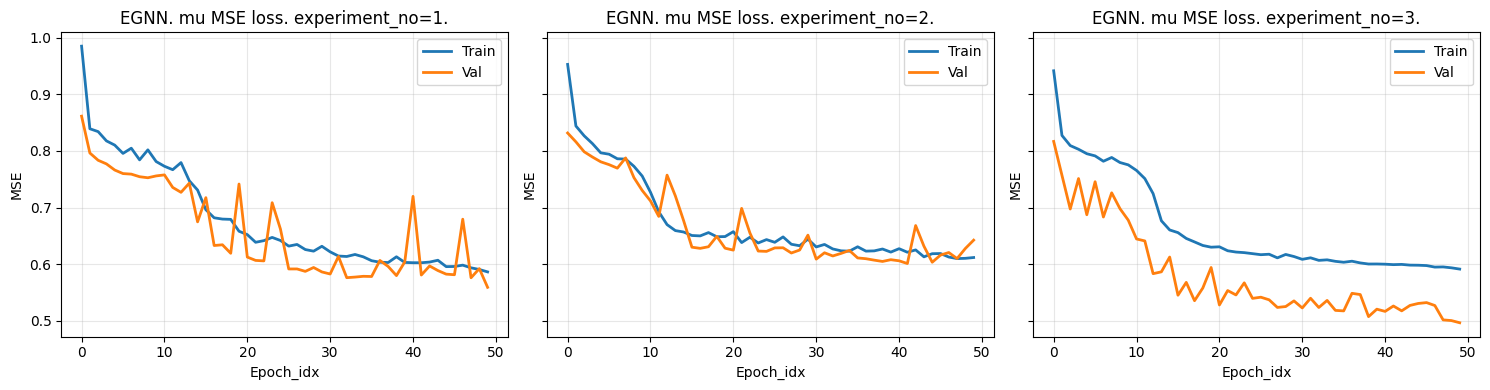

15000
/content/EGNN_mu_checkpoint_15k/results_EGNN_mu_ex1.json
/content/EGNN_mu_checkpoint_15k/results_EGNN_mu_ex2.json
/content/EGNN_mu_checkpoint_15k/results_EGNN_mu_ex3.json


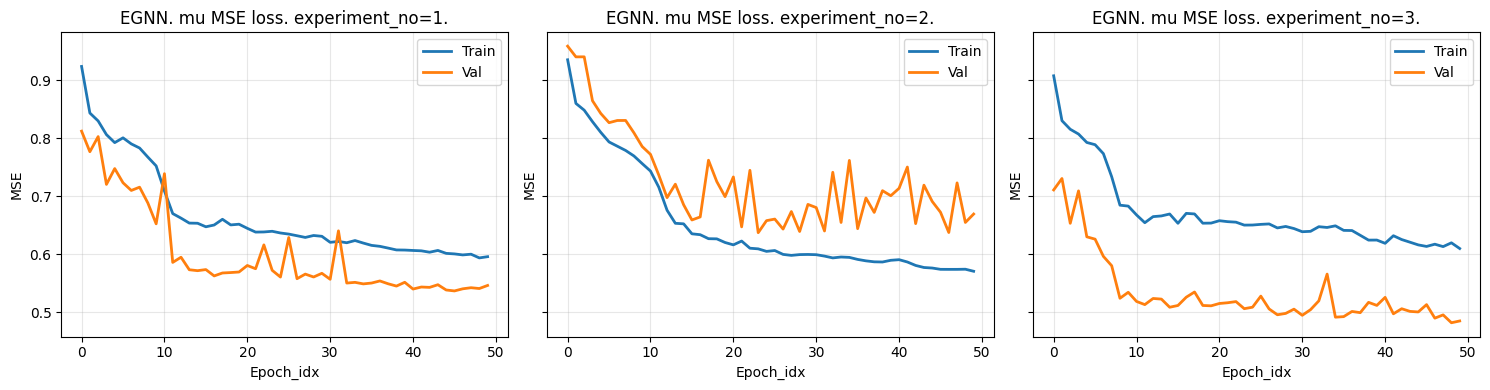

In [161]:
target_name = 'mu'
n=3

for model_name in MODEL_NAMES:
  print(model_name)
  for train_size in [10000, 15000]:
    print(train_size)
    target_loss_dict = {}
    for experiment_no in range(1, n+1):
      ckpt_dir = f"/content/{model_name}_{target_name}_checkpoint_{train_size//1000}k"
      file_name = f'results_{model_name}_{target_name}_ex{experiment_no}.json'
      loss_dict = load_json_if_exists(ckpt_dir, file_name)
      losses = []
      for k in loss_dict.keys():
        losses.append(loss_dict[k])
      target_loss_dict[f'{model_name}. {target_name} MSE loss. experiment_no={experiment_no}.'] = tuple(losses)
    plot_experiments_loss(target_loss_dict)

/content/FCNN_mu_checkpoint_104k/results_FCNN_mu_ex1.json
/content/GCN_mu_checkpoint_104k/results_GCN_mu_ex1.json
/content/DistanceGNN_mu_checkpoint_104k/results_DistanceGNN_mu_ex1.json


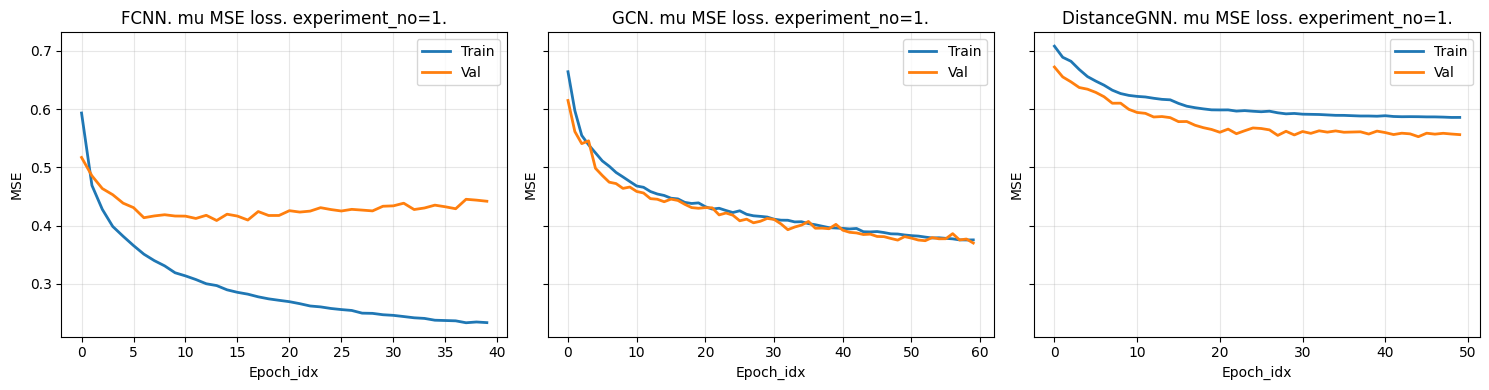

In [ ]:
target_name = 'mu'
train_size = 104000
experiment_no = 1
target_loss_dict = {}

for model_name in MODEL_NAMES[:-1]:
  # print()
    ckpt_dir = f"/content/{model_name}_{target_name}_checkpoint_{train_size//1000}k"
    file_name = f'results_{model_name}_{target_name}_ex{experiment_no}.json'
    loss_dict = load_json_if_exists(ckpt_dir, file_name)
    losses = []
    for k in loss_dict.keys():
      losses.append(loss_dict[k])
    target_loss_dict[f'{model_name}. {target_name} MSE loss. experiment_no={experiment_no}.'] = tuple(losses)

plot_experiments_loss(target_loss_dict)

FCNN - быстро наступает переобучение. Даже значительное увеличение размеров тренировочного датасета не меняет общей картины. Кривые обучения очень имеют схожий вид для разных таргетов и размеров датасета.

GCN, DistanceGNN - вид кривых обучения сильно зависит от размера датасета, эксперимента (разные наборы train-val) - т.е. 10к и 15к - слишком маленькие для получения хороших результатов по этим моделям.

EGNN - на результат больше влияет выбор датасета, чем его размер. Высокая скорость обучения.

# -- Test MSE. Таблицы

In [188]:
# load results into dict for table 'model-target'

model_name = 'FCNN'

target_name = 'U0'
fcnn_U0_mse_dict, fcnn_U0_size_dict = get_data_for_losses_table(model_name, target_name, TRAIN_SIZES)
df_fcnn_U0_mse = pd.DataFrame.from_dict(fcnn_U0_mse_dict)

target_name = 'mu'
fcnn_mu_mse_dict, fcnn_mu_size_dict  = get_data_for_losses_table(model_name, target_name, TRAIN_SIZES)
df_fcnn_mu_mse = pd.DataFrame.from_dict(fcnn_mu_mse_dict)

get_data_for_losses_table(model_name, target_name, train_sizes, n=3)
/content/FCNN_U0_checkpoint_10k/mse_results_FCNN_U0_ex1.json
/content/FCNN_U0_checkpoint_10k/mse_results_FCNN_U0_ex2.json
/content/FCNN_U0_checkpoint_10k/mse_results_FCNN_U0_ex3.json
/content/FCNN_U0_checkpoint_15k/mse_results_FCNN_U0_ex1.json
/content/FCNN_U0_checkpoint_15k/mse_results_FCNN_U0_ex2.json
/content/FCNN_U0_checkpoint_15k/mse_results_FCNN_U0_ex3.json
/content/FCNN_U0_checkpoint_104k/mse_results_FCNN_U0_ex1.json
/content/FCNN_U0_checkpoint_104k/mse_results_FCNN_U0_ex2.json
/content/FCNN_U0_checkpoint_104k/mse_results_FCNN_U0_ex2.json  not found !!!
/content/FCNN_U0_checkpoint_104k/mse_results_FCNN_U0_ex3.json
/content/FCNN_U0_checkpoint_104k/mse_results_FCNN_U0_ex3.json  not found !!!
get_data_for_losses_table(model_name, target_name, train_sizes, n=3)
/content/FCNN_mu_checkpoint_10k/mse_results_FCNN_mu_ex1.json
/content/FCNN_mu_checkpoint_10k/mse_results_FCNN_mu_ex2.json
/content/FCNN_mu_checkpoint_10k/ms

In [189]:
df_fcnn_U0_mse

Train size Experiment no                      Test MSE on TEST_SIZE=1500  \
0        10k             1  0.52, 0.53, 0.44, 0.45, 0.45, 0.42, 0.45, 0.47   
1        10k             2  0.51, 0.50, 0.48, 0.47, 0.42, 0.43, 0.43, 0.49   
2        10k             3  0.53, 0.51, 0.48, 0.51, 0.44, 0.47, 0.48, 0.48   
3        15k             1  0.48, 0.50, 0.41, 0.43, 0.41, 0.38, 0.41, 0.45   
4        15k             2  0.53, 0.49, 0.44, 0.49, 0.40, 0.42, 0.44, 0.48   
5        15k             3  0.47, 0.51, 0.44, 0.44, 0.45, 0.45, 0.46, 0.51   
6       104k             1  0.33, 0.31, 0.30, 0.33, 0.30, 0.30, 0.28, 0.33   

  Test MSE, mean +/- std Test MSE on full test set (13k)  
0          0.47 +/- 0.04                           0.464  
1          0.47 +/- 0.03                           0.465  
2          0.49 +/- 0.03                           0.486  
3          0.43 +/- 0.04                           0.433  
4          0.46 +/- 0.04                           0.463  
5          0.47 +/- 0.03                           0.464  
6          0.31 +/- 0.02                           0.312

In [190]:
df_fcnn_mu_mse

Train size Experiment no                      Test MSE on TEST_SIZE=1500  \
0        10k             1  0.61, 0.62, 0.72, 0.70, 0.58, 0.59, 0.57, 0.60   
1        10k             2  0.63, 0.61, 0.69, 0.67, 0.56, 0.57, 0.57, 0.57   
2        10k             3  0.59, 0.66, 0.70, 0.60, 0.59, 0.58, 0.60, 0.59   
3        15k             1  0.56, 0.56, 0.62, 0.55, 0.54, 0.52, 0.54, 0.52   
4        15k             2  0.49, 0.58, 0.60, 0.51, 0.48, 0.49, 0.50, 0.49   
5        15k             3  0.49, 0.49, 0.60, 0.49, 0.51, 0.49, 0.46, 0.49   
6       104k             1  0.37, 0.39, 0.48, 0.38, 0.40, 0.42, 0.40, 0.37   

  Test MSE, mean +/- std Test MSE on full test set (13k)  
0          0.62 +/- 0.05                           0.622  
1          0.61 +/- 0.05                           0.610  
2          0.61 +/- 0.04                           0.619  
3          0.55 +/- 0.03                           0.550  
4          0.52 +/- 0.04                           0.522  
5          0.50 +/- 0.04                           0.503  
6          0.40 +/- 0.03                           0.401

In [191]:
model_name = "GCN"

target_name = 'U0'
gcn_U0_mse_dict, gcn_U0_size_dict = get_data_for_losses_table(model_name, target_name, TRAIN_SIZES)
df_gcn_U0_mse = pd.DataFrame.from_dict(gcn_U0_mse_dict)

target_name = 'mu'
gcn_mu_mse_dict, gcn_mu_size_dict = get_data_for_losses_table(model_name, target_name, TRAIN_SIZES)
df_gcn_mu_mse = pd.DataFrame.from_dict(gcn_mu_mse_dict)

get_data_for_losses_table(model_name, target_name, train_sizes, n=3)
/content/GCN_U0_checkpoint_10k/mse_results_GCN_U0_ex1.json
/content/GCN_U0_checkpoint_10k/mse_results_GCN_U0_ex2.json
/content/GCN_U0_checkpoint_10k/mse_results_GCN_U0_ex3.json
/content/GCN_U0_checkpoint_15k/mse_results_GCN_U0_ex1.json
/content/GCN_U0_checkpoint_15k/mse_results_GCN_U0_ex2.json
/content/GCN_U0_checkpoint_15k/mse_results_GCN_U0_ex3.json
/content/GCN_U0_checkpoint_104k/mse_results_GCN_U0_ex1.json
/content/GCN_U0_checkpoint_104k/mse_results_GCN_U0_ex2.json
/content/GCN_U0_checkpoint_104k/mse_results_GCN_U0_ex2.json  not found !!!
/content/GCN_U0_checkpoint_104k/mse_results_GCN_U0_ex3.json
/content/GCN_U0_checkpoint_104k/mse_results_GCN_U0_ex3.json  not found !!!
get_data_for_losses_table(model_name, target_name, train_sizes, n=3)
/content/GCN_mu_checkpoint_10k/mse_results_GCN_mu_ex1.json
/content/GCN_mu_checkpoint_10k/mse_results_GCN_mu_ex2.json
/content/GCN_mu_checkpoint_10k/mse_results_GCN_mu_ex3.json
/

In [192]:
df_gcn_U0_mse

Train size Experiment no                      Test MSE on TEST_SIZE=1500  \
0        10k             1  0.37, 0.40, 0.33, 0.41, 0.36, 0.36, 0.28, 0.39   
1        10k             2  0.37, 0.41, 0.33, 0.43, 0.36, 0.36, 0.29, 0.39   
2        10k             3  0.36, 0.40, 0.33, 0.41, 0.37, 0.36, 0.28, 0.39   
3        15k             1  0.36, 0.40, 0.32, 0.41, 0.35, 0.35, 0.28, 0.39   
4        15k             2  0.37, 0.40, 0.33, 0.41, 0.36, 0.35, 0.28, 0.40   
5        15k             3  0.35, 0.40, 0.32, 0.40, 0.36, 0.35, 0.28, 0.38   
6       104k             1  0.33, 0.39, 0.29, 0.38, 0.33, 0.34, 0.27, 0.37   

  Test MSE, mean +/- std Test MSE on full test set (13k)  
0          0.36 +/- 0.04                           0.358  
1          0.37 +/- 0.04                           0.363  
2          0.36 +/- 0.04                           0.357  
3          0.36 +/- 0.04                           0.352  
4          0.36 +/- 0.04                           0.357  
5          0.35 +/- 0.04                           0.349  
6          0.34 +/- 0.04                           0.335

In [193]:
df_gcn_mu_mse

Train size Experiment no                      Test MSE on TEST_SIZE=1500  \
0        10k             1  0.50, 0.49, 0.59, 0.59, 0.54, 0.53, 0.50, 0.55   
1        10k             2  0.45, 0.45, 0.52, 0.52, 0.48, 0.48, 0.44, 0.49   
2        10k             3  0.45, 0.48, 0.51, 0.55, 0.51, 0.49, 0.49, 0.53   
3        15k             1  0.47, 0.45, 0.51, 0.53, 0.49, 0.49, 0.45, 0.51   
4        15k             2  0.47, 0.47, 0.51, 0.52, 0.51, 0.48, 0.47, 0.50   
5        15k             3  0.47, 0.50, 0.52, 0.52, 0.52, 0.50, 0.48, 0.48   
6       104k             1  0.36, 0.38, 0.40, 0.39, 0.39, 0.36, 0.40, 0.38   

  Test MSE, mean +/- std Test MSE on full test set (13k)  
0          0.54 +/- 0.04                           0.534  
1          0.48 +/- 0.03                           0.477  
2          0.50 +/- 0.03                           0.503  
3          0.49 +/- 0.03                           0.487  
4          0.49 +/- 0.02                           0.493  
5          0.50 +/- 0.02                           0.496  
6          0.38 +/- 0.02                           0.380

In [194]:
model_name = "DistanceGNN"

target_name = 'U0'
gnn_U0_mse_dict, gnn_U0_size_dict = get_data_for_losses_table(model_name, target_name, TRAIN_SIZES)
df_gnn_U0_mse = pd.DataFrame.from_dict(gnn_U0_mse_dict)

target_name = 'mu'
gnn_mu_mse_dict, gnn_mu_size_dict = get_data_for_losses_table(model_name, target_name, TRAIN_SIZES)
df_gnn_mu_mse = pd.DataFrame.from_dict(gnn_mu_mse_dict)

get_data_for_losses_table(model_name, target_name, train_sizes, n=3)
/content/DistanceGNN_U0_checkpoint_10k/mse_results_DistanceGNN_U0_ex1.json
/content/DistanceGNN_U0_checkpoint_10k/mse_results_DistanceGNN_U0_ex2.json
/content/DistanceGNN_U0_checkpoint_10k/mse_results_DistanceGNN_U0_ex3.json
/content/DistanceGNN_U0_checkpoint_15k/mse_results_DistanceGNN_U0_ex1.json
/content/DistanceGNN_U0_checkpoint_15k/mse_results_DistanceGNN_U0_ex2.json
/content/DistanceGNN_U0_checkpoint_15k/mse_results_DistanceGNN_U0_ex3.json
/content/DistanceGNN_U0_checkpoint_104k/mse_results_DistanceGNN_U0_ex1.json
/content/DistanceGNN_U0_checkpoint_104k/mse_results_DistanceGNN_U0_ex2.json
/content/DistanceGNN_U0_checkpoint_104k/mse_results_DistanceGNN_U0_ex2.json  not found !!!
/content/DistanceGNN_U0_checkpoint_104k/mse_results_DistanceGNN_U0_ex3.json
/content/DistanceGNN_U0_checkpoint_104k/mse_results_DistanceGNN_U0_ex3.json  not found !!!
get_data_for_losses_table(model_name, target_name, train_sizes, n=3)
/c

In [195]:
df_gnn_U0_mse

Train size Experiment no                      Test MSE on TEST_SIZE=1500  \
0        10k             1  0.37, 0.41, 0.34, 0.42, 0.39, 0.35, 0.29, 0.39   
1        10k             2  0.38, 0.41, 0.35, 0.43, 0.39, 0.36, 0.30, 0.40   
2        10k             3  0.36, 0.40, 0.33, 0.41, 0.37, 0.35, 0.28, 0.38   
3        15k             1  0.36, 0.40, 0.34, 0.42, 0.38, 0.35, 0.28, 0.39   
4        15k             2  0.36, 0.39, 0.33, 0.40, 0.37, 0.34, 0.28, 0.38   
5        15k             3  0.36, 0.40, 0.33, 0.41, 0.37, 0.35, 0.29, 0.38   
6       104k             1  0.33, 0.37, 0.30, 0.38, 0.34, 0.33, 0.27, 0.36   

  Test MSE, mean +/- std Test MSE on full test set (13k)  
0          0.37 +/- 0.04                           0.368  
1          0.38 +/- 0.04                           0.371  
2          0.36 +/- 0.04                           0.357  
3          0.36 +/- 0.04                           0.360  
4          0.36 +/- 0.04                           0.353  
5          0.36 +/- 0.04                           0.356  
6          0.34 +/- 0.03                           0.333

In [196]:
df_gnn_mu_mse

Train size Experiment no                      Test MSE on TEST_SIZE=1500  \
0        10k             1  0.75, 0.69, 0.73, 0.76, 0.64, 0.64, 0.64, 0.66   
1        10k             2  0.56, 0.59, 0.58, 0.65, 0.59, 0.60, 0.58, 0.57   
2        10k             3  0.71, 0.66, 0.68, 0.74, 0.62, 0.63, 0.61, 0.63   
3        15k             1  0.56, 0.59, 0.60, 0.68, 0.60, 0.62, 0.60, 0.62   
4        15k             2  0.58, 0.60, 0.60, 0.67, 0.62, 0.61, 0.60, 0.60   
5        15k             3  0.55, 0.58, 0.59, 0.66, 0.58, 0.59, 0.57, 0.58   
6       104k             1  0.53, 0.56, 0.62, 0.65, 0.56, 0.60, 0.57, 0.58   

  Test MSE, mean +/- std Test MSE on full test set (13k)  
0          0.69 +/- 0.05                           0.692  
1          0.59 +/- 0.03                           0.591  
2          0.66 +/- 0.04                           0.663  
3          0.61 +/- 0.03                           0.610  
4          0.61 +/- 0.03                           0.612  
5          0.59 +/- 0.03                           0.589  
6          0.58 +/- 0.04                           0.583

In [197]:
model_name = "EGNN"

target_name = 'U0'
egnn_U0_mse_dict, egnn_U0_size_dict = get_data_for_losses_table(model_name, target_name, TRAIN_SIZES)
df_egnn_U0_mse = pd.DataFrame.from_dict(egnn_U0_mse_dict)

target_name = 'mu'
egnn_mu_mse_dict, egnn_mu_size_dict = get_data_for_losses_table(model_name, target_name, TRAIN_SIZES)
df_egnn_mu_mse = pd.DataFrame.from_dict(egnn_mu_mse_dict)

get_data_for_losses_table(model_name, target_name, train_sizes, n=3)
/content/EGNN_U0_checkpoint_10k/mse_results_EGNN_U0_ex1.json
/content/EGNN_U0_checkpoint_10k/mse_results_EGNN_U0_ex2.json
/content/EGNN_U0_checkpoint_10k/mse_results_EGNN_U0_ex3.json
/content/EGNN_U0_checkpoint_15k/mse_results_EGNN_U0_ex1.json
/content/EGNN_U0_checkpoint_15k/mse_results_EGNN_U0_ex2.json
/content/EGNN_U0_checkpoint_15k/mse_results_EGNN_U0_ex3.json
get_data_for_losses_table(model_name, target_name, train_sizes, n=3)
/content/EGNN_mu_checkpoint_10k/mse_results_EGNN_mu_ex1.json
/content/EGNN_mu_checkpoint_10k/mse_results_EGNN_mu_ex2.json
/content/EGNN_mu_checkpoint_10k/mse_results_EGNN_mu_ex3.json
/content/EGNN_mu_checkpoint_15k/mse_results_EGNN_mu_ex1.json
/content/EGNN_mu_checkpoint_15k/mse_results_EGNN_mu_ex2.json
/content/EGNN_mu_checkpoint_15k/mse_results_EGNN_mu_ex3.json


In [198]:
df_egnn_U0_mse

Train size Experiment no                      Test MSE on TEST_SIZE=1500  \
0        10k             1  0.34, 0.38, 0.31, 0.39, 0.33, 0.34, 0.27, 0.36   
1        10k             2  0.34, 0.38, 0.31, 0.39, 0.33, 0.34, 0.27, 0.36   
2        10k             3  0.34, 0.38, 0.31, 0.39, 0.34, 0.34, 0.27, 0.37   
3        15k             1  0.34, 0.38, 0.30, 0.39, 0.33, 0.33, 0.26, 0.36   
4        15k             2  0.34, 0.38, 0.30, 0.39, 0.33, 0.33, 0.26, 0.36   
5        15k             3  0.34, 0.38, 0.30, 0.39, 0.33, 0.33, 0.26, 0.36   

  Test MSE, mean +/- std Test MSE on full test set (13k)  
0          0.34 +/- 0.04                           0.335  
1          0.34 +/- 0.04                           0.337  
2          0.34 +/- 0.04                           0.338  
3          0.34 +/- 0.04                           0.334  
4          0.34 +/- 0.04                           0.332  
5          0.34 +/- 0.04                           0.334

In [199]:
df_egnn_mu_mse

Train size Experiment no                      Test MSE on TEST_SIZE=1500  \
0        10k             1  0.64, 0.59, 0.66, 0.61, 0.52, 0.50, 0.51, 0.54   
1        10k             2  0.65, 0.61, 0.68, 0.63, 0.53, 0.53, 0.53, 0.55   
2        10k             3  0.65, 0.61, 0.66, 0.63, 0.54, 0.53, 0.54, 0.55   
3        15k             1  0.60, 0.56, 0.62, 0.58, 0.48, 0.49, 0.48, 0.52   
4        15k             2  0.62, 0.60, 0.65, 0.60, 0.51, 0.51, 0.50, 0.53   
5        15k             3  0.62, 0.58, 0.65, 0.60, 0.51, 0.49, 0.50, 0.53   

  Test MSE, mean +/- std Test MSE on full test set (13k)  
0          0.57 +/- 0.06                           0.574  
1          0.59 +/- 0.06                           0.589  
2          0.59 +/- 0.05                           0.591  
3          0.54 +/- 0.05                           0.543  
4          0.57 +/- 0.05                           0.567  
5          0.56 +/- 0.06                           0.560

In [200]:
models_10k_mse_dict = {
    "Model": MODEL_NAMES,
    "U0 test MSE": [
        fcnn_U0_size_dict['10k'], gcn_U0_size_dict['10k'],
        gnn_U0_size_dict['10k'], egnn_U0_size_dict['10k']
        ],
    "mu test MSE": [
        fcnn_mu_size_dict['10k'], gcn_mu_size_dict['10k'],
        gnn_mu_size_dict['10k'], egnn_mu_size_dict['10k']
        ],
}

df_models_10k_mse = pd.DataFrame.from_dict(models_10k_mse_dict)

df_models_10k_mse

Model    U0 test MSE    mu test MSE
0         FCNN  0.47 +/- 0.03  0.62 +/- 0.05
1          GCN  0.36 +/- 0.04  0.51 +/- 0.04
2  DistanceGNN  0.37 +/- 0.04  0.65 +/- 0.06
3         EGNN  0.34 +/- 0.04  0.58 +/- 0.06

In [201]:
models_15k_mse_dict = {
    "Model": MODEL_NAMES,
    "U0 test MSE": [
        fcnn_U0_size_dict['15k'], gcn_U0_size_dict['15k'],
        gnn_U0_size_dict['15k'], egnn_U0_size_dict['15k']
        ],
    "mu test MSE": [
        fcnn_mu_size_dict['15k'], gcn_mu_size_dict['15k'],
        gnn_mu_size_dict['15k'], egnn_mu_size_dict['15k']
        ],
}

df_models_15k_mse = pd.DataFrame.from_dict(models_15k_mse_dict)

df_models_15k_mse

Model    U0 test MSE    mu test MSE
0         FCNN  0.45 +/- 0.04  0.52 +/- 0.04
1          GCN  0.36 +/- 0.04  0.49 +/- 0.02
2  DistanceGNN  0.36 +/- 0.04  0.60 +/- 0.03
3         EGNN  0.34 +/- 0.04  0.56 +/- 0.06

In [205]:
models_104k_mse_dict = {
    "Model": MODEL_NAMES[:-1],
    "U0 test MSE": [
        fcnn_U0_size_dict['104k'], gcn_U0_size_dict['104k'],
        gnn_U0_size_dict['104k']
        ],
    "mu test MSE": [
        fcnn_mu_size_dict['104k'], gcn_mu_size_dict['104k'],
        gnn_mu_size_dict['104k'],
        ],
}

df_models_104k_mse = pd.DataFrame.from_dict(models_104k_mse_dict)

df_models_104k_mse

Model    U0 test MSE    mu test MSE
0         FCNN  0.31 +/- 0.02  0.40 +/- 0.03
1          GCN  0.34 +/- 0.04  0.38 +/- 0.02
2  DistanceGNN  0.34 +/- 0.03  0.58 +/- 0.04

# -- Rotation tests

In [ ]:
#  в большом test_set 13к помещается 8 подсетов по 1.5к. (i = 0 ... 7)
# минимальный mse наблюдаем в предпоследнем тестовом подсете.
i = 6
best_test_set = test_set[TEST_SIZE*i : TEST_SIZE*(i+1)]

In [ ]:
# data = dataset[0]
# data = data.to(device)
data = best_test_set
baseline_loader = geometric_DataLoader(data, batch_size=BATCH_SIZE)

In [ ]:
# untrained GCN  (no need to load state_dict)
model = GCN()
gcn_rot_baseline = rotation_invariance_test(model, baseline_loader)
gcn_rot_baseline

0.0

In [ ]:
# trained GCN   Δ target MSE

# diff = torch.mean((pred1 - pred2) ** 2)

model = GCN
model_name = "GCN"
target_name = 'U0'
experiment_no = 1
rot_test_func = rotation_invariance_test
test_loader = baseline_loader
train_size = 15000

ckpt_dir = f'{model_name}_{target_name}_checkpoint_{train_size//1000}k'
file_name = f'best{model_name}_{target_name}_ex{experiment_no}.pt'

rot_res = test_rot_experiment(model, model_name, target_name,
                        experiment_no, rot_test_func,
                        test_loader, train_size,
                        ckpt_dir, file_name)

experiment_no = 1
GCN. U0. Rotation test result = 0.0


In [ ]:
#########################

In [ ]:
# untrained DistanceGNN  (no need to load state_dict)
model = DistanceGNN()
gnn_rot_baseline = rotation_invariance_test(model, baseline_loader)
gnn_rot_baseline

1.3739009929736313e-16

In [ ]:
# trained DistanceGNN   Δ target MSE

# diff = torch.mean((pred1 - pred2) ** 2)

model = DistanceGNN
model_name = "DistanceGNN"
experiment_no = 1
rot_test_func = rotation_invariance_test
test_loader = baseline_loader
train_size = 15000

target_name = 'U0'
ckpt_dir = f'{model_name}_{target_name}_checkpoint_{train_size//1000}k'
file_name = f'best{model_name}_{target_name}_ex{experiment_no}.pt'

rot_res = test_rot_experiment(model, model_name, target_name,
                        experiment_no, rot_test_func,
                        test_loader, train_size,
                        ckpt_dir, file_name)

target_name = 'mu'
ckpt_dir = f'{model_name}_{target_name}_checkpoint_{train_size//1000}k'
file_name = f'best{model_name}_{target_name}_ex{experiment_no}.pt'

rot_res = test_rot_experiment(model, model_name, target_name,
                        experiment_no, rot_test_func,
                        test_loader, train_size,
                        ckpt_dir, file_name)

experiment_no = 1
DistanceGNN. U0. Rotation test result = 6.39793773515862e-14


In [ ]:
# untrained - see experiment in "Необученные модели"
# FCNN output variance: 0.012...

# trained   Δ target MSE

# diff = torch.mean((pred1 - pred2) ** 2)

model = FCNN
model_name = 'FCNN'
experiment_no = 1
rot_test_func = rotation_invariance_test_fcnn

train_size = 15000

params_15k = stats_15k, make_fcnn_collate
fcnn_15k_test_loders = get_model_test_loaders(test_set, TARGET_NAMES, params_15k)
test_loader = fcnn_15k_test_loders[target_name][-1]

target_name = 'U0'
ckpt_dir = f'{model_name}_{target_name}_checkpoint_{train_size//1000}k'
file_name = f'best{model_name}_{target_name}_ex{experiment_no}.pt'

rot_res = test_rot_experiment(model, model_name, target_name,
                        experiment_no, rot_test_func,
                        test_loader, train_size,
                        ckpt_dir, file_name)

target_name = 'mu'
ckpt_dir = f'{model_name}_{target_name}_checkpoint_{train_size//1000}k'
file_name = f'best{model_name}_{target_name}_ex{experiment_no}.pt'

rot_res = test_rot_experiment(model, model_name, target_name,
                        experiment_no, rot_test_func,
                        test_loader, train_size,
                        ckpt_dir, file_name)

target_name = U0
len test_loaders in experiment = 9
len test_loaders in experiment = 9
len test_loaders in experiment = 9
len test_loaders in experiment = 9
len test_loaders in experiment = 9
len test_loaders in experiment = 9
len test_loaders in experiment = 9
len test_loaders in experiment = 9
len test_loaders in experiment = 9
target_name = mu
len test_loaders in experiment = 9
len test_loaders in experiment = 9
len test_loaders in experiment = 9
len test_loaders in experiment = 9
len test_loaders in experiment = 9
len test_loaders in experiment = 9
len test_loaders in experiment = 9
len test_loaders in experiment = 9
len test_loaders in experiment = 9
experiment_no = 1
FCNN. U0. Rotation test result = 0.5728459618985653
experiment_no = 1
FCNN. mu. Rotation test result = 0.7016816943883896


In [ ]:
# untrained - see experiment in "Необученные модели"
# EGNN output variance: 2.3201395232125277e-13
# EGNN сoordinate equivariance error: 1.5840151945667458e-07

# trained Δ coord MAE


model = EGNNModelSafe
model_name = 'EGNN'
experiment_no = 1
rot_test_func = egnn_equivariance_test

train_size = 15000

params_15k = stats_15k, make_egnn_collate
egnn_15k_test_loders = get_model_test_loaders(test_set, TARGET_NAMES, params_15k)
test_loader = egnn_15k_test_loders[target_name][-1]

target_name = 'U0'
ckpt_dir = f'{model_name}_{target_name}_checkpoint_{train_size//1000}k'
file_name = f'best{model_name}_{target_name}_ex{experiment_no}.pt'

rot_res = test_rot_experiment(model, model_name, target_name,
                        experiment_no, rot_test_func,
                        test_loader, train_size,
                        ckpt_dir, file_name)

target_name = 'mu'
ckpt_dir = f'{model_name}_{target_name}_checkpoint_{train_size//1000}k'
file_name = f'best{model_name}_{target_name}_ex{experiment_no}.pt'

rot_res = test_rot_experiment(model, model_name, target_name,
                        experiment_no, rot_test_func,
                        test_loader, train_size,
                        ckpt_dir, file_name)

target_name = U0
len test_loaders in experiment = 9
len test_loaders in experiment = 9
len test_loaders in experiment = 9
len test_loaders in experiment = 9
len test_loaders in experiment = 9
len test_loaders in experiment = 9
len test_loaders in experiment = 9
len test_loaders in experiment = 9
len test_loaders in experiment = 9
target_name = mu
len test_loaders in experiment = 9
len test_loaders in experiment = 9
len test_loaders in experiment = 9
len test_loaders in experiment = 9
len test_loaders in experiment = 9
len test_loaders in experiment = 9
len test_loaders in experiment = 9
len test_loaders in experiment = 9
len test_loaders in experiment = 9
experiment_no = 1
EGNN. U0. Rotation test result = 1.4524209746014094e-07
experiment_no = 1
EGNN. mu. Rotation test result = 1.3516925889689446e-07


In [82]:
untrained_rotation_results = {}

untrained_rotation_results["Model name"] = ['FCNN', 'GCN', 'DistanceGNN', 'EGNN']
untrained_rotation_results["Untrained Model metric"] = ['variance', 'ΔMSE', 'ΔMSE', 'Δ coord MSE, variance']
untrained_rotation_results["metric value"] = ['large -- 1e-2', 'trivial -- 0', 'very small -- 1e-16', 'very small -- 1e-07, 1e-13']

trained_rotation_results = {}
trained_rotation_results["Model name"] = ['FCNN', 'GCN', 'DistanceGNN', 'EGNN']
trained_rotation_results["Trained Model metric"] = ['ΔMSE', 'ΔMSE', 'ΔMSE', 'Δ coord MSE']
trained_rotation_results["metric value"] = ['large -- 1e-1', 'trivial -- 0', 'very small -- 1e-14', 'very small -- 1e-07']

df_untrained_rotation_results = pd.DataFrame.from_dict(untrained_rotation_results)
df_trained_rotation_results = pd.DataFrame.from_dict(trained_rotation_results)

In [83]:
df_untrained_rotation_results

Model name Untrained Model metric                metric value
0         FCNN               variance               large -- 1e-2
1          GCN                   ΔMSE                trivial -- 0
2  DistanceGNN                   ΔMSE         very small -- 1e-16
3         EGNN  Δ coord MSE, variance  very small -- 1e-07, 1e-13

In [84]:
df_trained_rotation_results

Model name Trained Model metric         metric value
0         FCNN                 ΔMSE        large -- 1e-1
1          GCN                 ΔMSE         trivial -- 0
2  DistanceGNN                 ΔMSE  very small -- 1e-14
3         EGNN          Δ coord MSE  very small -- 1e-07

# -- Test geometry ablation

Суть эксперимента в изучении влияния "обессмысливания" координат на входе. Оценивать результат будем по величине MSE предсказания модели. Посмотрим, как меняется MSE для предсказаний с поданными координатами, с "обессмысленными" координатами. Зависит ли это изменение от топологии молекулы.

EGNN и FCNN принимают на вход 3D координаты. Для эксперимента обнулим координаты (как бы схлопнем молекулу в точку).

DistanceGNN использует расстояния. Если поменять координаты у атомов (random permutation), то структура графа останется прежней, т.к. edge_idx помнит порядок атомов, а расстояния получатся бессмысленные.

GCN - не использует координаты для предсказаний, поэтому нет смысла что-нибудь делать с координатами. Просто изучим влияние топологии на точность предсказаний

Для измерения топологической сложности будем использовать числа Бетти. При обнулении координат все β₁ становятся равными 0. Поэтому мы будем использовать β₁ полученные до обнуления координат. Разделим молекулы на группы по числам бетти и посмотрим, как для этих молекул меняется MSE предсказания. β₁ не зависят от таргета, т.к. определяются координатами. Для DistanceGNN и GCN global_mean_pool переводит определение β₁ на графовый уровень. Если определять β₁ по координатам, получим β₁ = числу атомов в молекуле (5...29). Если перейти на уровень графа, то получим химически интрерпретируемые β₁, коррелирующие с наличием ароматических колец.

Если молекулы с разными β₁ имеют различную MSE - значит топология имеет значение. Если "обессмысливание" координат приводит к изменению MSE, значит геометрическая информация была важна для предсказания таргета. Если измение MSE различно для разных β₁ - значит знание о топлогии важно.

Поскольку число молекул в каждой β₁ группе сильно отличается, будем использовать следующие метрики оценки доверия к результату: Mann-Whitney (насколько группы разные? чем меньше p, тем сильнее уверенность в том, что группы различимы), Spearman’s rank correlation (*ρ*) (оценивает корреляцию между величинами: 1 - положительная корреляция, -1 - отрицательная, 0 - нет корреляции) и **p-value** (statistical significance) (уверенность в нулевой гипотезе (у нас это вывод о корреляции от Спирмана - чем меньше p-value, тем выше уверенность в верности нулевой гипотезы)

In [ ]:
# Mann-Whitney
# p < 0.001 → very strong evidence
# p < 0.01 → strong evidence
# p < 0.05 → statistically significant
# p > 0.05 → indistinguishable groups

#------

# Spearman’s rank correlation (ρ)
# it measures Monotonic relationship between two variables.
    # Do higher β₁ values tend to correspond to higher Error, ΔError?
    # Does geometry sensitivity increase as topology gets more complex?

# ρ value	Meaning
    # +1.0	perfect increasing monotonic relation
    #  0.0	no monotonic relation
    # −1.0	perfect decreasing monotonic relation

#-------

# p-value (statistical significance)
    # Small p → unlikely to be random
    # Large p → could easily be noise

# Typical thresholds:
    # p < 0.05 → statistically significant
    # p < 0.01 → strongly significant

# ____ EGNN

In [85]:
# test loader idx= 6 and 3 in 8 test loaders. 6 - best test MSE, 3 - worst test MSE
egnn_params_15k = stats_15k, make_egnn_collate
egnn_15k_test_loders = get_model_test_loaders(test_set, TARGET_NAMES, egnn_params_15k)

target_name = U0
len test_loaders in experiment = 9
len test_loaders in experiment = 9
len test_loaders in experiment = 9
len test_loaders in experiment = 9
len test_loaders in experiment = 9
len test_loaders in experiment = 9
len test_loaders in experiment = 9
len test_loaders in experiment = 9
len test_loaders in experiment = 9
target_name = mu
len test_loaders in experiment = 9
len test_loaders in experiment = 9
len test_loaders in experiment = 9
len test_loaders in experiment = 9
len test_loaders in experiment = 9
len test_loaders in experiment = 9
len test_loaders in experiment = 9
len test_loaders in experiment = 9
len test_loaders in experiment = 9


In [86]:
# there is no big difference between experiments, so we take experiment_no = 1

best_egnn_U0_15k = load_best_model_of_experiment(EGNNModelSafe, 'EGNN', 'U0', 1, 15000)
best_egnn_mu_15k = load_best_model_of_experiment(EGNNModelSafe, 'EGNN', 'mu', 1, 15000)

In [87]:
# U0 bettas and errors
(
    beta1_geom_U0_6,
    beta1_geom_ab_U0_6,
    err_full_U0_6,
    err_ab_U0_6,
    delta_err_U0_6,
    idx_U0_6
    ) = collect_egnn_betti_and_errors(
                                      best_egnn_U0_15k,
                                      egnn_15k_test_loders['U0'][6],
                                  )

(
    beta1_geom_U0_3,
    beta1_geom_ab_U0_3,
    err_full_U0_3,
    err_ab_U0_3,
    delta_err_U0_3,
    idx_U0_3
    ) = collect_egnn_betti_and_errors(
                                      best_egnn_U0_15k,
                                      egnn_15k_test_loders['U0'][3],
                                  )

    ##################################

# mu bettas and errors

(
    beta1_geom_mu_6,
    beta1_geom_ab_mu_6,
    err_full_mu_6,
    err_ab_mu_6,
    delta_err_mu_6,
    idx_mu_6
    ) = collect_egnn_betti_and_errors(
                                      best_egnn_mu_15k,
                                      egnn_15k_test_loders['mu'][6],
                                  )

(
    beta1_geom_mu_3,
    beta1_geom_ab_mu_3,
    err_full_mu_3,
    err_ab_mu_3,
    delta_err_mu_3,
    idx_mu_3
    ) = collect_egnn_betti_and_errors(
                                      best_egnn_mu_15k,
                                      egnn_15k_test_loders['mu'][3],
                                  )

In [88]:
# calculate mean ΔError per β₁ for U0 and mu (by different test loaders)

list_mean_delta_U0_6 = []
for k in sorted(np.unique(beta1_geom_U0_6)):
    mean_delta_U0_6 = np.mean(delta_err_U0_6[beta1_geom_U0_6 == k])
    list_mean_delta_U0_6.append(mean_delta_U0_6)

np.array(list_mean_delta_U0_6)


list_mean_delta_U0_3 = []
for k in sorted(np.unique(beta1_geom_U0_3)):
    mean_delta_U0_3 = np.mean(delta_err_U0_3[beta1_geom_U0_3 == k])
    list_mean_delta_U0_3.append(mean_delta_U0_3)

np.array(list_mean_delta_U0_3)


list_mean_delta_mu_6 = []
for k in sorted(np.unique(beta1_geom_mu_6)):
    mean_delta_mu_6 = np.mean(delta_err_mu_6[beta1_geom_mu_6 == k])
    list_mean_delta_mu_6.append(mean_delta_mu_6)

np.array(list_mean_delta_mu_6)


list_mean_delta_mu_3 = []
for k in sorted(np.unique(beta1_geom_mu_3)):
    mean_delta_mu_3 = np.mean(delta_err_mu_3[beta1_geom_mu_3 == k])
    list_mean_delta_mu_3.append(mean_delta_mu_3)

np.array(list_mean_delta_mu_3)

############################### err_full   loader 6
list_err_full_U0_6 = []
for k in sorted(np.unique(beta1_geom_U0_6)):
    err_U0_6 = np.mean(err_full_U0_6[beta1_geom_U0_6 == k])
    list_err_full_U0_6.append(err_U0_6)

np.array(list_err_full_U0_6)


list_err_full_mu_6 = []
for k in sorted(np.unique(beta1_geom_mu_6)):
    err_mu_6 = np.mean(err_full_mu_6[beta1_geom_mu_6 == k])
    list_err_full_mu_6.append(err_mu_6)

np.array(list_err_full_mu_6)

array([0.54014785, 0.63294137, 0.48113803, 0.36633508, 0.34549379,
       0.30274507, 0.30227154, 0.17558682])

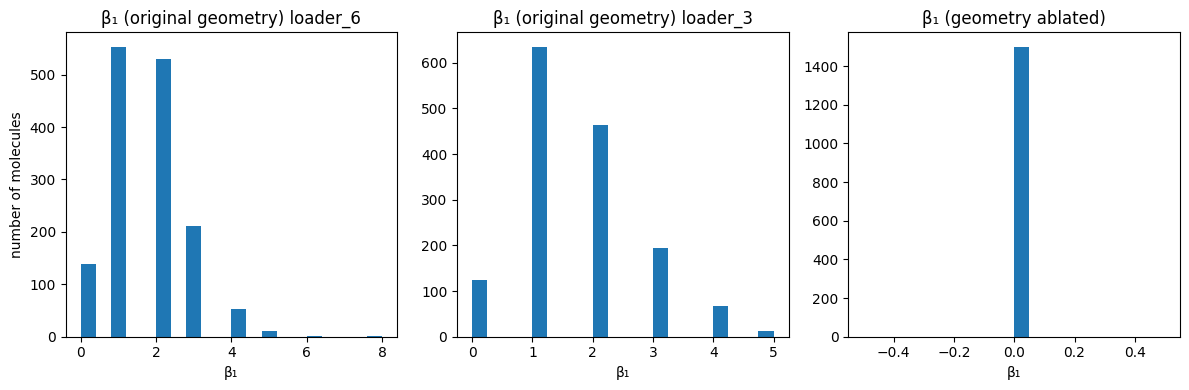

In [92]:
# target independent
# Look at β₁-destribution by test loaders idx=6,3. Full geometry and ablated geometry

plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.hist(beta1_geom_U0_6, bins=20)
plt.title("β₁ (original geometry) loader_6")
plt.xlabel("β₁")
plt.ylabel("number of molecules")

plt.subplot(1, 3, 2)
plt.hist(beta1_geom_U0_3, bins=20)
plt.title("β₁ (original geometry) loader_3")
plt.xlabel("β₁")

plt.subplot(1, 3, 3)
plt.hist(beta1_geom_ab_U0_6, bins=20)
plt.title("β₁ (geometry ablated)")
plt.xlabel("β₁")

plt.tight_layout()
plt.show()

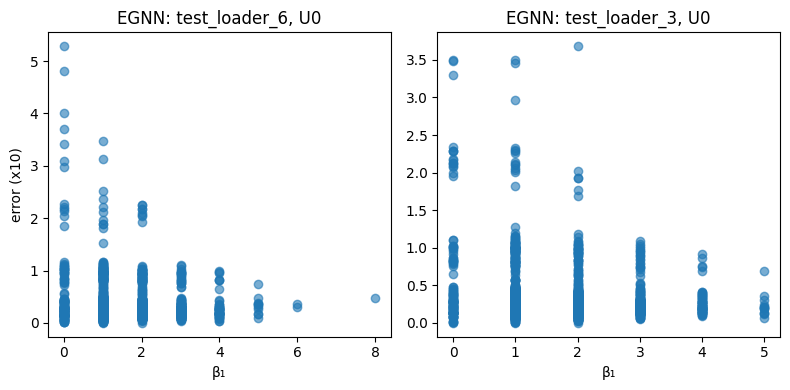

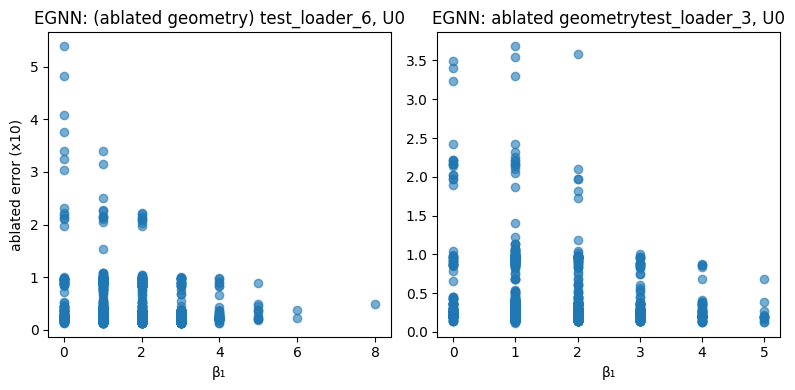

In [93]:
# U0
plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
plt.scatter(beta1_geom_U0_6, err_full_U0_6, alpha=0.6)
plt.title("EGNN: test_loader_6, U0")
plt.xlabel("β₁")
plt.ylabel("error (x10)")

plt.subplot(1, 2, 2)
plt.scatter(beta1_geom_U0_3, err_full_U0_3, alpha=0.6)
plt.title("EGNN: test_loader_3, U0")
plt.xlabel("β₁")

plt.tight_layout()
plt.show()


plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
plt.scatter(beta1_geom_U0_6, err_ab_U0_6, alpha=0.6)
plt.title("EGNN: (ablated geometry) test_loader_6, U0")
plt.xlabel("β₁")
plt.ylabel("ablated error (x10)")

plt.subplot(1, 2, 2)
plt.scatter(beta1_geom_U0_3, err_ab_U0_3, alpha=0.6)
plt.title("EGNN: ablated geometrytest_loader_3, U0")
plt.xlabel("β₁")

plt.tight_layout()
plt.show()

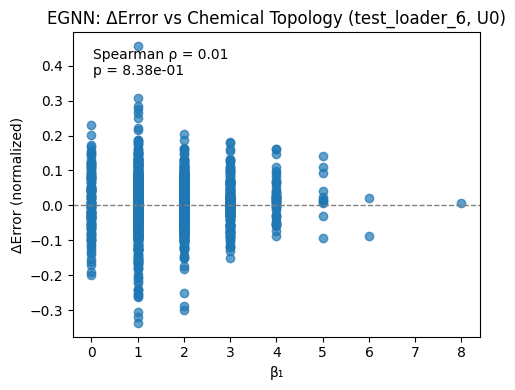

In [94]:
plot_delta_error_vs_beta(
    beta1_geom_U0_6,
    delta_err_U0_6,
    title=f"EGNN: ΔError vs Chemical Topology (test_loader_6, U0)",
    xlabel=r"β₁",
    ylabel="ΔError (normalized)"
    )

**documentation scipy.stats.spearmanr** calculates the Spearman rank-order correlation coefficient, a non-parametric measure of monotonicity between two datasets, ranging from -1 to +1. It assesses how well the relationship between variables can be described using a monotonic function, without assuming normal distribution, returning both the correlation coefficient and the p-value. **P-value:** A small p-value indicates evidence against the null hypothesis (that there is no correlation). A **Spearman coefficient** of +1 (perfect positive), -1 (perfect negative), or 0 (no correlation).

Нулевая гипоза (отсутствие роста (и падения) ΔError с ростом β₁) - очень слабая уверенность

mean ΔError per β₁ for U0


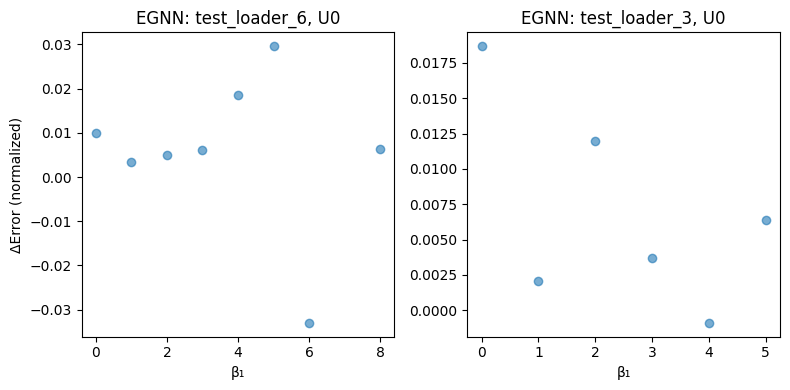

In [95]:
# U0

print('mean ΔError per β₁ for U0')

plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
plt.scatter(np.unique(beta1_geom_U0_6), list_mean_delta_U0_6, alpha=0.6)
plt.title(r"EGNN: test_loader_6, U0")
plt.xlabel("β₁")
plt.ylabel("ΔError (normalized)")

plt.subplot(1, 2, 2)
plt.scatter(np.unique(beta1_geom_U0_3), list_mean_delta_U0_3, alpha=0.6)
plt.title("EGNN: test_loader_3, U0")
plt.xlabel("β₁")

plt.tight_layout()
plt.show()

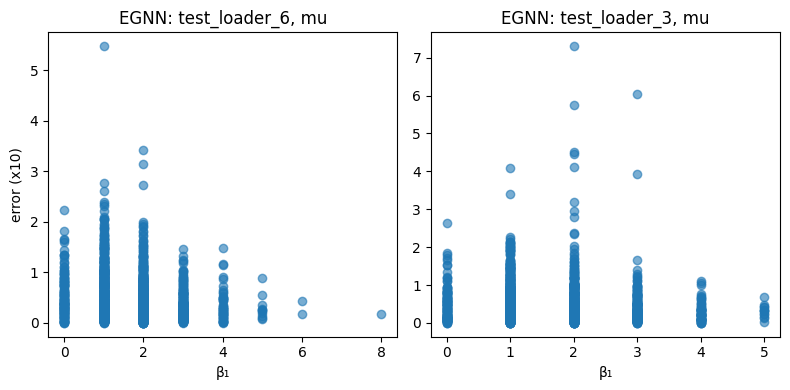

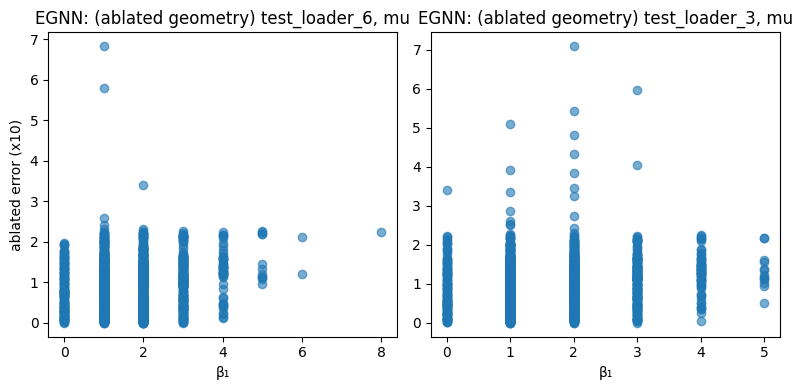

In [96]:
# mu

plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
plt.scatter(beta1_geom_mu_6, err_full_mu_6, alpha=0.6)
plt.title("EGNN: test_loader_6, mu")
plt.xlabel("β₁")
plt.ylabel("error (x10)")

plt.subplot(1, 2, 2)
plt.scatter(beta1_geom_mu_3, err_full_mu_3, alpha=0.6)
plt.title("EGNN: test_loader_3, mu")
plt.xlabel("β₁")

plt.tight_layout()
plt.show()


plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
plt.scatter(beta1_geom_mu_6, err_ab_mu_6, alpha=0.6)
plt.title("EGNN: (ablated geometry) test_loader_6, mu")
plt.xlabel("β₁")
plt.ylabel("ablated error (x10)")

plt.subplot(1, 2, 2)
plt.scatter(beta1_geom_mu_3, err_ab_mu_3, alpha=0.6)
plt.title("EGNN: (ablated geometry) test_loader_3, mu")
plt.xlabel("β₁")

plt.tight_layout()
plt.show()

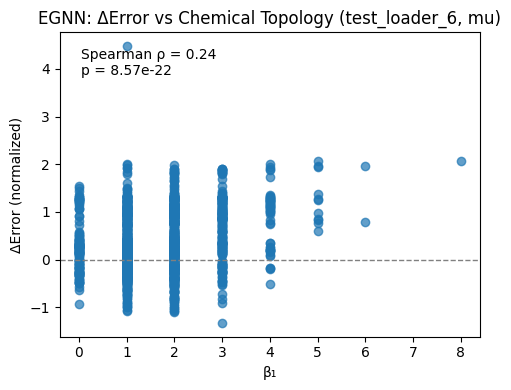

In [97]:
plot_delta_error_vs_beta(
    beta1_geom_mu_6,
    delta_err_mu_6,
    title=f"EGNN: ΔError vs Chemical Topology (test_loader_6, mu)",
    xlabel=r"β₁",
    ylabel="ΔError (normalized)"
    )

Нулевая гипоза (слабый рост ΔError с ростом β₁) - очень высокая уверенность в гипотезе

mean ΔError per β₁ for mu


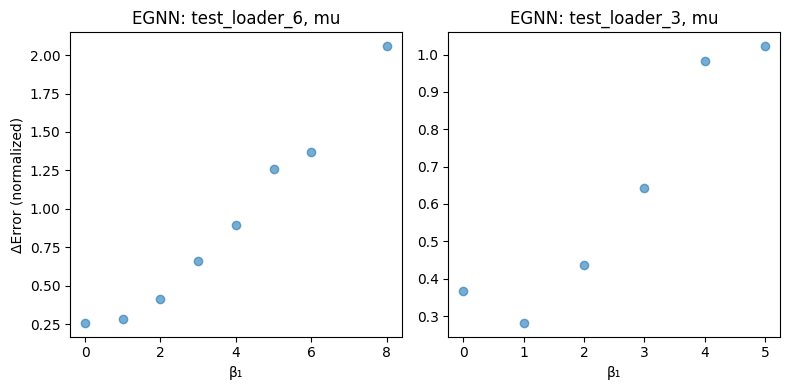

In [98]:
# mu

print('mean ΔError per β₁ for mu')

plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
plt.scatter(np.unique(beta1_geom_mu_6), list_mean_delta_mu_6, alpha=0.6)
plt.title(r"EGNN: test_loader_6, mu")
plt.xlabel("β₁")
plt.ylabel("ΔError (normalized)")

plt.subplot(1, 2, 2)
plt.scatter(np.unique(beta1_geom_mu_3), list_mean_delta_mu_3, alpha=0.6)
plt.title("EGNN: test_loader_3, mu")
plt.xlabel("β₁")

plt.tight_layout()
plt.show()

In [99]:
model_names = ['EGNN', 'EGNN', 'EGNN', 'EGNN']
loader_idxs = [6,3,6,3]
target_names = ['U0','U0', 'mu','mu']
betas = [beta1_geom_U0_6, beta1_geom_U0_3, beta1_geom_mu_6, beta1_geom_mu_3]
errs_full = [err_full_U0_6, err_full_U0_3, err_full_mu_6, err_full_mu_3]
errs_ab = [err_ab_U0_6, err_ab_U0_3, err_ab_mu_6, err_ab_mu_3]
delta_errs = [delta_err_U0_6, delta_err_U0_3, delta_err_mu_6, delta_err_mu_3]

err_names = ['error full geometry', 'ablated geometry error', "ΔError"]

In [100]:
errs_names = zip(err_names, [errs_full, errs_ab, delta_errs])

err_ablation_results = {}
err_ablation_results['EGNN Error'] = []
err_ablation_results['U0'] = []
err_ablation_results['mu'] = []

for err_name, errs_list in errs_names:
    betas_errs = zip(err_name, errs_list, model_names, target_names, betas, loader_idxs)
    print(f'err_name = {err_name}')
    print()

    err_ablation_results['EGNN Error'].append(err_name)

    for err_name, errs_list, model_name, target_name, betas_list, loader_idx in betas_errs:
        res_str = mann_whitney_test(model_name,
                            loader_idx,
                            target_name,
                            betas_list,
                            errs_list)
        if loader_idx == 6:
            err_ablation_results[target_name].append(res_str)


err_ablation_results['EGNN Error'].append('conclusion about training')
err_ablation_results['U0'].append('almost do not use coord')
err_ablation_results['mu'].append('use coord (mostly for big β₁)')


df_target_topology_dependence_egnn = pd.DataFrame.from_dict(err_ablation_results)

err_name = error full geometry

EGNN U0 test_loader_6

Low β₁ samples: 139
High β₁ samples: 1361

Mann–Whitney U = 107944.00
p-value = 6.0473e-03

----------------------------
EGNN U0 test_loader_3

Low β₁ samples: 125
High β₁ samples: 1375

Mann–Whitney U = 98798.00
p-value = 5.5450e-03

----------------------------
EGNN mu test_loader_6

Low β₁ samples: 139
High β₁ samples: 1361

Mann–Whitney U = 101290.00
p-value = 1.6841e-01

----------------------------
EGNN mu test_loader_3

Low β₁ samples: 125
High β₁ samples: 1375

Mann–Whitney U = 85584.00
p-value = 9.3931e-01

----------------------------
err_name = ablated geometry error

EGNN U0 test_loader_6

Low β₁ samples: 139
High β₁ samples: 1361

Mann–Whitney U = 110610.50
p-value = 9.8996e-04

----------------------------
EGNN U0 test_loader_3

Low β₁ samples: 125
High β₁ samples: 1375

Mann–Whitney U = 108209.00
p-value = 1.5612e-06

----------------------------
EGNN mu test_loader_6

Low β₁ samples: 139
High β₁ samples: 1361

Mann–

In [101]:
# Mann–Whitney

# difference in β₁=0 and β₁>0 molecule groups for different targets
# by full geometry and ablated geometry

df_target_topology_dependence_egnn

EGNN Error                                U0  \
0        error full geometry        p < 0.01 → strong evidence   
1     ablated geometry error  p < 0.001 → very strong evidence   
2                     ΔError          indistinguishable groups   
3  conclusion about training           almost do not use coord   

                                     mu  
0              indistinguishable groups  
1  p < 0.05 → statistically significant  
2            p < 0.01 → strong evidence  
3         use coord (mostly for big β₁)

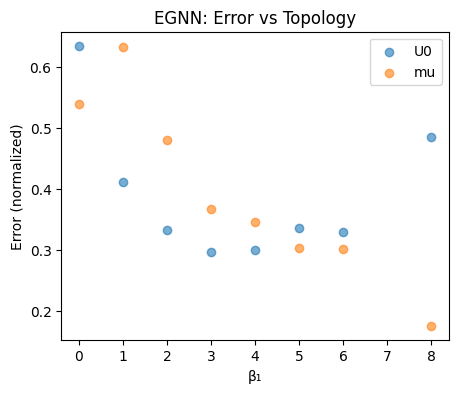

In [90]:
plt.figure(figsize=(5,4))
plt.scatter(np.unique(beta1_geom_U0_6), list_err_full_U0_6, alpha=0.6, label="U0")
plt.scatter(np.unique(beta1_geom_mu_6), list_err_full_mu_6, alpha=0.6, label="mu")
plt.legend(loc="best")
plt.xlabel("β₁")
plt.ylabel("Error (normalized)")
plt.title("EGNN: Error vs Topology")
plt.show()

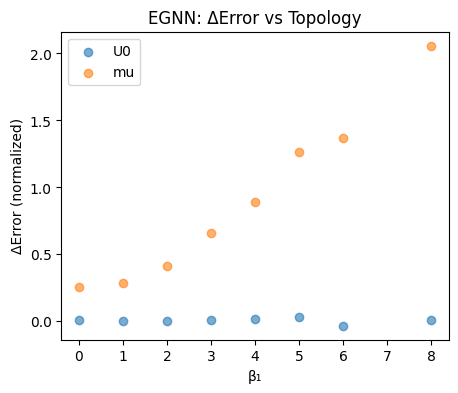

In [91]:
plt.figure(figsize=(5,4))
plt.scatter(np.unique(beta1_geom_U0_6), list_mean_delta_U0_6, alpha=0.6, label="U0")
plt.scatter(np.unique(beta1_geom_mu_6), list_mean_delta_mu_6, alpha=0.6, label="mu")
plt.legend(loc="upper left")
plt.xlabel("β₁")
plt.ylabel("ΔError (normalized)")
plt.title("EGNN: ΔError vs Topology")
plt.show()

EGNN для предсказания U0 слабо использует координаты, т.е. удаление координат из входа модели не приводит к существенному падению точности. Топология молекул влияет на точность предсказаний U0, однако она в основном определяется не координатами - модель изучет топологию почти не пользуясь координатами. Для U0 средний MSE падает с ростом β₁ (но для больших β₁ мало данных), а ΔMSE очень мал и не завсит от β₁.  

Влияние координат на предсказание mu гораздо более существенно. При наличии координат на входе модели точность предсказания mu зависит от топологии. НО обнуление координат заметно снижает общую точность предсказаний (для всех β₁ ошибка примерно одинакова). Чем больше β₁, тем чувствительнее предсказание к обнулению координат - т.е. модель активнее использует топологию, изученную на координатах, для определения mu у молекул с большим β₁.

# ____ FCNN

Для FCNN обнуление координат лишено смысла, т.к. координаты - это единственное, что подается на вход модели. Выводом из подобного эксперимента могло бы быть разве что знание, что важнее для предсказания таргета - знание о количестве атомов (малое ΔError) или координаты (большое ΔError). Впрочем, для разных таргетов эти знания могут быть важны в разной степени... Поэтому посмотрим!

In [102]:
# 15k
fcnn_params_15k = stats_15k, make_fcnn_collate
fcnn_15k_test_loders = get_model_test_loaders(test_set, TARGET_NAMES, fcnn_params_15k)

target_name = U0
len test_loaders in experiment = 9
len test_loaders in experiment = 9
len test_loaders in experiment = 9
len test_loaders in experiment = 9
len test_loaders in experiment = 9
len test_loaders in experiment = 9
len test_loaders in experiment = 9
len test_loaders in experiment = 9
len test_loaders in experiment = 9
target_name = mu
len test_loaders in experiment = 9
len test_loaders in experiment = 9
len test_loaders in experiment = 9
len test_loaders in experiment = 9
len test_loaders in experiment = 9
len test_loaders in experiment = 9
len test_loaders in experiment = 9
len test_loaders in experiment = 9
len test_loaders in experiment = 9


In [103]:
# there is no big difference between experiments, so we take experiment_no = 1

best_fcnn_U0_15k = load_best_model_of_experiment(FCNN, 'FCNN', 'U0', 1, 15000)
best_fcnn_mu_15k = load_best_model_of_experiment(FCNN, 'FCNN', 'mu', 1, 15000)

In [105]:
# U0 bettas and errors
(
    beta1_geom_U0_6,
    # beta1_geom_ab_U0_6,
    err_full_U0_6,
    err_ab_U0_6,
    delta_err_U0_6,
    idx_U0_6
    ) = collect_fcnn_betti_end_errors(best_fcnn_U0_15k,
                                      fcnn_15k_test_loders['U0'][6])

    ##################################

# mu bettas and errors

(
    beta1_geom_mu_6,
    # beta1_geom_ab_mu_6,
    err_full_mu_6,
    err_ab_mu_6,
    delta_err_mu_6,
    idx_mu_6
    ) = collect_fcnn_betti_end_errors(best_fcnn_mu_15k,
                                      fcnn_15k_test_loders['mu'][6])

In [106]:
# calculate mean ΔError per β₁ for U0 and mu (test loader idx = 6)

list_mean_delta_U0_6 = []
for k in sorted(np.unique(beta1_geom_U0_6)):
    mean_delta_U0_6 = np.mean(delta_err_U0_6[beta1_geom_U0_6 == k])
    list_mean_delta_U0_6.append(mean_delta_U0_6)

np.array(list_mean_delta_U0_6)


list_mean_delta_mu_6 = []
for k in sorted(np.unique(beta1_geom_mu_6)):
    mean_delta_mu_6 = np.mean(delta_err_mu_6[beta1_geom_mu_6 == k])
    list_mean_delta_mu_6.append(mean_delta_mu_6)

np.array(list_mean_delta_mu_6)

array([ 0.2102022 ,  0.18810123,  0.2214508 ,  0.24675654,  0.36081362,
        0.4045684 ,  0.57395232, -0.0646652 ])

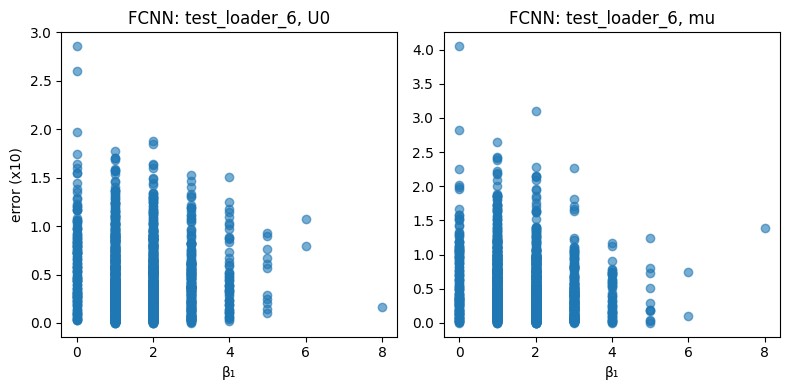

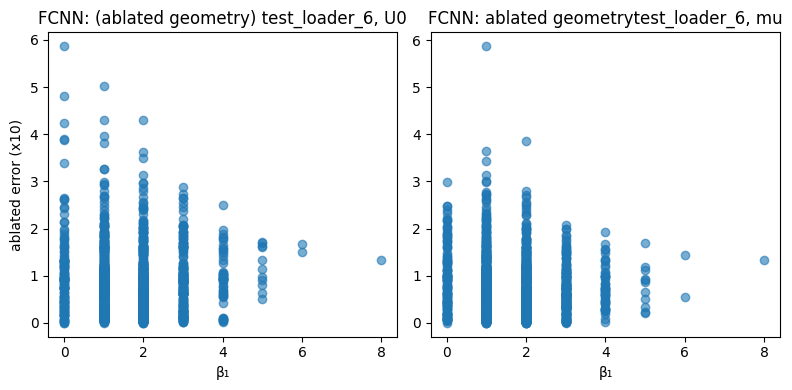

In [107]:
# U0, mu  (beta1_geom_U0_6 = beta1_geom_mu_6)
plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
plt.scatter(beta1_geom_U0_6, err_full_U0_6, alpha=0.6)
plt.title("FCNN: test_loader_6, U0")
plt.xlabel("β₁")
plt.ylabel("error (x10)")

plt.subplot(1, 2, 2)
plt.scatter(beta1_geom_mu_6, err_full_mu_6, alpha=0.6)
plt.title("FCNN: test_loader_6, mu")
plt.xlabel("β₁")

plt.tight_layout()
plt.show()


plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
plt.scatter(beta1_geom_U0_6, err_ab_U0_6, alpha=0.6)
plt.title("FCNN: (ablated geometry) test_loader_6, U0")
plt.xlabel("β₁")
plt.ylabel("ablated error (x10)")

plt.subplot(1, 2, 2)
plt.scatter(beta1_geom_mu_6, err_ab_mu_6, alpha=0.6)
plt.title("FCNN: ablated geometrytest_loader_6, mu")
plt.xlabel("β₁")

plt.tight_layout()
plt.show()

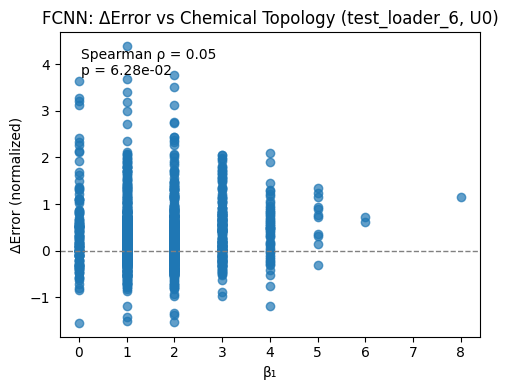

In [108]:
plot_delta_error_vs_beta(
    beta1_geom_U0_6,
    delta_err_U0_6,
    title=f"FCNN: ΔError vs Chemical Topology (test_loader_6, U0)",
    xlabel=r"β₁",
    ylabel="ΔError (normalized)"
    )

Слабая уверенность в отсутствии коррелиции (незначительной коррелиции)

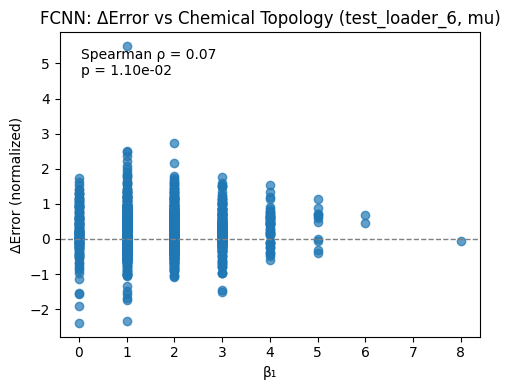

In [109]:
plot_delta_error_vs_beta(
    beta1_geom_mu_6,
    delta_err_mu_6,
    title=f"FCNN: ΔError vs Chemical Topology (test_loader_6, mu)",
    xlabel=r"β₁",
    ylabel="ΔError (normalized)"
    )

Статистически значимая уверенность в незначительной корреляции

mean ΔError per β₁ for U0, mu


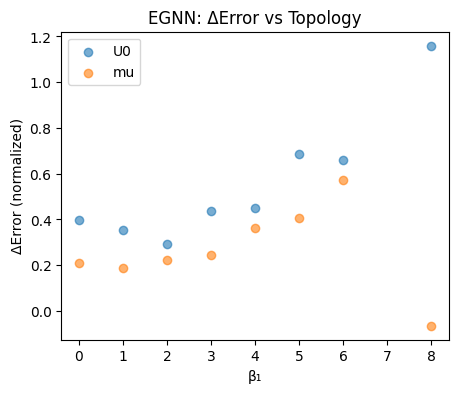

In [110]:
# U0, mu

print('mean ΔError per β₁ for U0, mu')

plt.figure(figsize=(5,4))
plt.scatter(np.unique(beta1_geom_U0_6), list_mean_delta_U0_6, alpha=0.6, label="U0")
plt.scatter(np.unique(beta1_geom_mu_6), list_mean_delta_mu_6, alpha=0.6, label="mu")
plt.legend(loc="upper left")
plt.xlabel("β₁")
plt.ylabel("ΔError (normalized)")
plt.title("EGNN: ΔError vs Topology")
plt.show()

In [111]:
model_names = ['FCNN', 'FCNN']
loader_idxs = [6,6]
target_names = ['U0', 'mu']
betas = [beta1_geom_U0_6, beta1_geom_mu_6]
errs_full = [err_full_U0_6, err_full_mu_6]
errs_ab = [err_ab_U0_6, err_ab_mu_6]
delta_errs = [delta_err_U0_6, delta_err_mu_6]

err_names = ['error full geometry', 'ablated geometry error', "ΔError"]

In [112]:
errs_names = zip(err_names, [errs_full, errs_ab, delta_errs])

err_ablation_results = {}
err_ablation_results['FCNN Error'] = []
err_ablation_results['U0'] = []
err_ablation_results['mu'] = []

for err_name, errs_list in errs_names:
    betas_errs = zip(err_name, errs_list, model_names, target_names, betas, loader_idxs)
    print(f'err_name = {err_name}')
    print()

    err_ablation_results['FCNN Error'].append(err_name)

    for err_name, errs_list, model_name, target_name, betas_list, loader_idx in betas_errs:
        res_str = mann_whitney_test(model_name,
                            loader_idx,
                            target_name,
                            betas_list,
                            errs_list)

        err_ablation_results[target_name].append(res_str)


err_ablation_results['FCNN Error'].append('conclusion about training')
err_ablation_results['U0'].append('almost do not use coord')
err_ablation_results['mu'].append('almost do not use coord')


df_target_topology_dependence_egnn = pd.DataFrame.from_dict(err_ablation_results)

err_name = error full geometry

FCNN U0 test_loader_6

Low β₁ samples: 139
High β₁ samples: 1361

Mann–Whitney U = 116576.00
p-value = 6.1926e-06

----------------------------
FCNN mu test_loader_6

Low β₁ samples: 139
High β₁ samples: 1361

Mann–Whitney U = 108482.00
p-value = 4.2928e-03

----------------------------
err_name = ablated geometry error

FCNN U0 test_loader_6

Low β₁ samples: 139
High β₁ samples: 1361

Mann–Whitney U = 108249.00
p-value = 4.9865e-03

----------------------------
FCNN mu test_loader_6

Low β₁ samples: 139
High β₁ samples: 1361

Mann–Whitney U = 105836.00
p-value = 2.0785e-02

----------------------------
err_name = ΔError

FCNN U0 test_loader_6

Low β₁ samples: 139
High β₁ samples: 1361

Mann–Whitney U = 93148.00
p-value = 7.6706e-01

----------------------------
FCNN mu test_loader_6

Low β₁ samples: 139
High β₁ samples: 1361

Mann–Whitney U = 96207.00
p-value = 7.3958e-01

----------------------------


In [114]:
# Mann–Whitney
df_target_topology_dependence_egnn

FCNN Error                                U0  \
0        error full geometry  p < 0.001 → very strong evidence   
1     ablated geometry error        p < 0.01 → strong evidence   
2                     ΔError          indistinguishable groups   
3  conclusion about training           almost do not use coord   

                                     mu  
0            p < 0.01 → strong evidence  
1  p < 0.05 → statistically significant  
2              indistinguishable groups  
3               almost do not use coord

Обнуление координат на входе обученной FCNN слабо влияет на предсказание. И хотя на графике с ростом β₁ наблюдается рост ошибки - это влияние гораздо менее выражено для FCNN по сравнению с EGNN (а молекул с большим β₁ вообще мало и результат может быть шумом). Интригой этого эксперимента был ответ на вопрос, какой таргет при FCNN окажется чувствительнее к схлопыванию координат. Победил U0. Видимо, то, что FCNN не обладает инвариантностью координат, обрушает ценность координат для предсказания mu. А U0-обученная FCNN использует координаты для предсказания размера молекулы, который коррелирует с U0. Размер молекулы лучше предсказывается из числа атомов, поэтому схлопывание координат слабо влияет на точность предсказания.

# ____ DistanceGNN

In [116]:
# def get_graph_target(data, target_idx, y_mean, y_std):
#     """
#     Returns normalized graph-level target tensor
#     with shape [num_graphs, 1].
#     """

#     y = data.y[:, target_idx]
#     batch = data.batch

#     # normalize FIRST
#     y = (y - y_mean) / y_std
#     y = y.unsqueeze(1)

#     num_graphs = int(batch.max()) + 1

#     # node-level → graph-level
#     if y.size(0) != num_graphs:
#         y = global_mean_pool(y, batch)

#     # hard guards
#     assert y.dim() == 2
#     assert y.size(0) == num_graphs

#     return y

In [117]:
# def compute_geom_beta1_batch(data):
#     """
#     Returns a list of β₁ values, one per graph in batch
#     """
#     beta_list = []

#     edge_index = data.edge_index
#     batch = data.batch
#     num_graphs = data.num_graphs

#     for g in range(num_graphs):
#         # nodes belonging to graph g
#         node_mask = batch == g
#         nodes = node_mask.nonzero(as_tuple=False).view(-1)

#         if len(nodes) < 3:
#             beta_list.append(0)
#             continue

#         # remap node indices
#         node_id_map = {int(n): i for i, n in enumerate(nodes)}

#         # select edges inside graph
#         mask = node_mask[edge_index[0]] & node_mask[edge_index[1]]
#         edges = edge_index[:, mask]

#         if edges.numel() == 0:
#             beta_list.append(0)
#             continue

#         # remap edges
#         edges = torch.stack([
#             torch.tensor([node_id_map[int(i)] for i in edges[0]]),
#             torch.tensor([node_id_map[int(i)] for i in edges[1]])
#         ])

#         # graph theory: β₁ = E - V + C
#         V = len(nodes)
#         E = edges.size(1)
#         C = 1  # connected component (QM9 molecules)

#         beta = max(E - V + C, 0)
#         beta_list.append(beta)

#     return beta_list

In [118]:
# def compute_graph_beta1_batch(data, persistence_threshold=0.2):
#     beta_list = []

#     pos = data.pos
#     batch = data.batch
#     num_graphs = data.num_graphs

#     for g in range(num_graphs):
#         coords = pos[batch == g].cpu().numpy()
#         beta = compute_beta1(coords, persistence_threshold)
#         beta_list.append(beta)

#     return beta_list

In [119]:
# def collect_error_and_betti(best_model, subset_loader, target_idx, y_mean, y_std):
#     beta_graph = []
#     beta_geom = []
#     err_full_list = []
#     err_ab_list = []
#     delta_err = []

#     best_model.eval()
#     with torch.no_grad():
#         for data in subset_loader:
#             data = data.to(device)
#             num_graphs = data.num_graphs

#             # ===== Betti numbers PER GRAPH =====
#             beta_graph_batch = compute_graph_beta1_batch(data)   # len = num_graphs
#             beta_geom_batch  = compute_geom_beta1_batch(data)

#             # ===== graph-level target =====
#             y_graph = get_graph_target(data, target_idx, y_mean, y_std)  # [num_graphs, 1]

#             # ===== full geometry =====
#             pred_full = best_model(data)  # [num_graphs, 1]
#             err_full = (pred_full - y_graph).abs().mean(dim=1)  # [num_graphs]

#             # ===== ablated geometry =====
#             data_ab = data.clone()
#             data_ab.pos = pg_ablate_geometry(data.pos, mode="shuffle")

#             pred_ab = best_model(data_ab)
#             err_ab = (pred_ab - y_graph).abs().mean(dim=1)       # [num_graphs]

#             # ===== collect PER GRAPH =====
#             beta_graph.extend(beta_graph_batch)
#             beta_geom.extend(beta_geom_batch)
#             err_full_list.extend(err_full.cpu().numpy())
#             err_ab_list.extend(err_ab.cpu().numpy())
#             delta_err.extend((err_ab - err_full).cpu().numpy())

#     return (
#         np.array(beta_graph),
#         np.array(beta_geom),
#         np.array(err_full_list),
#         np.array(err_ab_list),
#         np.array(delta_err),
#     )

In [120]:
model_name = 'DistanceGNN'

In [121]:
pg_test_loders = get_model_test_loaders(test_set, TARGET_NAMES)

target_name = U0
len test_loaders in experiment = 9
len test_loaders in experiment = 9
len test_loaders in experiment = 9
target_name = mu
len test_loaders in experiment = 9
len test_loaders in experiment = 9
len test_loaders in experiment = 9


In [122]:
best_gnn_U0_15k = load_best_model_of_experiment(DistanceGNN, 'DistanceGNN', 'U0', 1, 15000)
best_gnn_mu_15k = load_best_model_of_experiment(DistanceGNN, 'DistanceGNN', 'mu', 1, 15000)

In [123]:
# U0 bettas and errors
(
    beta1_graph_U0_6,
    beta1_geom_U0_6,
    err_full_U0_6,
    err_ab_U0_6,
    delta_err_U0_6,
    # idx_U0_6
    ) = collect_error_and_betti(best_gnn_U0_15k,
                                pg_test_loders['U0'][6],
                                QM9_TARGETS['U0'],
                                stats_15k[QM9_TARGETS['U0']][0][0],
                                stats_15k[QM9_TARGETS['U0']][0][1])

    ##################################

# mu bettas and errors

(
    beta1_graph_mu_6,
    beta1_geom_mu_6,
    err_full_mu_6,
    err_ab_mu_6,
    delta_err_mu_6,
    # idx_mu_6
    ) = collect_error_and_betti(best_gnn_mu_15k,
                                pg_test_loders['mu'][6],
                                QM9_TARGETS['mu'],
                                stats_15k[QM9_TARGETS['mu']][0][0],
                                stats_15k[QM9_TARGETS['mu']][0][1])

In [124]:
print("β_graph min/max:", beta1_graph_U0_6.min(), beta1_graph_U0_6.max())
print("β_geom  min/max:", beta1_geom_U0_6.min(), beta1_geom_U0_6.max())

β_graph min/max: 0 8
β_geom  min/max: 9 28


In [125]:
len(beta1_graph_U0_6)

1500

In [126]:
# calculate mean ΔError per β₁ for U0 and mu (test loader idx = 6) - GRAPH LVL

list_mean_delta_U0_6 = []
for k in sorted(np.unique(beta1_graph_U0_6)):
    mean_delta_U0_6 = np.mean(delta_err_U0_6[beta1_graph_U0_6 == k])
    list_mean_delta_U0_6.append(mean_delta_U0_6)

np.array(list_mean_delta_U0_6)


list_mean_delta_mu_6 = []
for k in sorted(np.unique(beta1_graph_mu_6)):
    mean_delta_mu_6 = np.mean(delta_err_mu_6[beta1_graph_mu_6 == k])
    list_mean_delta_mu_6.append(mean_delta_mu_6)

np.array(list_mean_delta_mu_6)

array([121.82818 , 120.620224, 122.01276 , 132.5104  , 116.61554 ,
       122.936745,  64.57194 ,  92.11738 ], dtype=float32)

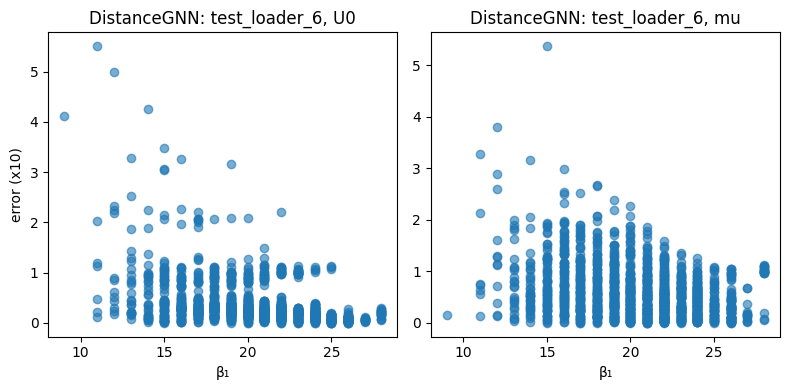

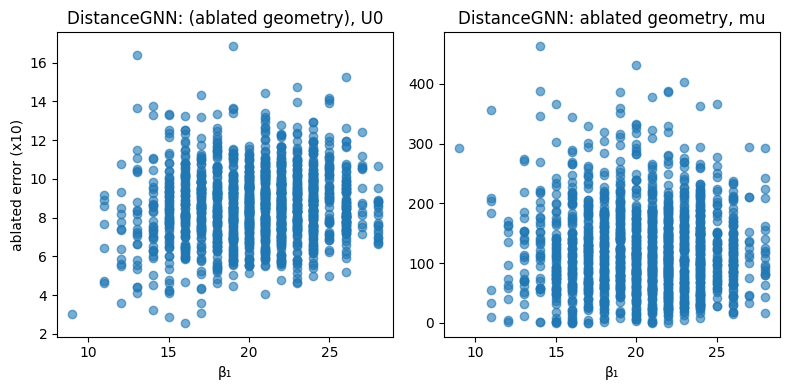

In [127]:
# U0, mu  (beta1_geom_U0_6 = beta1_geom_mu_6) -- ATOM LEVEL
plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
plt.scatter(beta1_geom_U0_6, err_full_U0_6, alpha=0.6)
plt.title(f"{model_name}: test_loader_6, U0")
plt.xlabel("β₁")
plt.ylabel("error (x10)")

plt.subplot(1, 2, 2)
plt.scatter(beta1_geom_mu_6, err_full_mu_6, alpha=0.6)
plt.title(f"{model_name}: test_loader_6, mu")
plt.xlabel("β₁")

plt.tight_layout()
plt.show()


plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
plt.scatter(beta1_geom_U0_6, err_ab_U0_6, alpha=0.6)
plt.title(f"{model_name}: (ablated geometry), U0")
plt.xlabel("β₁")
plt.ylabel("ablated error (x10)")

plt.subplot(1, 2, 2)
plt.scatter(beta1_geom_mu_6, err_ab_mu_6, alpha=0.6)
plt.title(f"{model_name}: ablated geometry, mu")
plt.xlabel("β₁")

plt.tight_layout()
plt.show()

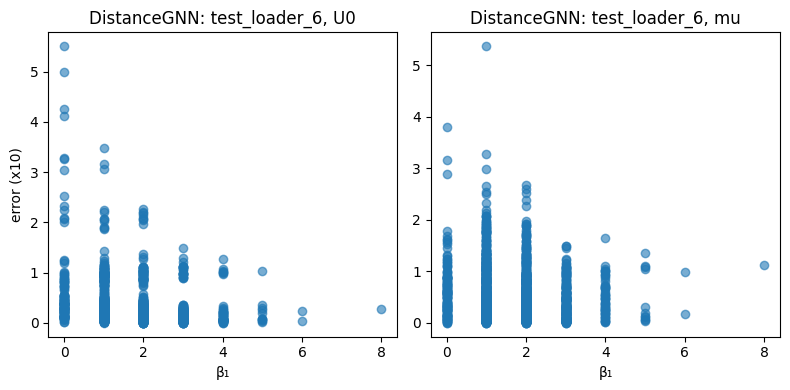

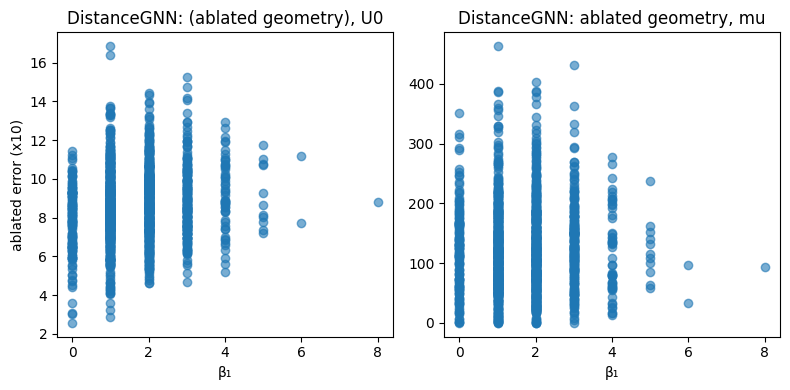

In [128]:
# U0, mu  (beta1_geom_U0_6 = beta1_geom_mu_6) -- GRAPH LEVEL
plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
plt.scatter(beta1_graph_U0_6, err_full_U0_6, alpha=0.6)
plt.title(f"{model_name}: test_loader_6, U0")
plt.xlabel("β₁")
plt.ylabel("error (x10)")

plt.subplot(1, 2, 2)
plt.scatter(beta1_graph_mu_6, err_full_mu_6, alpha=0.6)
plt.title(f"{model_name}: test_loader_6, mu")
plt.xlabel("β₁")

plt.tight_layout()
plt.show()


plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
plt.scatter(beta1_graph_U0_6, err_ab_U0_6, alpha=0.6)
plt.title(f"{model_name}: (ablated geometry), U0")
plt.xlabel("β₁")
plt.ylabel("ablated error (x10)")

plt.subplot(1, 2, 2)
plt.scatter(beta1_graph_mu_6, err_ab_mu_6, alpha=0.6)
plt.title(f"{model_name}: ablated geometry, mu")
plt.xlabel("β₁")

plt.tight_layout()
plt.show()

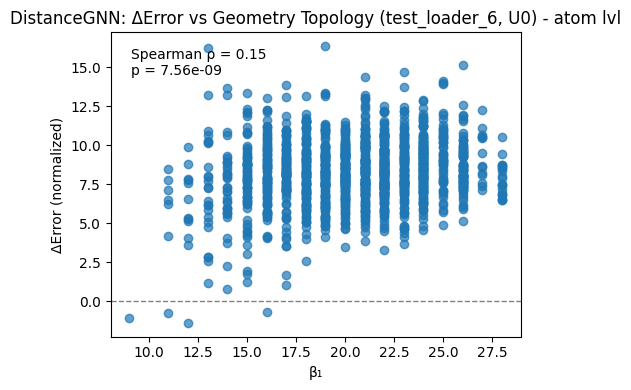

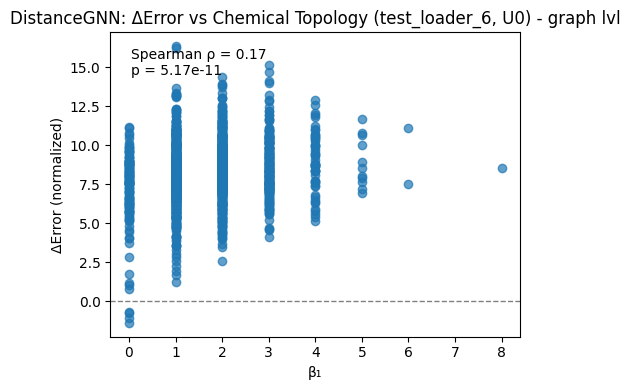

In [129]:
# ΔError vs β₁, U0

plot_delta_error_vs_beta(
    beta1_geom_U0_6,
    delta_err_U0_6,
    title=f"{model_name}: ΔError vs Geometry Topology (test_loader_6, U0) - atom lvl",
    xlabel=r"β₁",
    ylabel="ΔError (normalized)"
    )

plot_delta_error_vs_beta(
    beta1_graph_U0_6,
    delta_err_U0_6,
    title=f"{model_name}: ΔError vs Chemical Topology (test_loader_6, U0) - graph lvl",
    xlabel=r"β₁",
    ylabel="ΔError (normalized)"
    )

Сильная уверенность в слабой корреляции

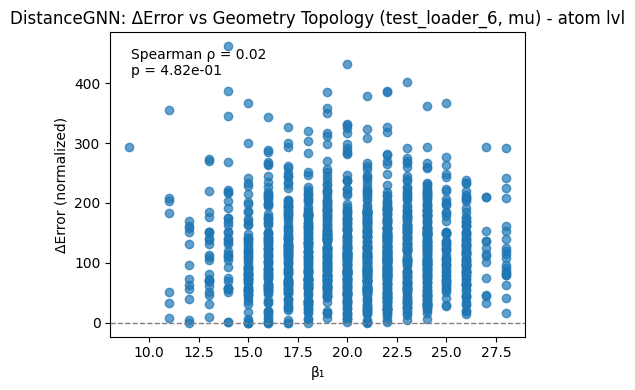

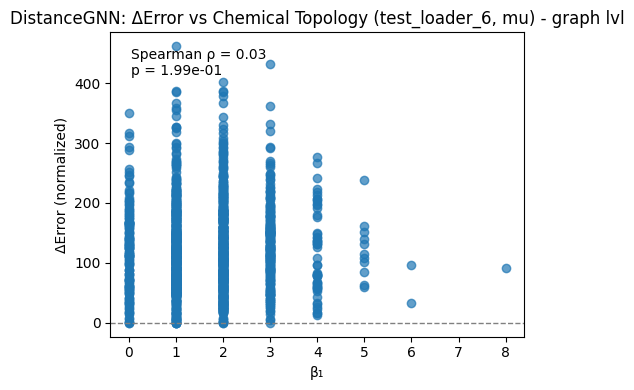

In [130]:
# ΔError vs β₁, mu

plot_delta_error_vs_beta(
    beta1_geom_mu_6,
    delta_err_mu_6,
    title=f"{model_name}: ΔError vs Geometry Topology (test_loader_6, mu) - atom lvl",
    xlabel=r"β₁",
    ylabel="ΔError (normalized)"
    )

plot_delta_error_vs_beta(
    beta1_graph_mu_6,
    delta_err_mu_6,
    title=f"{model_name}: ΔError vs Chemical Topology (test_loader_6, mu) - graph lvl",
    xlabel=r"β₁",
    ylabel="ΔError (normalized)"
    )

Статистически незначительная уверенность в незначительной корреляции

mean ΔError per β₁ for U0, mu on graph lvl


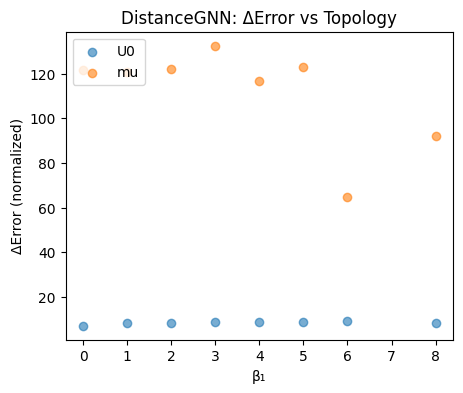

In [131]:
# U0, mu

print('mean ΔError per β₁ for U0, mu on graph lvl')

plt.figure(figsize=(5,4))
plt.scatter(np.unique(beta1_graph_U0_6), list_mean_delta_U0_6, alpha=0.6, label="U0")
plt.scatter(np.unique(beta1_graph_mu_6), list_mean_delta_mu_6, alpha=0.6, label="mu")
plt.legend(loc="upper left")
plt.xlabel("β₁")
plt.ylabel("ΔError (normalized)")
plt.title(f"{model_name}: ΔError vs Topology")
plt.show()

In [132]:
model_names = [model_name, model_name]
loader_idxs = [6,6]
target_names = ['U0', 'mu']
betas = [beta1_graph_U0_6, beta1_graph_mu_6]
errs_full = [err_full_U0_6, err_full_mu_6]
errs_ab = [err_ab_U0_6, err_ab_mu_6]
delta_errs = [delta_err_U0_6, delta_err_mu_6]

err_names = ['error full geometry', 'ablated geometry error', "ΔError"]

In [133]:
errs_names = zip(err_names, [errs_full, errs_ab, delta_errs])

err_ablation_results = {}
err_ablation_results[f'{model_name} Error'] = []
err_ablation_results['U0'] = []
err_ablation_results['mu'] = []

for err_name, errs_list in errs_names:
    betas_errs = zip(err_name, errs_list, model_names, target_names, betas, loader_idxs)
    print(f'err_name = {err_name}')
    print()

    err_ablation_results[f'{model_name} Error'].append(err_name)

    for err_name, errs_list, model_name, target_name, betas_list, loader_idx in betas_errs:
        res_str = mann_whitney_test(model_name,
                            loader_idx,
                            target_name,
                            betas_list,
                            errs_list)

        err_ablation_results[target_name].append(res_str)


err_ablation_results[f'{model_name} Error'].append('conclusion about training')
err_ablation_results['U0'].append('almost do not use coord')
err_ablation_results['mu'].append('use coord')


df_target_topology_dependence_gnn = pd.DataFrame.from_dict(err_ablation_results)

err_name = error full geometry

DistanceGNN U0 test_loader_6

Low β₁ samples: 139
High β₁ samples: 1361

Mann–Whitney U = 128813.00
p-value = 1.9885e-12

----------------------------
DistanceGNN mu test_loader_6

Low β₁ samples: 139
High β₁ samples: 1361

Mann–Whitney U = 98779.00
p-value = 3.8916e-01

----------------------------
err_name = ablated geometry error

DistanceGNN U0 test_loader_6

Low β₁ samples: 139
High β₁ samples: 1361

Mann–Whitney U = 69461.00
p-value = 2.3965e-07

----------------------------
DistanceGNN mu test_loader_6

Low β₁ samples: 139
High β₁ samples: 1361

Mann–Whitney U = 94730.00
p-value = 9.7704e-01

----------------------------
err_name = ΔError

DistanceGNN U0 test_loader_6

Low β₁ samples: 139
High β₁ samples: 1361

Mann–Whitney U = 66739.00
p-value = 1.0333e-08

----------------------------
DistanceGNN mu test_loader_6

Low β₁ samples: 139
High β₁ samples: 1361

Mann–Whitney U = 94706.00
p-value = 9.8098e-01

----------------------------


In [134]:
# Mann–Whitney

# difference in β₁=0 and β₁>0 molecule groups for different targets
# by full geometry and ablated geometry

df_target_topology_dependence_gnn

DistanceGNN Error                                U0  \
0        error full geometry  p < 0.001 → very strong evidence   
1     ablated geometry error  p < 0.001 → very strong evidence   
2                     ΔError  p < 0.001 → very strong evidence   
3  conclusion about training           almost do not use coord   

                         mu  
0  indistinguishable groups  
1  indistinguishable groups  
2  indistinguishable groups  
3                 use coord


DistanceGNN использует для предсказаний расстояния между атомами и атомные числа. Поэтому geometry_ablation реализован через **перемешивание координат**. Видно, что влияние перемешивания координат на предсказание таргета сильно зависит от таргета. Предсказание U0 практически не использует расстояния (или то, что изучается через расстояния, не меняется при перемешивании координат - например, знание о размере молекулы), а mu наоборот очень сильно зависит от того, насколько корректно расстояния переданы. Топологическая сложность молекулы не влияет на качество предсказания таргетов.

idx_high=[117793  20168  11085 117591  59891]...
idx mol_high =45390
β₁=2


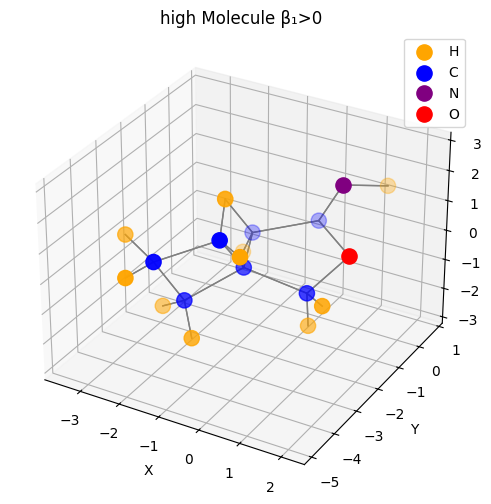

In [135]:
# look at the molecule from list of ones with β₁>0

low_mask = beta1_graph_U0_6 <= 0
high_mask = beta1_graph_U0_6 >= 1

sample_idx = 10

idx_high = idx_U0_6[high_mask]
print(f'idx_high={idx_high[:5]}...')
mol_high = dataset[idx_high[sample_idx]]
print(f'idx mol_high ={mol_high.idx}')
mol_high = dataset[idx_high[sample_idx]]
print(f'β₁={beta1_graph_U0_6[high_mask][sample_idx]}')

plot_molecule(
    pos=mol_high.pos,
    z=mol_high.z,
    edge_index=mol_high.edge_index,
    title="high Molecule β₁>0"
)

# ____GCN

In [140]:
model_name = 'GCN'

In [141]:
pg_test_loders = get_model_test_loaders(test_set, TARGET_NAMES)

target_name = U0
len test_loaders in experiment = 9
len test_loaders in experiment = 9
len test_loaders in experiment = 9
target_name = mu
len test_loaders in experiment = 9
len test_loaders in experiment = 9
len test_loaders in experiment = 9


In [142]:
best_gcn_U0_15k = load_best_model_of_experiment(GCN, 'GCN', 'U0', 1, 15000)
best_gcn_mu_15k = load_best_model_of_experiment(GCN, 'GCN', 'mu', 1, 15000)

In [143]:
(
    beta1_graph_U0_6,
    beta1_geom_U0_6,
    err_full_U0_6,
    err_ab_U0_6,
    delta_err_U0_6,
    # idx_U0_6
    ) = collect_error_and_betti(best_gcn_U0_15k,
                                pg_test_loders['U0'][6],
                                QM9_TARGETS['U0'],
                                stats_15k[QM9_TARGETS['U0']][0][0],
                                stats_15k[QM9_TARGETS['U0']][0][1])

    ##################################

# mu bettas and errors

(
    beta1_graph_mu_6,
    beta1_geom_mu_6,
    err_full_mu_6,
    err_ab_mu_6,
    delta_err_mu_6,
    # idx_mu_6
    ) = collect_error_and_betti(best_gcn_mu_15k,
                                pg_test_loders['mu'][6],
                                QM9_TARGETS['mu'],
                                stats_15k[QM9_TARGETS['mu']][0][0],
                                stats_15k[QM9_TARGETS['mu']][0][1])

In [144]:
# calculate mean full Error per β₁ for U0 and mu (test loader idx = 6) - GRAPH LVL

list_mean_err_full_U0_6 = []
for k in sorted(np.unique(beta1_graph_U0_6)):
    mean_err_full_U0_6 = np.mean(err_full_U0_6[beta1_graph_U0_6 == k])
    list_mean_err_full_U0_6.append(mean_err_full_U0_6)

np.array(list_mean_err_full_U0_6)


list_mean_err_full_mu_6 = []
for k in sorted(np.unique(beta1_graph_mu_6)):
    mean_err_full_mu_6 = np.mean(err_full_mu_6[beta1_graph_mu_6 == k])
    list_mean_err_full_mu_6.append(mean_err_full_mu_6)

np.array(list_mean_err_full_mu_6)

array([0.5328407 , 0.620617  , 0.46878076, 0.3588551 , 0.3908047 ,
       0.3396161 , 0.2254166 , 0.7148036 ], dtype=float32)

In [145]:
# calculate mean full Error per β₁ for U0 and mu (test loader idx = 6) - ATOM LVL

list_mean_err_full_U0_6_atom = []
for k in sorted(np.unique(beta1_geom_U0_6)):
    mean_err_full_U0_6 = np.mean(err_full_U0_6[beta1_geom_U0_6 == k])
    list_mean_err_full_U0_6_atom.append(mean_err_full_U0_6)

np.array(list_mean_err_full_U0_6_atom)


list_mean_err_full_mu_6_atom = []
for k in sorted(np.unique(beta1_geom_mu_6)):
    mean_err_full_mu_6 = np.mean(err_full_mu_6[beta1_geom_mu_6 == k])
    list_mean_err_full_mu_6_atom.append(mean_err_full_mu_6)

np.array(list_mean_err_full_mu_6_atom)

array([1.6248207 , 1.3183259 , 1.3796148 , 0.9422018 , 0.71565473,
       0.66689956, 0.842375  , 0.6342401 , 0.64359945, 0.56030965,
       0.5059152 , 0.4609573 , 0.38700798, 0.34837118, 0.3422634 ,
       0.3716077 , 0.24748263, 0.22621319, 0.5391395 ], dtype=float32)

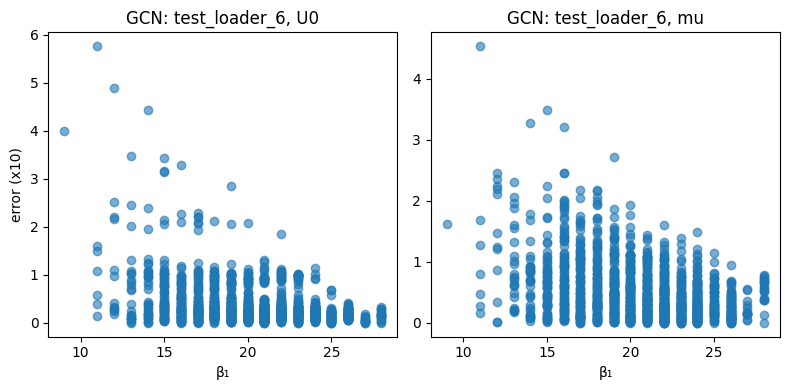

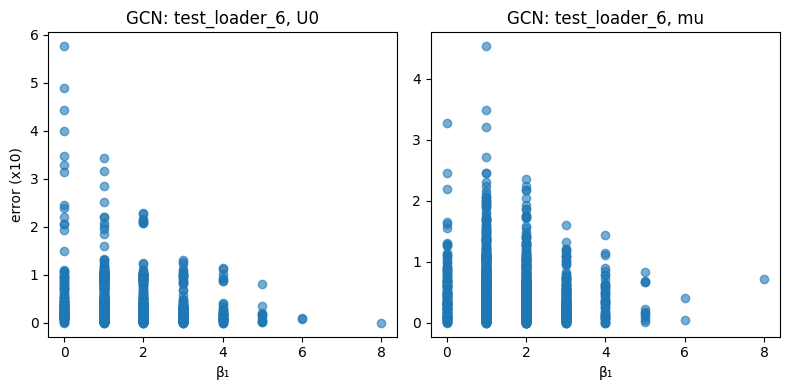

In [146]:
# U0, mu  (beta1_geom_U0_6 = beta1_geom_mu_6) -- ATOM LEVEL
plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
plt.scatter(beta1_geom_U0_6, err_full_U0_6, alpha=0.6)
plt.title(f"{model_name}: test_loader_6, U0")
plt.xlabel("β₁")
plt.ylabel("error (x10)")

plt.subplot(1, 2, 2)
plt.scatter(beta1_geom_mu_6, err_full_mu_6, alpha=0.6)
plt.title(f"{model_name}: test_loader_6, mu")
plt.xlabel("β₁")

plt.tight_layout()
plt.show()

# U0, mu  (beta1_geom_U0_6 = beta1_geom_mu_6) -- GRAPH LEVEL
plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
plt.scatter(beta1_graph_U0_6, err_full_U0_6, alpha=0.6)
plt.title(f"{model_name}: test_loader_6, U0")
plt.xlabel("β₁")
plt.ylabel("error (x10)")

plt.subplot(1, 2, 2)
plt.scatter(beta1_graph_mu_6, err_full_mu_6, alpha=0.6)
plt.title(f"{model_name}: test_loader_6, mu")
plt.xlabel("β₁")

plt.tight_layout()
plt.show()

In [147]:
model_names = [model_name, model_name]
loader_idxs = [6,6]
target_names = ['U0', 'mu']
betas = [beta1_graph_U0_6, beta1_graph_mu_6]
errs_full = [err_full_U0_6, err_full_mu_6]
# errs_ab = [err_ab_U0_6, err_ab_mu_6]
# delta_errs = [delta_err_U0_6, delta_err_mu_6]

err_names = ['error full geometry',
            #  'ablated geometry error', "ΔError"
             ]

In [152]:
errs_names = zip(err_names, [errs_full,
                            #  errs_ab, delta_errs
                             ])

err_ablation_results = {}
err_ablation_results[f'{model_name} Error'] = []
err_ablation_results['U0'] = []
err_ablation_results['mu'] = []

for err_name, errs_list in errs_names:
    betas_errs = zip(err_name, errs_list, model_names, target_names, betas, loader_idxs)
    print(f'err_name = {err_name}')
    print()

    err_ablation_results[f'{model_name} Error'].append(err_name)

    for err_name, errs_list, model_name, target_name, betas_list, loader_idx in betas_errs:
        res_str = mann_whitney_test(model_name,
                            loader_idx,
                            target_name,
                            betas_list,
                            errs_list)

        err_ablation_results[target_name].append(res_str)


err_ablation_results[f'{model_name} Error'].append('conclusion about training')
err_ablation_results['U0'].append("coord can't be used")
err_ablation_results['mu'].append("coord can't be used")


df_target_topology_dependence_gcn = pd.DataFrame.from_dict(err_ablation_results)

err_name = error full geometry

GCN U0 test_loader_6

Low β₁ samples: 139
High β₁ samples: 1361

Mann–Whitney U = 120211.00
p-value = 1.3870e-07

----------------------------
GCN mu test_loader_6

Low β₁ samples: 139
High β₁ samples: 1361

Mann–Whitney U = 99220.00
p-value = 3.4120e-01

----------------------------


In [153]:
df_target_topology_dependence_gcn

GCN Error                                U0  \
0        error full geometry  p < 0.001 → very strong evidence   
1  conclusion about training               coord can't be used   

                         mu  
0  indistinguishable groups  
1       coord can't be used

mean full Error per β₁ for U0, mu on geom lvl


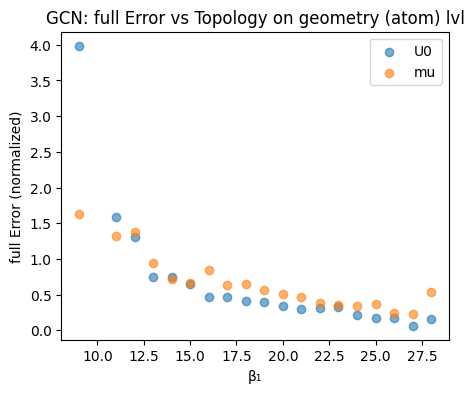

In [154]:
# U0, mu

print('mean full Error per β₁ for U0, mu on geom lvl')

plt.figure(figsize=(5,4))
plt.scatter(np.unique(beta1_geom_U0_6), list_mean_err_full_U0_6_atom, alpha=0.6, label="U0")
plt.scatter(np.unique(beta1_geom_mu_6), list_mean_err_full_mu_6_atom, alpha=0.6, label="mu")
plt.legend(loc="best")
plt.xlabel("β₁")
plt.ylabel("full Error (normalized)")
plt.title(f"{model_name}: full Error vs Topology on geometry (atom) lvl")
plt.show()

mean full Error per β₁ for U0, mu on graph lvl


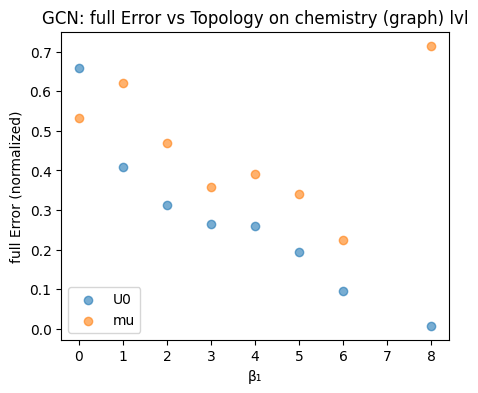

In [155]:
# U0, mu

print('mean full Error per β₁ for U0, mu on graph lvl')

plt.figure(figsize=(5,4))
plt.scatter(np.unique(beta1_graph_U0_6), list_mean_err_full_U0_6, alpha=0.6, label="U0")
plt.scatter(np.unique(beta1_graph_mu_6), list_mean_err_full_mu_6, alpha=0.6, label="mu")
plt.legend(loc="best")
plt.xlabel("β₁")
plt.ylabel("full Error (normalized)")
plt.title(f"{model_name}: full Error vs Topology on chemistry (graph) lvl")
plt.show()

Хотя координаты подаются на вход GCN, они игнорируются при обучении. Тем не менее, MSE очевидно зависит от топологической сложности. Чем больше β₁, тем ниже ошибка. Конволюционные слои хорошо определяют топологическую сложность через data.z. Для предсказания U0 это знание играет большую роль, чем для предсказания mu. Чем больше в молекуле атомов, тем точнее предсказания таргетов.

# ВЫВОДЫ

В данном проекте мы рассмотрели 4 модели с различными Inductive Biases: FCNN, GCN, DistanceGNN и EGNN.

В соответсвующих разделах присутсвуют подробные комментрарии о поставленных задачах и полученных результатах. Подробно описаны таргеты, модели и методы изучения.

In [156]:
# ТАБЛИЦА 1 описание моделей: используемая геометрия (Inductive bias), симметрия, данные для обучения
df_model_description

Model name   Geometry     Inductive bias                    Symmetry  \
0         FCNN          X            No bias                           X   
1          GCN          X      topology bias  permutation, trivial SE(3)   
2  DistanceGNN  distances          d=∥x𝑖−x𝑗∥            SE(3) invariance   
3         EGNN   3D coord  x𝑖−x𝑗 and ∥x𝑖−x𝑗∥          SE(3) equivariance   

     takes from QM9        model input  
0          data.pos        N, 3D coord  
1            data.z     N, z, edge_idx  
2  data.pos, data.z  N, z, edge_idx, d  
3  data.pos, data.z     N, z, 3D coord

В качестве таргетов были выбраны энергия U0 и дипольный момент mu. Каждый из этих таргетов зависит от геометрии молекулы, но по-своему. Для U0 важны знания о топологии и размере молекулы. Для mu - расстояния между атомами и взаимная ориентация этих расстояний (очень важно знать знак и величину заряда, но в QM9 нет этих данных).

FCNN - нулевой baseline, нет заложенных геометрических принципов. Принимает на вход только координаты. Модель предсказывает таргет только на основании знания о количестве атомов в молекуле. Есть подозрение, что благодаря координатам модель улучшает свое знание о размере молекулы.

GCN - graph based модель, которая имеет конволюционные слои и использует massage passing. Игнорирует координаты, предсказывает таргет на основе знания о количестве атомов и атомных числах (+edge_idx). GCN отлично справляется с предсказанием UO, для чего берет знание о размере молекулы из числа атомов, а знание о топологии возможно происходит из data.z&edge_idx. Для mu эти знания полезны заметно слабее.

DistanceGNN - graph based модель, которая использует geometric inductive biase - расстояния между атомами (d). В нашей реализации yбраны конволюционные слои, которые хорошо справились бы с негеометрическими features. DistanceGNN обладает инвариантностью к вращению. Информация о взаимном расположении d утеряна. Это усложняет предсказание U0 через размер молекулы. Для mu расстояния очень важны, но точность предсказания невелика, т.к. знание расстояний без понимания взаимного расположения для mu слабовато.

EGNN - обладает эквивариантностью, координаты вращаются вместе с молекулой. В обучении использует полную информацию об взаимном расположении атомов. При этом U0 практически не использует координаты для улучшения предсказаний, а предсказание mu сильно опирается на координаты и топологию, изученную из координат.

Данные для обучения были разделены на train-test-val с фиксированным seed. Поскольку перед разделением дасат был перемешан, то в дальнейшем, чтобы улучшить воспроизводимость результатов, в лоудерах перемешивание было отключено. К тестовым наборам применялись нормировочные target_mean target_std соответствуещего тренировочного сета. Были получены результаты для разных размеров тренировочных наборов, в рамках одного размера - разных наборах. Результаты тестов были усреднены по экспериментам для модель-размер_тестового_набора-таргет и оформлены в таблицы.

In [202]:
# ТАБЛИЦА 2 MSE в зависимости от модели и таргета для тестового набора в 10к молекул

df_models_10k_mse

Model    U0 test MSE    mu test MSE
0         FCNN  0.47 +/- 0.03  0.62 +/- 0.05
1          GCN  0.36 +/- 0.04  0.51 +/- 0.04
2  DistanceGNN  0.37 +/- 0.04  0.65 +/- 0.06
3         EGNN  0.34 +/- 0.04  0.58 +/- 0.06

In [203]:
# ТАБЛИЦА 3 MSE в зависимости от модели и таргета для тестового набора в 15к молекул

df_models_15k_mse

Model    U0 test MSE    mu test MSE
0         FCNN  0.45 +/- 0.04  0.52 +/- 0.04
1          GCN  0.36 +/- 0.04  0.49 +/- 0.02
2  DistanceGNN  0.36 +/- 0.04  0.60 +/- 0.03
3         EGNN  0.34 +/- 0.04  0.56 +/- 0.06

In [206]:
# ТАБЛИЦА 4 MSE в зависимости от модели и таргета для тестового набора в 104к молекул
df_models_104k_mse

Model    U0 test MSE    mu test MSE
0         FCNN  0.31 +/- 0.02  0.40 +/- 0.03
1          GCN  0.34 +/- 0.04  0.38 +/- 0.02
2  DistanceGNN  0.34 +/- 0.03  0.58 +/- 0.04

Видно, что размер датасета заметно влияет на результаты обучения для FCNN, GCN, DistanceGNN. EGNN хорошо проявил себя на маленьком наборе.

В разделе **Plot training curves** приведены графики тренировок моделей.

На основании таблиц и графиков можно сделать вывод, что наш общий для всех моделей тренировочный набор слишком мал, чтобы сравнивать модели по значениям MSE. Поэтому в своих выводах мы больше опираемся на закономерности и тенденции.

Чтобы посмотреть, являются ли симметрии свойствами модели или изучаемыми, мы провели вращательные тесты на нетренированных и трениорованных моделей. Результаты оформлены в виде таблиц.

In [207]:
# ТАБЛИЦА 5 Результаты теста на вращение для НЕтренированных моделей

df_untrained_rotation_results

Model name Untrained Model metric                metric value
0         FCNN               variance               large -- 1e-2
1          GCN                   ΔMSE                trivial -- 0
2  DistanceGNN                   ΔMSE         very small -- 1e-16
3         EGNN  Δ coord MSE, variance  very small -- 1e-07, 1e-13

In [209]:
# ТАБЛИЦА 6 Результаты теста на вращение для тренированных моделей

df_trained_rotation_results

Model name Trained Model metric         metric value
0         FCNN                 ΔMSE        large -- 1e-1
1          GCN                 ΔMSE         trivial -- 0
2  DistanceGNN                 ΔMSE  very small -- 1e-14
3         EGNN          Δ coord MSE  very small -- 1e-07

Симметрия является свойством модели (симметрии для моделей приведены в таблице 1)

Результатом изучения вляния "обессмысливания" координат - Test geometry ablation - оказалось, что на точность предсказаний вляет тип таргета, симметрии модели и geometric inductive biase. Модели могут изучать топологию молекулы не только из координат, но и других features. И в зависимости от свойств таргета модель адаптируется использовать или не использовать координаты при получении нужных для предсказаний знаний.